## 1. Environment Setup
> Tutorial: Run the next cell to initialize dependencies and plotting defaults before working through the analyses.

Ensure the Python environment includes pandas, numpy, seaborn, and matplotlib.

In [1]:
import datetime; (lambda now: (now.strftime("%Y-%m-%d %H:%M:%S"), now.timestamp()))(datetime.datetime.now())
import glob
import os
from pathlib import Path

import pandas as pd
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

# TinyML-Autopilot Processor Comparison Analysis

## Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Overview and Objectives](#2-overview-and-objectives)
3. [Handling Non-Critical Errors](#3-handling-non-critical-errors)
4. [Data Preparation Workflow](#4-data-preparation-workflow)
5. [Category Assignment](#5-category-assignment)
6. [Batch Aggregation](#6-batch-aggregation)
7. [Comparison Visualizations and Insights](#7-comparison-visualizations-and-insights)
8. [Standalone Success Rate Heatmap](#8-standalone-success-rate-heatmap)
9. [Weighted Success Metrics](#9-weighted-success-metrics)
10. [Model-Level Success Rates](#10-model-level-success-rates)
11. [Multi-Dimensional Comparison](#11-multi-dimensional-comparison)
12. [Temporal Analysis](#12-temporal-analysis)
13. [Temporal Trends](#13-temporal-trends)

## 2. Overview and Objectives
> Tutorial: Review the study scope, processor lineup, and evaluation goals before executing the analysis cells.

This notebook analyzes the performance comparison between **PSG** and **TPUSG** processors across different models and parameter configurations.

### 2.1 Core Analysis Framework
- **2 Processors**: PSG vs TPUSG
- **5 Models**: qwen32b, qwen14b, phi4, gemma3:27b, codestral
- **2 Conditions**: With Parameters vs Without Parameters
- **Goal**: Determine which processor performs better under different configurations

## 3. Handling Non-Critical Errors
> Tutorial: Consult this note when deciding whether to exclude benign runtime issues before aggregating metrics.

These error types do not affect the final pass/fail status of a run.

Original consideration: errors triggered by computer-vision tasks on headless Raspberry Pi or Coral devices that cannot detect a display. They should not be treated as failures.

This guidance now matters only during dedicated error analysis.

## 4. Data Preparation Workflow
> Tutorial: Run the following helper functions to collect raw CSV batches and remove skipped traces before building analysis datasets.

Use these utilities to consolidate batch files and standardize identifiers.

In [2]:
def removed_skipped_errors(df, skipped_set):
    """
    Remove rows where for any (batch_sub, trace_sub) in skipped_set:
    - batch_sub is in the value of 'batch_id'
    - trace_sub is in the value of 'trace_id'
    """
    if not skipped_set or 'batch_id' not in df.columns or 'trace_id' not in df.columns:
        return df

    # Build a boolean mask for all rows to keep
    mask = pd.Series([True] * len(df))
    rows_to_remove = []

    for batch_sub, trace_sub in skipped_set:
        # Find rows where both substrings are present
        match = df['batch_id'].astype(str).str.contains(batch_sub, na=False) & \
                df['trace_id'].astype(str).str.contains(trace_sub, na=False)
        if match.any():
            rows_to_remove.extend(df[match].index.tolist())
            mask = mask & (~match)

    if rows_to_remove:
        print(f"Removing {len(rows_to_remove)} rows due to skipped_error set.")
        # print(df.loc[rows_to_remove][['batch_id', 'trace_id']])
    else:
        print("No rows removed based on skipped_error set.")

    return df[mask].reset_index(drop=True)


def read_csv_filtered(csv_path):
    # Read and clean the dataset
    df = pd.read_csv(csv_path)
    filtered_df = df 
    filtered_df = removed_skipped_errors(df, {})

    return filtered_df


# combine_csv_files()

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

def model_config_trim(value):
    value = value.split("_")[0]
    if "qwen2.5-coder" in value:
        value = value.replace("qwen2.5-coder:", "qwen")
    
    return value

# More robust processor type extraction
def extract_processor(batch_id):
    if 'psg' in batch_id:
        return 'psg'
    elif 'tpusg' in batch_id:
        return 'tpusg'
    elif 'tpsg' in batch_id:
        return 'tpusg'
    elif 'sg' in batch_id:
        return 'sg'
    elif 'dp' in batch_id:
        return 'dp'
    elif 'mc' in batch_id:
        return 'mc'
    else:
        return 'unknown'

# Weighted success rate calculation functions
def calculate_weighted_rates(data_group):
    """Calculate weighted success rates considering generation attempts"""
    # Get successful runs only
    success_data = data_group[data_group['status'] == 'success']
    total_runs = len(data_group)
    
    if success_data.empty or 'generation_count' not in success_data.columns:
        # Return traditional success rate if no generation_count or no successes
        traditional_rate = len(success_data) / total_runs if total_runs > 0 else 0
        return {
            'traditional_success_rate': traditional_rate * 100,
            'efficiency_weighted_rate': traditional_rate * 100,
            'exponential_weighted_rate': traditional_rate * 100, 
            'linear_weighted_rate': traditional_rate * 100,
            'robust_weighted_rate': traditional_rate * 100
        }
    
    # Traditional success rate
    traditional_rate = len(success_data) / total_runs * 100
    
    # Method 1: Efficiency-weighted (1/generation_count)
    efficiency_scores = 1 / success_data['generation_count']
    efficiency_weighted_rate = efficiency_scores.sum() / total_runs * 100
    
    # Method 2: Exponential penalty  
    exponential_scores = np.exp(-0.5 * (success_data['generation_count'] - 1))
    exponential_weighted_rate = exponential_scores.sum() / total_runs * 100
    
    # Method 3: Linear penalty
    linear_scores = 1 - 0.2 * (success_data['generation_count'] - 1)  # 20% penalty per extra generation
    linear_scores = np.maximum(linear_scores, 0.1)  # Minimum score of 0.1
    linear_weighted_rate = linear_scores.sum() / total_runs * 100
    
    # Method 4: Robust/Rank-based (step/bucket approach)
    def robust_score(gen_count):
        if gen_count <= 2:  # First 2 attempts = full credit
            return 1.0
        elif gen_count <= 4:  # 3-4 attempts = partial credit
            return 0.6
        elif gen_count <= 6:  # 5-6 attempts = lower credit
            return 0.3
        else:  # 7+ attempts = minimal credit
            return 0.1
    
    robust_scores = success_data['generation_count'].apply(robust_score)
    robust_weighted_rate = robust_scores.sum() / total_runs * 100
    
    return {
        'traditional_success_rate': traditional_rate,
        'efficiency_weighted_rate': efficiency_weighted_rate,
        'exponential_weighted_rate': exponential_weighted_rate,
        'linear_weighted_rate': linear_weighted_rate,
        'robust_weighted_rate': robust_weighted_rate
    }

## 5. Category Assignment
> Tutorial: Execute the next cell to load the combined dataset, normalize identifiers, and map each run into a processor–model–parameter category.

This step prepares the 20 standardized configuration buckets used throughout the analysis.

In [4]:
# Load the Combined CSV Dataset
csv_path = os.path.join(os.getcwd(), "combined_tinyml_benchmark_data.csv")

# Read and clean the dataset
df = read_csv_filtered(csv_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Clean and prepare data
df.drop(columns=['source_file','trace_id', 'source_path','prompt_cost', 'completion_cost','total_cost'], inplace=True)
df['model_config'] = df['model_config'].apply(model_config_trim)
df['parameters'] = df['parameters'].apply(lambda x: False if pd.isna(x) else len(str(x)) > 0)
df['batch_id'] = df['batch_id'].str.replace("qwen2.5-coder:", "qwen").str.replace("_batch", "")

"""ALLOWING ONLY TPUSG AND PSG"""
# Filter data from July onwards and extract processor type
df = df[df['test_date'].str.split('.').str[0].astype(int)>=7]
df['processor'] = df['batch_id'].map(extract_processor)

# <CHANGES>
allowed_processors = {'psg', 'tpusg'}
df = df[df['processor'].isin(allowed_processors)]
# </CHANGES>
# All rules in the format (processor, model, parameter, category_name)
rules = [
    ('psg',   'qwen32b',   True,  'psg-qwen32b-True'),
    ('psg',   'qwen32b',   False, 'psg-qwen32b-False'),
    ('psg',   'qwen14b',   True,  'psg-qwen14b-True'),
    ('psg',   'qwen14b',   False, 'psg-qwen14b-False'),
    ('psg',   'phi4',      True,  'psg-phi4-True'),
    ('psg',   'phi4',      False, 'psg-phi4-False'),
    ('psg',   'gemma3:27b',True,  'psg-gemma3:27b-True'),
    ('psg',   'gemma3:27b',False, 'psg-gemma3:27b-False'),
    ('psg',   'codestral', True,  'psg-codestral-True'),
    ('psg',   'codestral', False, 'psg-codestral-False'),

    ('tpusg', 'qwen32b',   True,  'tpusg-qwen32b-True'),
    ('tpusg', 'qwen32b',   False, 'tpusg-qwen32b-False'),
    ('tpusg', 'qwen14b',   True,  'tpusg-qwen14b-True'),
    ('tpusg', 'qwen14b',   False, 'tpusg-qwen14b-False'),
    ('tpusg', 'phi4',      True,  'tpusg-phi4-True'),
    ('tpusg', 'phi4',      False, 'tpusg-phi4-False'),
    ('tpusg', 'gemma3:27b',True,  'tpusg-gemma3:27b-True'),
    ('tpusg', 'gemma3:27b',False, 'tpusg-gemma3:27b-False'),
    ('tpusg', 'codestral', True,  'tpusg-codestral-True'),
    ('tpusg', 'codestral', False, 'tpusg-codestral-False'),
]

# Build conditions and choices
conditions = [
    (df['processor'] == proc) &
    (df['model_config'] == model) &
    (df['parameters'] == param)
    for proc, model, param, _ in rules
]
choices = [category for _, _, _, category in rules]

# Create category column
df['category'] = np.select(conditions, choices, default='Other')

print(f"Final shape: {df.shape}")
print(f"Processor distribution: {df['processor'].value_counts().to_dict()}")
print(f"Parameter distribution: {df['parameters'].value_counts().to_dict()}")
print(f"Category distribution: {df['category'].value_counts().to_dict()}")
df.head()

Dataset loaded successfully!
Shape: (1954, 20)
Final shape: (1654, 16)
Processor distribution: {'tpusg': 827, 'psg': 827}
Parameter distribution: {True: 888, False: 766}
Category distribution: {'psg-qwen32b-True': 136, 'tpusg-qwen32b-True': 120, 'tpusg-phi4-True': 120, 'tpusg-qwen14b-False': 109, 'tpusg-qwen32b-False': 90, 'psg-qwen14b-False': 90, 'tpusg-phi4-False': 90, 'psg-codestral-True': 90, 'tpusg-codestral-True': 90, 'psg-phi4-True': 90, 'psg-phi4-False': 90, 'psg-qwen14b-True': 87, 'psg-codestral-False': 72, 'tpusg-qwen14b-True': 60, 'psg-gemma3:27b-False': 60, 'psg-qwen32b-False': 60, 'tpusg-codestral-False': 60, 'psg-gemma3:27b-True': 52, 'tpusg-gemma3:27b-False': 45, 'tpusg-gemma3:27b-True': 43}


num_run                       name              batch_id   status  latency  \
0        1  e2fa_tpu_sketch_generator  codestral_34a5_tpusg  failure   110.76   
1        2  4a9e_tpu_sketch_generator  codestral_34a5_tpusg  failure   100.66   
2        3  d3b0_tpu_sketch_generator  codestral_34a5_tpusg  failure    48.59   
3        4  8c83_tpu_sketch_generator  codestral_34a5_tpusg  failure    99.30   
4        5  05c6_tpu_sketch_generator  codestral_34a5_tpusg  failure   119.65   

   total_tokens  prompt_tokens  completion_tokens  parameters  \
0         13175          10240               2935        True   
1         13827          10240               3587        True   
2         11737          10240               1497        True   
3         13766          10240               3526        True   
4         14585          10240               4345        True   

   generation_count                                               tags  \
0                 5  ['benchmark', 'codestral:latest', 'tpu_sketch_...   
1                 5  ['benchmark', 'codestral:latest', 'tpu_sketch_...   
2                 5  ['benchmark', 'codestral:latest', 'tpu_sketch_...   
3                 5  ['benchmark', 'codestral:latest', 'tpu_sketch_...   
4                 5  ['benchmark', 'codestral:latest', 'tpu_sketch_...   

    timestamp test_date model_config processor              category  
0  1755697779     08.24    codestral     tpusg  tpusg-codestral-True  
1  1755697904     08.24    codestral     tpusg  tpusg-codestral-True  
2  1755698034     08.24    codestral     tpusg  tpusg-codestral-True  
3  1755698097     08.24    codestral     tpusg  tpusg-codestral-True  
4  1755698227     08.24    codestral     tpusg  tpusg-codestral-True

## 6. Batch Aggregation
> Tutorial: Run the following cell to aggregate run-level data into processor/model combinations and compute comparison-ready statistics.

Generates pivot tables, weighted success rates, and advantage summaries for PSG vs TPUSG.

In [5]:
# Core Processor Comparison Analysis

# Calculate success rates for each combination
comparison_df = df.groupby(['processor', 'model_config', 'parameters']).agg({
    'status': ['count', lambda x: (x == 'success').sum()],
    'total_tokens': 'mean'
}).round(2)

comparison_df.columns = ['total_runs', 'successes', 'avg_tokens']
comparison_df['success_rate'] = (comparison_df['successes'] / comparison_df['total_runs'] * 100).round(2)

# Calculate weighted success rates for each group
weighted_rates_list = []
for (processor, model_config, parameters), group in df.groupby(['processor', 'model_config', 'parameters']):
    weighted_rates = calculate_weighted_rates(group)
    weighted_rates_list.append({
        'processor': processor,
        'model_config': model_config, 
        'parameters': parameters,
        **weighted_rates
    })

# Convert to DataFrame and merge with comparison_df
weighted_df = pd.DataFrame(weighted_rates_list)
comparison_df = comparison_df.reset_index()

# Merge the weighted rates
comparison_df = comparison_df.merge(
    weighted_df[['processor', 'model_config', 'parameters', 
                'efficiency_weighted_rate', 'exponential_weighted_rate', 
                'linear_weighted_rate', 'robust_weighted_rate']], 
    on=['processor', 'model_config', 'parameters'], 
    how='left'
)

# Round weighted rates to 2 decimal places
for col in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    comparison_df[col] = comparison_df[col].round(2)

print(f"Total runs: {len(df)}",end=": ")
print(f"PSG/TPUSG runs: {len(df[df['processor'] == 'psg'])}/{len(df[df['processor'] == 'tpusg'])}")
 
print(f"Models : {', '.join(sorted(df['model_config'].unique()))}")
print(f"Parameter conditions: P ({len(df[df['parameters'] == True])}) vs NP ({len(df[df['parameters'] == False])})")

print(f"\n📈 Complete Processor Comparison Matrix:")
print("-" * 60)

# Create a comprehensive comparison table
pivot_table = comparison_df.pivot_table(
    values='success_rate',
    index=['model_config', 'parameters'], 
    columns='processor',
    fill_value=0
).round(1)

print(pivot_table)

# Calculate processor advantage
print(f"\n🎯 PROCESSOR ADVANTAGE ANALYSIS:")
print("-" * 60)

advantage_data = []
for model in comparison_df['model_config'].unique():
    for param_condition in [True, False]:
        model_data = comparison_df[
            (comparison_df['model_config'] == model) & 
            (comparison_df['parameters'] == param_condition)
        ]
        
        if len(model_data) == 2:  # Both processors tested
            psg_rate = model_data[model_data['processor'] == 'psg']['success_rate'].iloc[0]
            tpusg_rate = model_data[model_data['processor'] == 'tpusg']['success_rate'].iloc[0]
            advantage = tpusg_rate - psg_rate
            winner = 'TPUSG' if advantage > 0 else 'PSG' if advantage < 0 else 'TIE'
            
            advantage_data.append({
                'model': model,
                'parameters': 'With' if param_condition else 'Without',
                'psg_rate': psg_rate,
                'tpusg_rate': tpusg_rate,
                'advantage': advantage,
                'winner': winner
            })

advantage_df = pd.DataFrame(advantage_data)

# Display advantage analysis
for _, row in advantage_df.iterrows():
    param_str = row['parameters']
    print(f"{row['model']} ({param_str} params): PSG {row['psg_rate']:.1f}% vs TPUSG {row['tpusg_rate']:.1f}% → {row['winner']} (+{row['advantage']:.1f}%)")

# Summary statistics
psg_wins = len(advantage_df[advantage_df['winner'] == 'PSG'])
tpusg_wins = len(advantage_df[advantage_df['winner'] == 'TPUSG'])
ties = len(advantage_df[advantage_df['winner'] == 'TIE'])

print(f"\n📊 SUMMARY:")
print(f"PSG wins: {psg_wins}/{len(advantage_df)} configurations")
print(f"TPUSG wins: {tpusg_wins}/{len(advantage_df)} configurations") 
print(f"Ties: {ties}/{len(advantage_df)} configurations")

# Display comparison_df with all rates for verification
print(f"\n📋 COMPLETE COMPARISON TABLE (Traditional + Weighted Success Rates):")
print("-" * 100)
comparison_df["num_batches"]=(comparison_df['total_runs']/30).round(1)
display_columns = ['processor', 'model_config', 'parameters', 'total_runs', 'num_batches', 'successes', 
                   'success_rate', 'efficiency_weighted_rate', 'exponential_weighted_rate', 
                   'linear_weighted_rate', 'robust_weighted_rate', 'avg_tokens']
comparison_df[display_columns]

Total runs: 1654: PSG/TPUSG runs: 827/827
Models : codestral, gemma3:27b, phi4, qwen14b, qwen32b
Parameter conditions: P (888) vs NP (766)

📈 Complete Processor Comparison Matrix:
------------------------------------------------------------
processor                  psg  tpusg
model_config parameters              
codestral    False        50.0   33.3
             True         10.0   14.4
gemma3:27b   False        53.3    6.7
             True         71.2    0.0
phi4         False        77.8   95.6
             True        100.0  100.0
qwen14b      False        52.2   94.5
             True          4.6  100.0
qwen32b      False        50.0   96.7
             True         39.7   35.0

🎯 PROCESSOR ADVANTAGE ANALYSIS:
------------------------------------------------------------
codestral (With params): PSG 10.0% vs TPUSG 14.4% → TPUSG (+4.4%)
codestral (Without params): PSG 50.0% vs TPUSG 33.3% → PSG (+-16.7%)
gemma3:27b (With params): PSG 71.2% vs TPUSG 0.0% → PSG (+-71.2%)
gemma3:2

processor model_config  parameters  total_runs  num_batches  successes  \
0        psg    codestral       False          72          2.4         36   
1        psg    codestral        True          90          3.0          9   
2        psg   gemma3:27b       False          60          2.0         32   
3        psg   gemma3:27b        True          52          1.7         37   
4        psg         phi4       False          90          3.0         70   
5        psg         phi4        True          90          3.0         90   
6        psg      qwen14b       False          90          3.0         47   
7        psg      qwen14b        True          87          2.9          4   
8        psg      qwen32b       False          60          2.0         30   
9        psg      qwen32b        True         136          4.5         54   
10     tpusg    codestral       False          60          2.0         20   
11     tpusg    codestral        True          90          3.0         13   
12     tpusg   gemma3:27b       False          45          1.5          3   
13     tpusg   gemma3:27b        True          43          1.4          0   
14     tpusg         phi4       False          90          3.0         86   
15     tpusg         phi4        True         120          4.0        120   
16     tpusg      qwen14b       False         109          3.6        103   
17     tpusg      qwen14b        True          60          2.0         60   
18     tpusg      qwen32b       False          90          3.0         87   
19     tpusg      qwen32b        True         120          4.0         42   

    success_rate  efficiency_weighted_rate  exponential_weighted_rate  \
0          50.00                     25.16                      28.16   
1          10.00                      2.67                       2.52   
2          53.33                     30.42                      32.13   
3          71.15                     15.58                      11.99   
4          77.78                     37.85                      39.12   
5         100.00                    100.00                     100.00   
6          52.22                     28.26                      30.20   
7           4.60                      1.38                       1.37   
8          50.00                     35.53                      36.00   
9          39.71                      9.62                       8.19   
10         33.33                     12.94                      13.35   
11         14.44                      4.06                       3.99   
12          6.67                      3.41                       3.34   
13          0.00                      0.00                       0.00   
14         95.56                     74.57                      77.03   
15        100.00                    100.00                     100.00   
16         94.50                     72.35                      75.09   
17        100.00                    100.00                     100.00   
18         96.67                     72.26                      75.12   
19         35.00                      9.51                       9.13   

    linear_weighted_rate  robust_weighted_rate  avg_tokens  
0                  36.67                 42.92    10099.29  
1                   4.22                  5.33    13197.82  
2                  39.67                 44.00     9948.50  
3                  19.62                 29.42    12714.37  
4                  49.56                 56.44     9168.93  
5                 100.00                100.00     2242.97  
6                  37.78                 42.33     9432.88  
7                   2.07                  2.87    11955.85  
8                  40.00                 42.33     9810.17  
9                  12.94                 18.09    13483.35  
10                 18.67                 22.50    12645.87  
11                  6.67                  8.00    13281.28  
12                  4.00                  4.22    15040.49

## 7. Comparison Visualizations and Insights
> Tutorial: Execute the visualization block to generate heatmaps and summary graphics that highlight processor performance differences.

Use these figures to support narrative insights and export publication-ready plots.


📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS

Model-by-model average success rates (%):
processor       psg  tpusg
model_config              
codestral     30.00  23.88
gemma3:27b    62.24   3.34
phi4          88.89  97.78
qwen14b       28.41  97.25
qwen32b       44.86  65.84
📝 Exported processor comparison dataset to processor_comparison_plot_data.csv

Model-by-model average success rates (%):
processor       psg  tpusg
model_config              
codestral     30.00  23.88
gemma3:27b    62.24   3.34
phi4          88.89  97.78
qwen14b       28.41  97.25
qwen32b       44.86  65.84
📝 Exported processor comparison dataset to processor_comparison_plot_data.csv


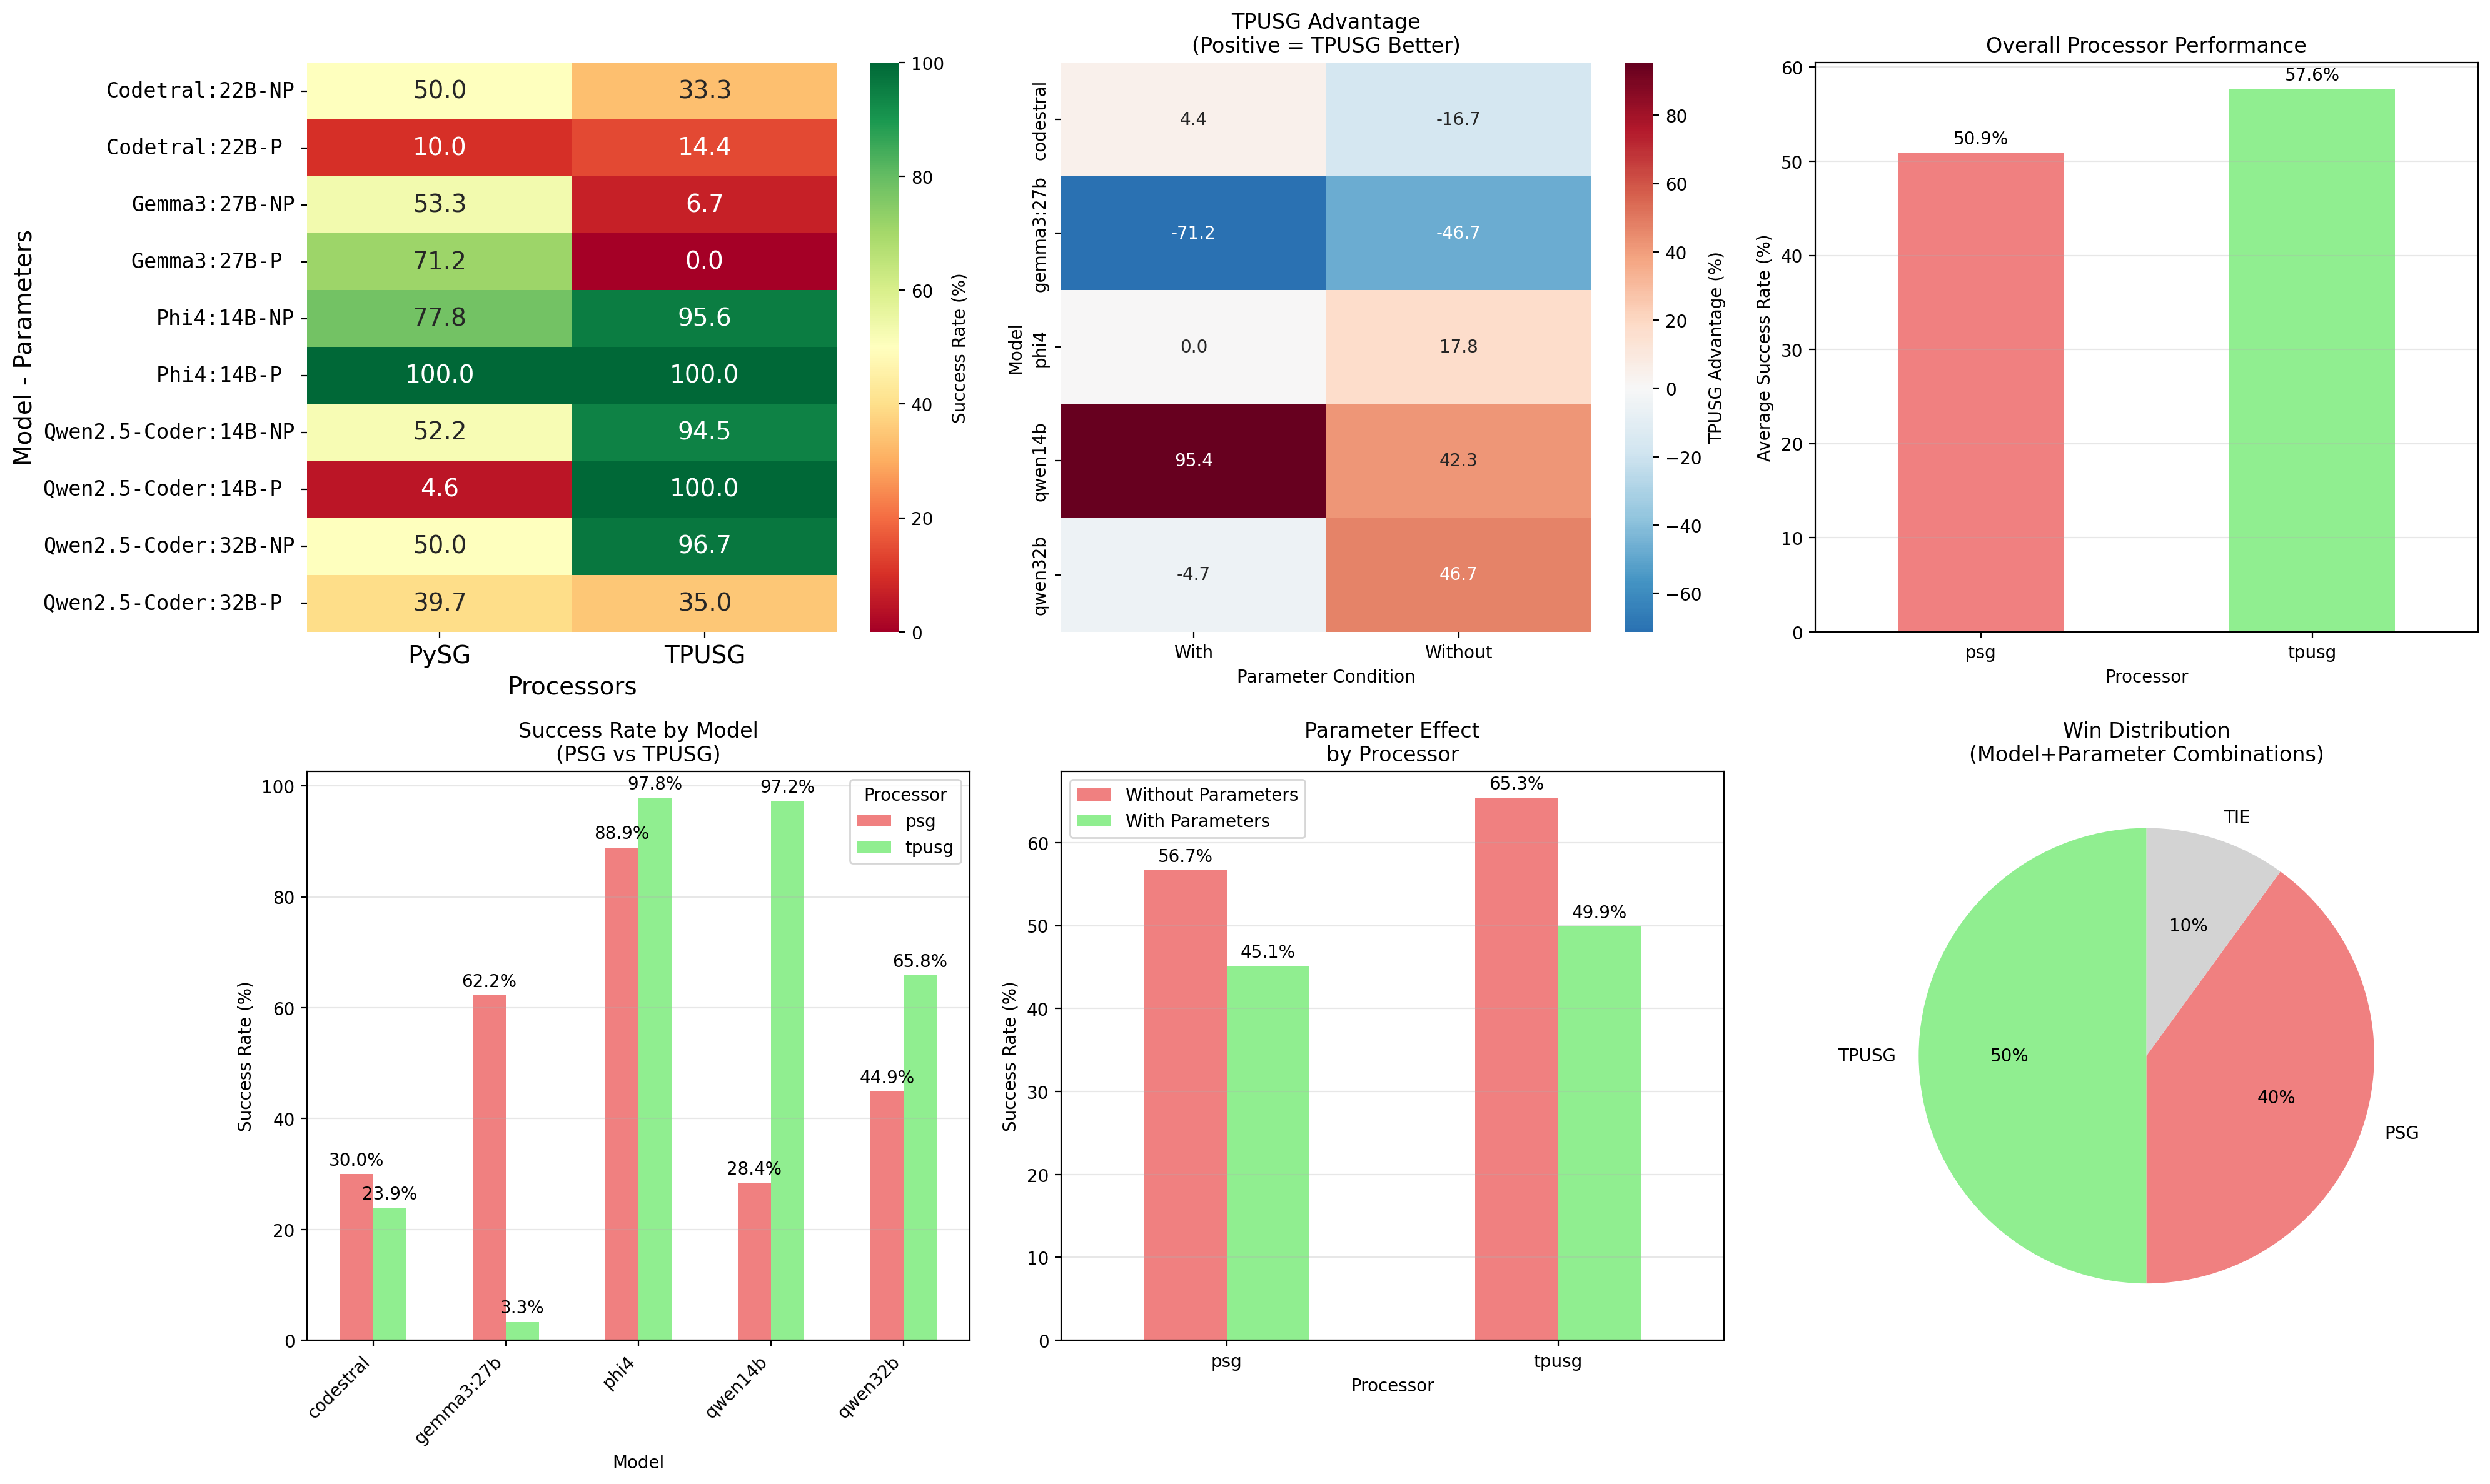

✅ Processor comparison visualizations created successfully!
📊 Analysis shows clear performance differences between PSG and TPUSG processors


In [6]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
 
# Processor Comparison Visualizations
print("\n📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS")
print("=" * 60)

fig = plt.figure(figsize=(20, 12))

# 1. Head-to-Head Comparison map as well as SAVE AX1 INTO A SEPERATE PDF

ax1 = plt.subplot(2, 3, 1)
fig_single, ax_single = plt.subplots(figsize=(10, 8))

# <CHANGES>
# Filter pivot_table to only include psg and tpusg processors
psg_tpusg_pivot = pivot_table[['psg', 'tpusg']] if 'psg' in pivot_table.columns and 'tpusg' in pivot_table.columns else pivot_table
# </CHANGES>

hm_ylabels = [
    "Codetral:22B-NP",
    "Codetral:22B-P ",
    "Gemma3:27B-NP",
    "Gemma3:27B-P ",
    "Phi4:14B-NP",
    "Phi4:14B-P ",
    "Qwen2.5-Coder:14B-NP",
    "Qwen2.5-Coder:14B-P ",
    "Qwen2.5-Coder:32B-NP",
    "Qwen2.5-Coder:32B-P "
]
map_params = dict(annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={
        'label': 'Success Rate (%)',
        'shrink': 1,  # Optional: shrink colorbar size
     },
    annot_kws={"size": 14})
hm_title=dict(label='Success Rate Comparison\n(PSG vs TPUSG)', fontsize=16)
hm_xlabel=dict(xlabel='Processors', fontsize=14)
hm_ylabel=dict(ylabel='Model - Parameters',fontsize=14)
# <CHANGES>
# Create x-tick labels based on actual columns
xticklabels = ["PySG" if col == 'psg' else "TPUSG" if col == 'tpusg' else col.upper() for col in psg_tpusg_pivot.columns]
hm_xticklabels=dict(labels=xticklabels, fontsize=14, rotation=0)
# </CHANGES>

hm_yticklabels=dict(labels=hm_ylabels, fontsize=12, rotation=0,fontfamily='monospace')

for ax0 in [ax1,ax_single]:
    # <CHANGES>
    sns.heatmap(psg_tpusg_pivot, **map_params, ax=ax0)
    # </CHANGES>
    # ax0.set_title(**hm_title)
    ax0.set_xlabel(**hm_xlabel)
    ax0.set_ylabel(**hm_ylabel)
    ax0.set_xticklabels(**hm_xticklabels)
    ax0.set_yticklabels(**hm_yticklabels)

fig_single.tight_layout()
with PdfPages("ax1_map.pdf") as pdf:
    pdf.savefig(fig_single,dpi=400,bbox_inches="tight")

plt.close(fig_single)  # optional: free memory

####################################################

# 2. Advantage map (TPUSG - PSG)
ax2 = plt.subplot(2, 3, 2)
advantage_pivot = advantage_df.pivot_table(
    values='advantage',
    index='model',
    columns='parameters',
    fill_value=0
).round(1)

sns.heatmap(advantage_pivot, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'TPUSG Advantage (%)'}, ax=ax2)
ax2.set_title('TPUSG Advantage\n(Positive = TPUSG Better)')
ax2.set_xlabel('Parameter Condition')
ax2.set_ylabel('Model')

# 3. Overall Processor Performance
ax3 = plt.subplot(2, 3, 3)
overall_performance = comparison_df.groupby('processor')['success_rate'].mean()
bars = overall_performance.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightgreen'])
ax3.set_title('Overall Processor Performance')
ax3.set_ylabel('Average Success Rate (%)')
ax3.set_xlabel('Processor')
plt.xticks(rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(overall_performance.values):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center')

# 4. Model-by-Model Comparison
ax4 = plt.subplot(2, 3, 4)
model_comparison = comparison_df.groupby(['model_config', 'processor'])['success_rate'].mean().unstack()
model_comparison.plot(kind='bar', ax=ax4, color=['lightcoral', 'lightgreen'])
ax4.set_title('Success Rate by Model\n(PSG vs TPUSG)')
ax4.set_xlabel('Model')
ax4.set_ylabel('Success Rate (%)')
ax4.legend(title='Processor')
plt.xticks(rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)
# <CHANGES>
for container in ax4.containers:
    ax4.bar_label(container, fmt='%.1f%%', padding=3)
# </CHANGES>

print("\nModel-by-model average success rates (%):")
print(model_comparison.round(2))

# 5. Parameter Effect Comparison
ax5 = plt.subplot(2, 3, 5)
param_effect = comparison_df.groupby(['processor', 'parameters'])['success_rate'].mean().unstack()
param_effect.columns = ['Without Parameters', 'With Parameters']
param_effect.plot(kind='bar', ax=ax5, color=['lightcoral', 'lightgreen'])
ax5.set_title('Parameter Effect\nby Processor')
ax5.set_xlabel('Processor')
ax5.set_ylabel('Success Rate (%)')
ax5.legend()
plt.xticks(rotation=0)
ax5.grid(axis='y', alpha=0.3)
# <CHANGES>
for container in ax5.containers:
    ax5.bar_label(container, fmt='%.1f%%', padding=3)
# </CHANGES>

# 6. Win Distribution
ax6 = plt.subplot(2, 3, 6)
win_counts = advantage_df['winner'].value_counts()
# <CHANGES>
export_rows = []
for model_config, row in psg_tpusg_pivot.iterrows():
    for processor_name, value in row.items():
        export_rows.append({
            "plot": "head_to_head_heatmap",
            "model_config": model_config,
            "parameters": "",
            "processor": processor_name,
            "value": float(value)
        })
for model_name, row in advantage_pivot.iterrows():
    for param_condition, value in row.items():
        export_rows.append({
            "plot": "tpu_advantage_heatmap",
            "model_config": model_name,
            "parameters": str(param_condition),
            "processor": "tpusg_minus_psg",
            "value": float(value)
        })
for processor_name, value in overall_performance.items():
    export_rows.append({
        "plot": "overall_processor_performance",
        "model_config": "",
        "parameters": "",
        "processor": processor_name,
        "value": float(value)
    })
for model_config, row in model_comparison.iterrows():
    for processor_name, value in row.items():
        export_rows.append({
            "plot": "model_by_model_bar",
            "model_config": model_config,
            "parameters": "",
            "processor": processor_name,
            "value": float(value)
        })
for processor_name, row in param_effect.iterrows():
    for parameter_condition, value in row.items():
        export_rows.append({
            "plot": "parameter_effect_bar",
            "model_config": "",
            "parameters": parameter_condition,
            "processor": processor_name,
            "value": float(value)
        })
for winner_label, count in win_counts.items():
    export_rows.append({
        "plot": "win_distribution_pie",
        "model_config": "",
        "parameters": "",
        "processor": winner_label,
        "value": int(count)
    })
export_df = pd.DataFrame(export_rows)
export_path = "processor_comparison_plot_data.csv"
export_df.to_csv(export_path, index=False)
print(f"📝 Exported processor comparison dataset to {export_path}")
# </CHANGES>
colors_pie = ['lightgreen' if x == 'TPUSG' else 'lightcoral' if x == 'PSG' else 'lightgray' for x in win_counts.index]
ax6.pie(win_counts.values, labels=win_counts.index, autopct='%1.0f%%',  colors=colors_pie, startangle=90)
ax6.set_title('Win Distribution\n(Model+Parameter Combinations)')
plt.tight_layout()
# <CHANGES>
with PdfPages("processor_comparison_panels.pdf") as pdf:
    pdf.savefig(fig, dpi=400, bbox_inches="tight")
# </CHANGES>

plt.show()

print("✅ Processor comparison visualizations created successfully!")
print(f"📊 Analysis shows clear performance differences between PSG and TPUSG processors")

## 8. Standalone Success Rate Heatmap
> Tutorial: Re-run this segment when you need an isolated PSG vs TPUSG heatmap for presentations or papers.

In [7]:
# Extract Heatmap Data for External Plotting
# ============================================================================

# Filter pivot_table to only include psg and tpusg processors
psg_tpusg_pivot = pivot_table[['psg', 'tpusg']] if 'psg' in pivot_table.columns and 'tpusg' in pivot_table.columns else pivot_table

# Reset index to make model_config and parameters regular columns
heatmap_data = psg_tpusg_pivot.reset_index()

# Create structured data for export
print("=" * 80)
print("HEATMAP DATA STRUCTURE (20 rows × 4 columns)")
print("=" * 80)
print(heatmap_data.to_string(index=False))

print("\n" + "=" * 80)
print("EXPORT FORMATS")
print("=" * 80)

# 1. Python dictionary format
print("\n# 1. Python Dictionary Format:")
print("-" * 80)
data_dict = heatmap_data.to_dict('records')
for i, row in enumerate(data_dict, 1):
    print(f"{i:2d}. {row}")

# 2. CSV format
print("\n# 2. CSV Format:")
print("-" * 80)
csv_string = heatmap_data.to_csv(index=False)
print(csv_string)

# 3. JSON format
print("\n# 3. JSON Format:")
print("-" * 80)
json_string = heatmap_data.to_json(orient='records', indent=2)
print(json_string)

# 4. LaTeX table format
print("\n# 4. LaTeX Table Format:")
print("-" * 80)
latex_string = heatmap_data.to_latex(index=False)
print(latex_string)

# Save to files
heatmap_data.to_csv('heatmap_data_psg_vs_tpusg.csv', index=False)
heatmap_data.to_json('heatmap_data_psg_vs_tpusg.json', orient='records', indent=2)

print("\n" + "=" * 80)
print("✅ Data saved to:")
print("   - heatmap_data_psg_vs_tpusg.csv")
print("   - heatmap_data_psg_vs_tpusg.json")
print("=" * 80)

HEATMAP DATA STRUCTURE (20 rows × 4 columns)
model_config  parameters   psg  tpusg
   codestral       False  50.0   33.3
   codestral        True  10.0   14.4
  gemma3:27b       False  53.3    6.7
  gemma3:27b        True  71.2    0.0
        phi4       False  77.8   95.6
        phi4        True 100.0  100.0
     qwen14b       False  52.2   94.5
     qwen14b        True   4.6  100.0
     qwen32b       False  50.0   96.7
     qwen32b        True  39.7   35.0

EXPORT FORMATS

# 1. Python Dictionary Format:
--------------------------------------------------------------------------------
 1. {'model_config': 'codestral', 'parameters': False, 'psg': 50.0, 'tpusg': 33.3}
 2. {'model_config': 'codestral', 'parameters': True, 'psg': 10.0, 'tpusg': 14.4}
 3. {'model_config': 'gemma3:27b', 'parameters': False, 'psg': 53.3, 'tpusg': 6.7}
 4. {'model_config': 'gemma3:27b', 'parameters': True, 'psg': 71.2, 'tpusg': 0.0}
 5. {'model_config': 'phi4', 'parameters': False, 'psg': 77.8, 'tpusg': 95.6}


## 9. Weighted Success Metrics
> Tutorial: Run the next cell to compare traditional and weighted success measures when evaluating PSG versus TPUSG.

Review these outputs to understand how retry attempts influence processor rankings.

In [8]:
# Processor Comparison Insights & Recommendations
print("\n🎓 PROCESSOR COMPARISON INSIGHTS")
print("=" * 60)

# Overall processor performance - Traditional + Weighted
print(f"📊 OVERALL PERFORMANCE:")

psg_overall = comparison_df[comparison_df['processor'] == 'psg']['success_rate'].mean()
tpusg_overall = comparison_df[comparison_df['processor'] == 'tpusg']['success_rate'].mean()

print(f"Traditional Success Rate:")
print(f"  PSG Average: {psg_overall:.1f}%")
print(f"  TPUSG Average: {tpusg_overall:.1f}%")
print(f"  Overall Winner: {'TPUSG' if tpusg_overall > psg_overall else 'PSG'} (+{abs(tpusg_overall - psg_overall):.1f}%)")

# Weighted averages
for method in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_weighted = comparison_df[comparison_df['processor'] == 'psg'][method].mean()
    tpusg_weighted = comparison_df[comparison_df['processor'] == 'tpusg'][method].mean()
    winner = 'TPUSG' if tpusg_weighted > psg_weighted else 'PSG'
    diff = abs(tpusg_weighted - psg_weighted)
    
    method_name = method.replace('_weighted_rate', '').replace('_', ' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG Average: {psg_weighted:.1f}%")
    print(f"  TPUSG Average: {tpusg_weighted:.1f}%")
    print(f"  Winner: {winner} (+{diff:.1f}%)")

# Parameter effect analysis - Traditional + Weighted
print(f"\n⚙️ PARAMETER EFFECTS:")

# Traditional rates
psg_with_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
psg_without_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['success_rate'].mean()
tpusg_with_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
tpusg_without_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['success_rate'].mean()

print(f"Traditional Success Rate:")
print(f"  PSG: With params {psg_with_params:.1f}% vs Without params {psg_without_params:.1f}% (Effect: {psg_with_params - psg_without_params:+.1f}%)")
print(f"  TPUSG: With params {tpusg_with_params:.1f}% vs Without params {tpusg_without_params:.1f}% (Effect: {tpusg_with_params - tpusg_without_params:+.1f}%)")

# Weighted parameter effects
for method in ['efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_with = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)][method].mean()
    psg_without = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)][method].mean()
    tpusg_with = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)][method].mean()
    tpusg_without = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)][method].mean()
    
    method_name = method.replace('_weighted_rate', '').replace('_', ' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG: With params {psg_with:.1f}% vs Without params {psg_without:.1f}% (Effect: {psg_with - psg_without:+.1f}%)")
    print(f"  TPUSG: With params {tpusg_with:.1f}% vs Without params {tpusg_without:.1f}% (Effect: {tpusg_with - tpusg_without:+.1f}%)")

# Model-specific recommendations
# print(f"\n💡 MODEL-SPECIFIC RECOMMENDATIONS:")
for model in sorted(comparison_df['model_config'].unique()):
    model_data = advantage_df[advantage_df['model'] == model]
    
    if len(model_data) > 0:
        best_configs = []
        for _, row in model_data.iterrows():
            if row['winner'] != 'TIE':
                param_str = row['parameters'].lower()
                best_configs.append(f"{row['winner']} {param_str} params ({row[row['winner'].lower() + '_rate']:.1f}%)")
        
        if best_configs:
            best_config = max(best_configs, key=lambda x: float(x.split('(')[1].split('%')[0]))
            # print(f"   {model}: {best_config}")

# Strategic insights
psg_wins = len(advantage_df[advantage_df['winner'] == 'PSG'])
tpusg_wins = len(advantage_df[advantage_df['winner'] == 'TPUSG'])
ties = len(advantage_df[advantage_df['winner'] == 'TIE'])

 
print(f"\n⚙️ PARAMETER USAGE STRATEGY:")
print(f"   PSG: Parameters {'help' if psg_with_params > psg_without_params else 'hurt'} performance ({psg_with_params - psg_without_params:+.1f}%)")
print(f"   TPUSG: Parameters {'help' if tpusg_with_params > tpusg_without_params else 'hurt'} performance ({tpusg_with_params - tpusg_without_params:+.1f}%)")
 
# Show efficiency impact summa 


🎓 PROCESSOR COMPARISON INSIGHTS
📊 OVERALL PERFORMANCE:
Traditional Success Rate:
  PSG Average: 50.9%
  TPUSG Average: 57.6%
  Overall Winner: TPUSG (+6.7%)
Efficiency Weighted:
  PSG Average: 28.6%
  TPUSG Average: 44.9%
  Winner: TPUSG (+16.3%)
Exponential Weighted:
  PSG Average: 29.0%
  TPUSG Average: 45.7%
  Winner: TPUSG (+16.7%)
Linear Weighted:
  PSG Average: 34.3%
  TPUSG Average: 49.4%
  Winner: TPUSG (+15.1%)
Robust Weighted:
  PSG Average: 38.4%
  TPUSG Average: 52.1%
  Winner: TPUSG (+13.8%)

⚙️ PARAMETER EFFECTS:
Traditional Success Rate:
  PSG: With params 45.1% vs Without params 56.7% (Effect: -11.6%)
  TPUSG: With params 49.9% vs Without params 65.3% (Effect: -15.5%)
Efficiency Weighted:
  PSG: With params 25.9% vs Without params 31.4% (Effect: -5.6%)
  TPUSG: With params 42.7% vs Without params 47.1% (Effect: -4.4%)
Exponential Weighted:
  PSG: With params 24.8% vs Without params 33.1% (Effect: -8.3%)
  TPUSG: With params 42.6% vs Without params 48.8% (Effect: -6.2%)

### 9.1 Parameter Strategy Notes
> Tutorial: Capture the textual recommendations from the preceding cell to guide follow-up experiments or reporting.


📊 TRADITIONAL vs WEIGHTED SUCCESS RATES COMPARISON


/tmp/ipykernel_970005/2114107918.py:146: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_970005/2114107918.py:146: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_970005/2114107918.py:146: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/han/anaconda3/envs/llmdev/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/han/anaconda3/envs/llmdev/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/han/anaconda3/envs/llmdev/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12826

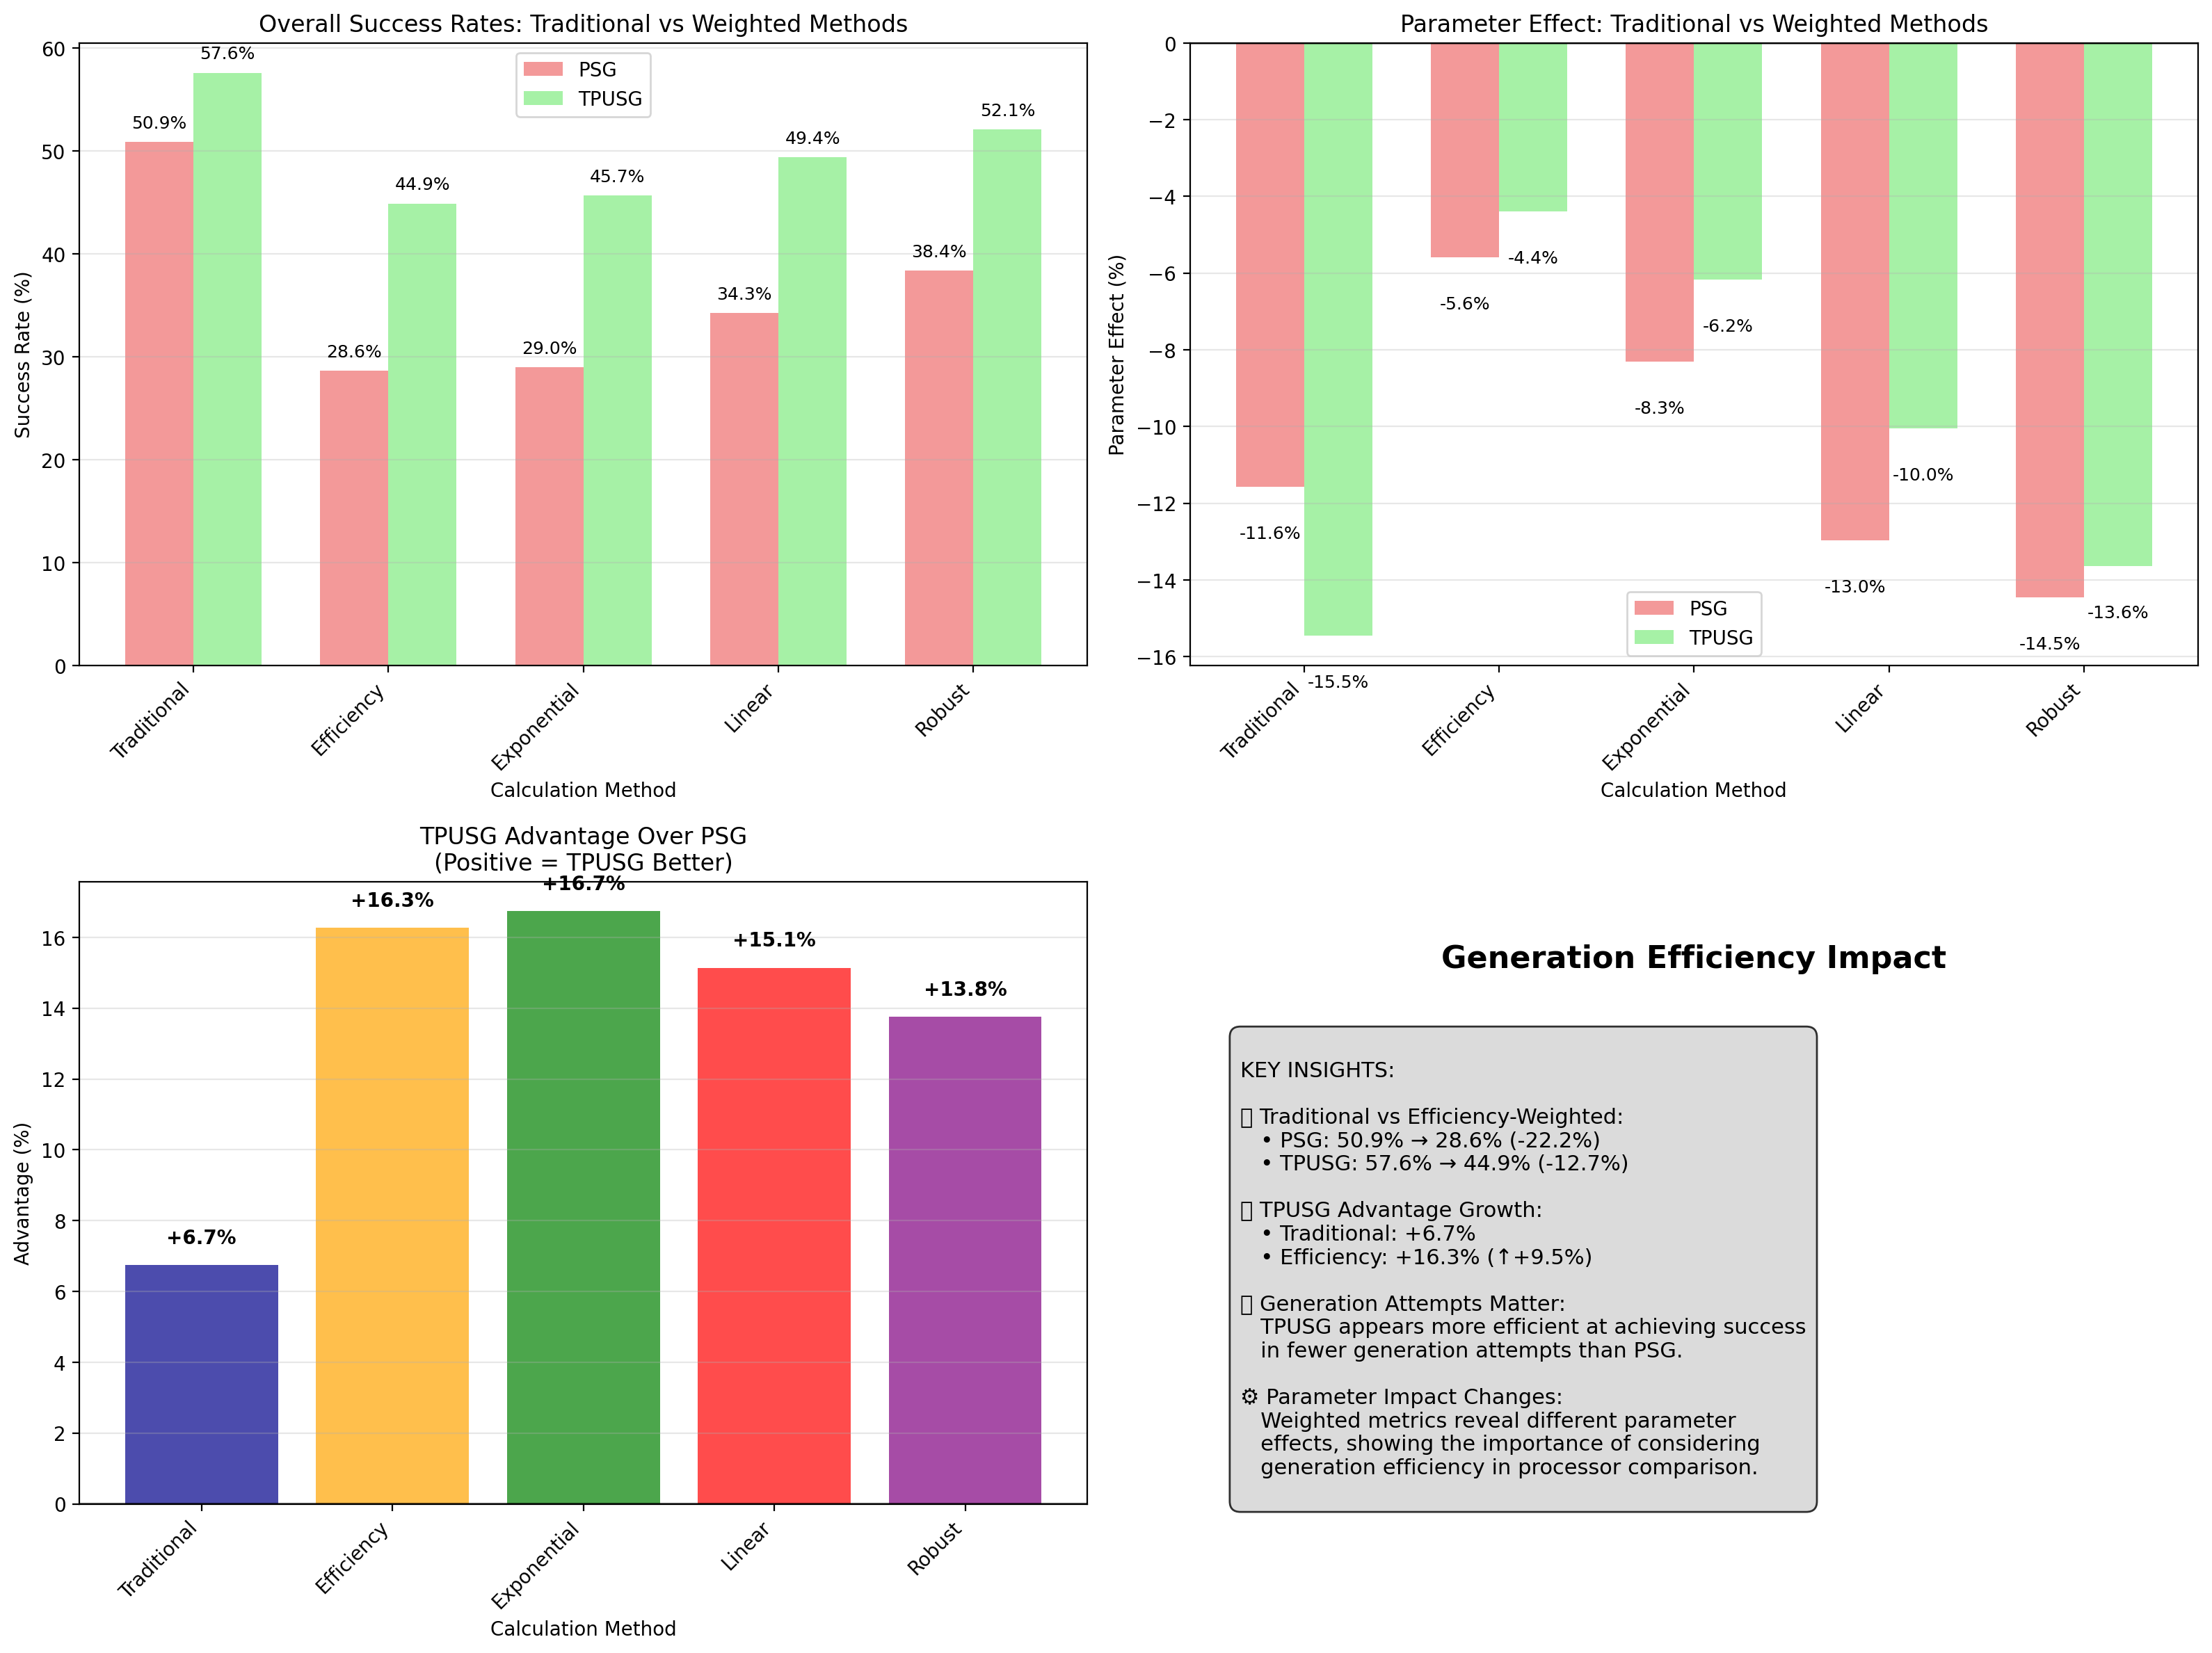

✅ Weighted success rate analysis complete!
📈 The efficiency-weighted metrics show TPUSG has a 16.3% advantage vs 6.7% traditional.


In [9]:
# Weighted vs Traditional Success Rate Comparison Visualization
print("\n📊 TRADITIONAL vs WEIGHTED SUCCESS RATES COMPARISON")
print("=" * 70)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Performance Comparison (Traditional vs Efficiency-weighted)
methods = ['Traditional', 'Efficiency', 'Exponential', 'Linear', 'Robust']
psg_rates = [
    comparison_df[comparison_df['processor'] == 'psg']['success_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['efficiency_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['exponential_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['linear_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'psg']['robust_weighted_rate'].mean()
]
tpusg_rates = [
    comparison_df[comparison_df['processor'] == 'tpusg']['success_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['efficiency_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['exponential_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['linear_weighted_rate'].mean(),
    comparison_df[comparison_df['processor'] == 'tpusg']['robust_weighted_rate'].mean()
]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, psg_rates, width, label='PSG', color='lightcoral', alpha=0.8)
bars2 = ax1.bar(x + width/2, tpusg_rates, width, label='TPUSG', color='lightgreen', alpha=0.8)

ax1.set_title('Overall Success Rates: Traditional vs Weighted Methods')
ax1.set_xlabel('Calculation Method')
ax1.set_ylabel('Success Rate (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (p, t) in enumerate(zip(psg_rates, tpusg_rates)):
    ax1.text(i - width/2, p + 1, f'{p:.1f}%', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, t + 1, f'{t:.1f}%', ha='center', va='bottom', fontsize=9)


# 2. Parameter Effect Comparison
param_methods = ['Traditional', 'Efficiency', 'Exponential', 'Linear', 'Robust']
psg_param_effect = [
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['success_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['success_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['efficiency_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['efficiency_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['exponential_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['exponential_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['linear_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['linear_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['robust_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['robust_weighted_rate'].mean()
]

tpusg_param_effect = [
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['success_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['success_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['efficiency_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['efficiency_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['exponential_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['exponential_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['linear_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['linear_weighted_rate'].mean(),
    
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['robust_weighted_rate'].mean() - 
    comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['robust_weighted_rate'].mean()
]

x2 = np.arange(len(param_methods))
bars3 = ax2.bar(x2 - width/2, psg_param_effect, width, label='PSG', color='lightcoral', alpha=0.8)
bars4 = ax2.bar(x2 + width/2, tpusg_param_effect, width, label='TPUSG', color='lightgreen', alpha=0.8)

ax2.set_title('Parameter Effect: Traditional vs Weighted Methods')
ax2.set_xlabel('Calculation Method')
ax2.set_ylabel('Parameter Effect (%)')
ax2.set_xticks(x2)
ax2.set_xticklabels(param_methods, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels
for i, (p, t) in enumerate(zip(psg_param_effect, tpusg_param_effect)):
    ax2.text(i - width/2, p + 0.5 if p > 0 else p - 1, f'{p:+.1f}%', ha='center', va='bottom' if p > 0 else 'top', fontsize=9)
    ax2.text(i + width/2, t + 0.5 if t > 0 else t - 1, f'{t:+.1f}%', ha='center', va='bottom' if t > 0 else 'top', fontsize=9)

# 3. Advantage Gap Analysis
advantages = []
for method in ['success_rate', 'efficiency_weighted_rate', 'exponential_weighted_rate', 'linear_weighted_rate', 'robust_weighted_rate']:
    psg_avg = comparison_df[comparison_df['processor'] == 'psg'][method].mean()
    tpusg_avg = comparison_df[comparison_df['processor'] == 'tpusg'][method].mean()
    advantages.append(tpusg_avg - psg_avg)

colors = ['darkblue', 'orange', 'green', 'red', 'purple']
bars5 = ax3.bar(methods, advantages, color=colors, alpha=0.7)
ax3.set_title('TPUSG Advantage Over PSG\n(Positive = TPUSG Better)')
ax3.set_xlabel('Calculation Method')
ax3.set_ylabel('Advantage (%)')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(advantages):
    ax3.text(i, v + 0.5 if v > 0 else v - 1, f'{v:+.1f}%', ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

# 4. Efficiency Impact Visualization
ax4.axis('off')
ax4.text(0.5, 0.9, 'Generation Efficiency Impact', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax4.transAxes)

summary_text = f"""
KEY INSIGHTS:

🎯 Traditional vs Efficiency-Weighted:
   • PSG: {psg_rates[0]:.1f}% → {psg_rates[1]:.1f}% ({psg_rates[1]-psg_rates[0]:+.1f}%)
   • TPUSG: {tpusg_rates[0]:.1f}% → {tpusg_rates[1]:.1f}% ({tpusg_rates[1]-tpusg_rates[0]:+.1f}%)

📊 TPUSG Advantage Growth:
   • Traditional: +{advantages[0]:.1f}%
   • Efficiency: +{advantages[1]:.1f}% (↑{advantages[1]-advantages[0]:+.1f}%)

🔄 Generation Attempts Matter:
   TPUSG appears more efficient at achieving success
   in fewer generation attempts than PSG.

⚙️ Parameter Impact Changes:
   Weighted metrics reveal different parameter
   effects, showing the importance of considering
   generation efficiency in processor comparison.
"""

ax4.text(0.05, 0.75, summary_text, ha='left', va='top', fontsize=11, transform=ax4.transAxes, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Weighted success rate analysis complete!")
print(f"📈 The efficiency-weighted metrics show TPUSG has a {advantages[1]:.1f}% advantage vs {advantages[0]:.1f}% traditional.")

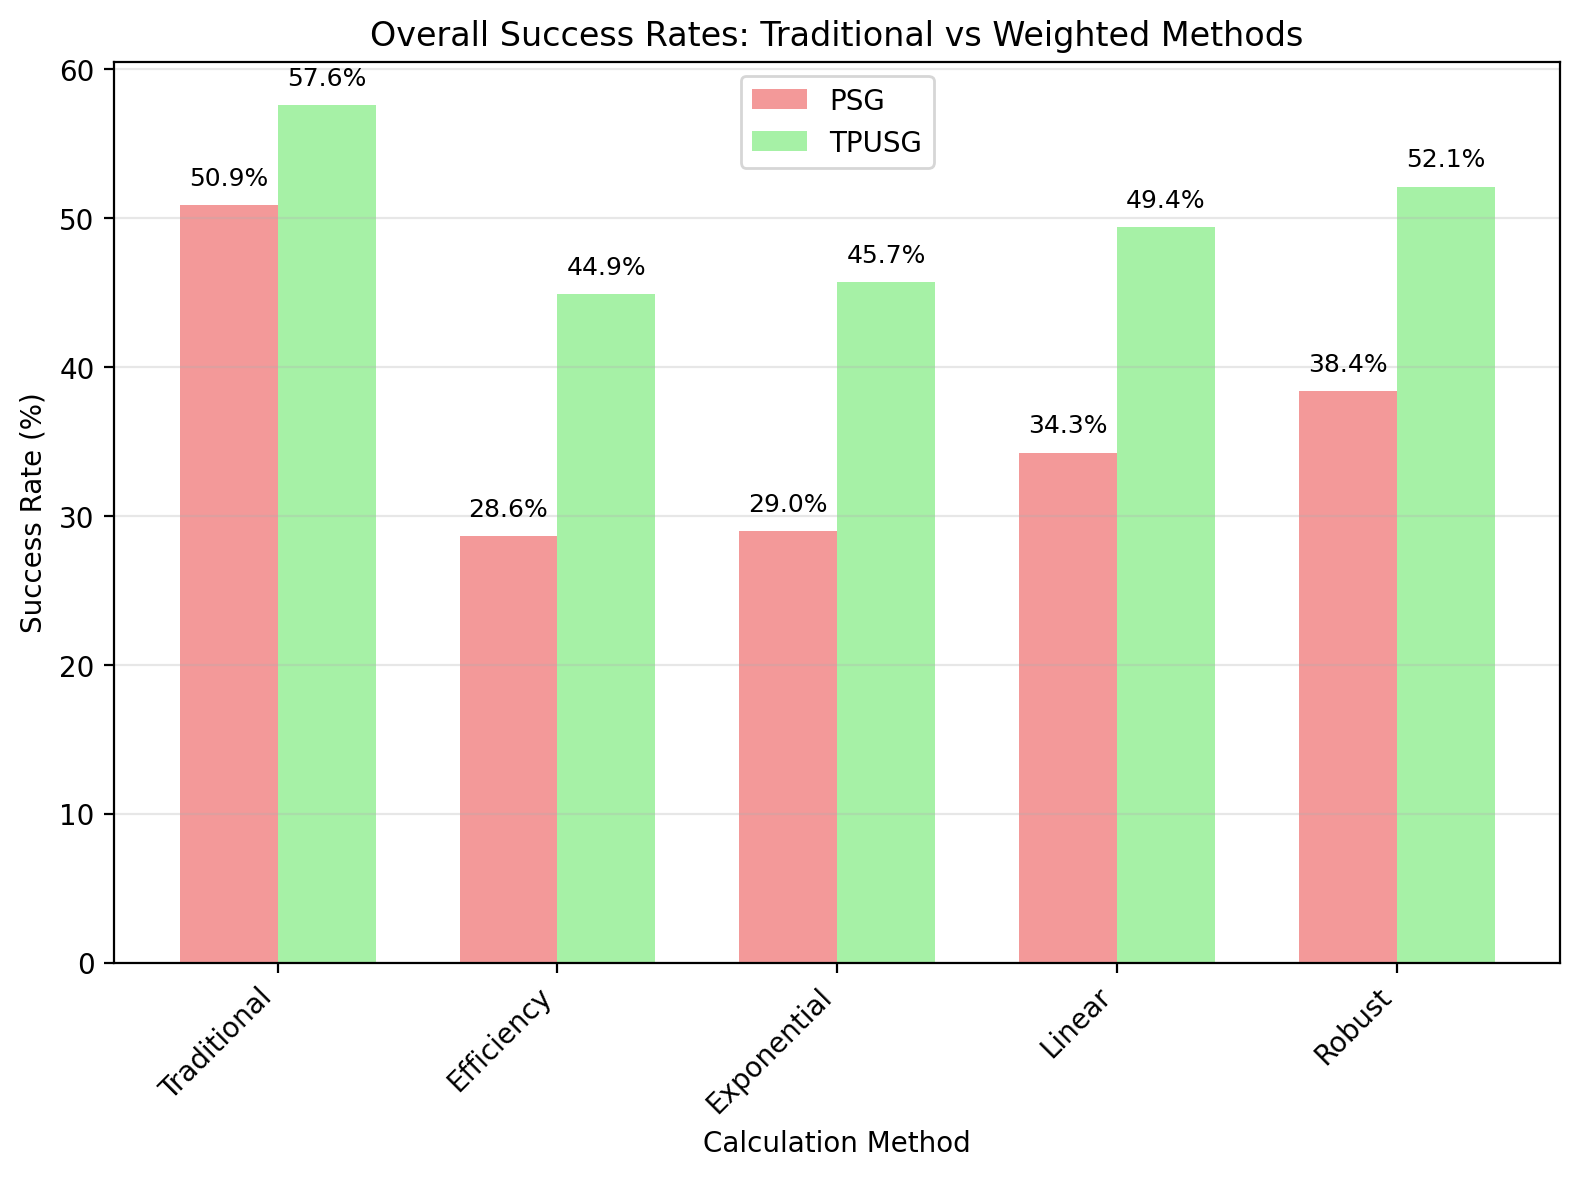

In [10]:
# <CHANGES>
fig_overall, ax_overall = plt.subplots(figsize=(8, 6))
ax_overall.bar(x - width/2, psg_rates, width, label='PSG', color='lightcoral', alpha=0.8)
ax_overall.bar(x + width/2, tpusg_rates, width, label='TPUSG', color='lightgreen', alpha=0.8)
ax_overall.set_title('Overall Success Rates: Traditional vs Weighted Methods')
ax_overall.set_xlabel('Calculation Method')
ax_overall.set_ylabel('Success Rate (%)')
ax_overall.set_xticks(x)
ax_overall.set_xticklabels(methods, rotation=45, ha='right')
ax_overall.legend()
ax_overall.grid(axis='y', alpha=0.3)
for i, (p, t) in enumerate(zip(psg_rates, tpusg_rates)):
    ax_overall.text(i - width/2, p + 1, f'{p:.1f}%', ha='center', va='bottom', fontsize=9)
    ax_overall.text(i + width/2, t + 1, f'{t:.1f}%', ha='center', va='bottom', fontsize=9)
fig_overall.tight_layout()
fig_overall.savefig('weighted_success_rate_overall.pdf', dpi=400, bbox_inches='tight')
plt.show()
plt.close(fig_overall)
# </CHANGES>

## 10. Model-Level Success Rates
> Tutorial: Use the next visual to compare PSG and TPUSG success rates for every model under parameterized and non-parameterized conditions.

This breakdown highlights where each processor excels or struggles by configuration.


📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS


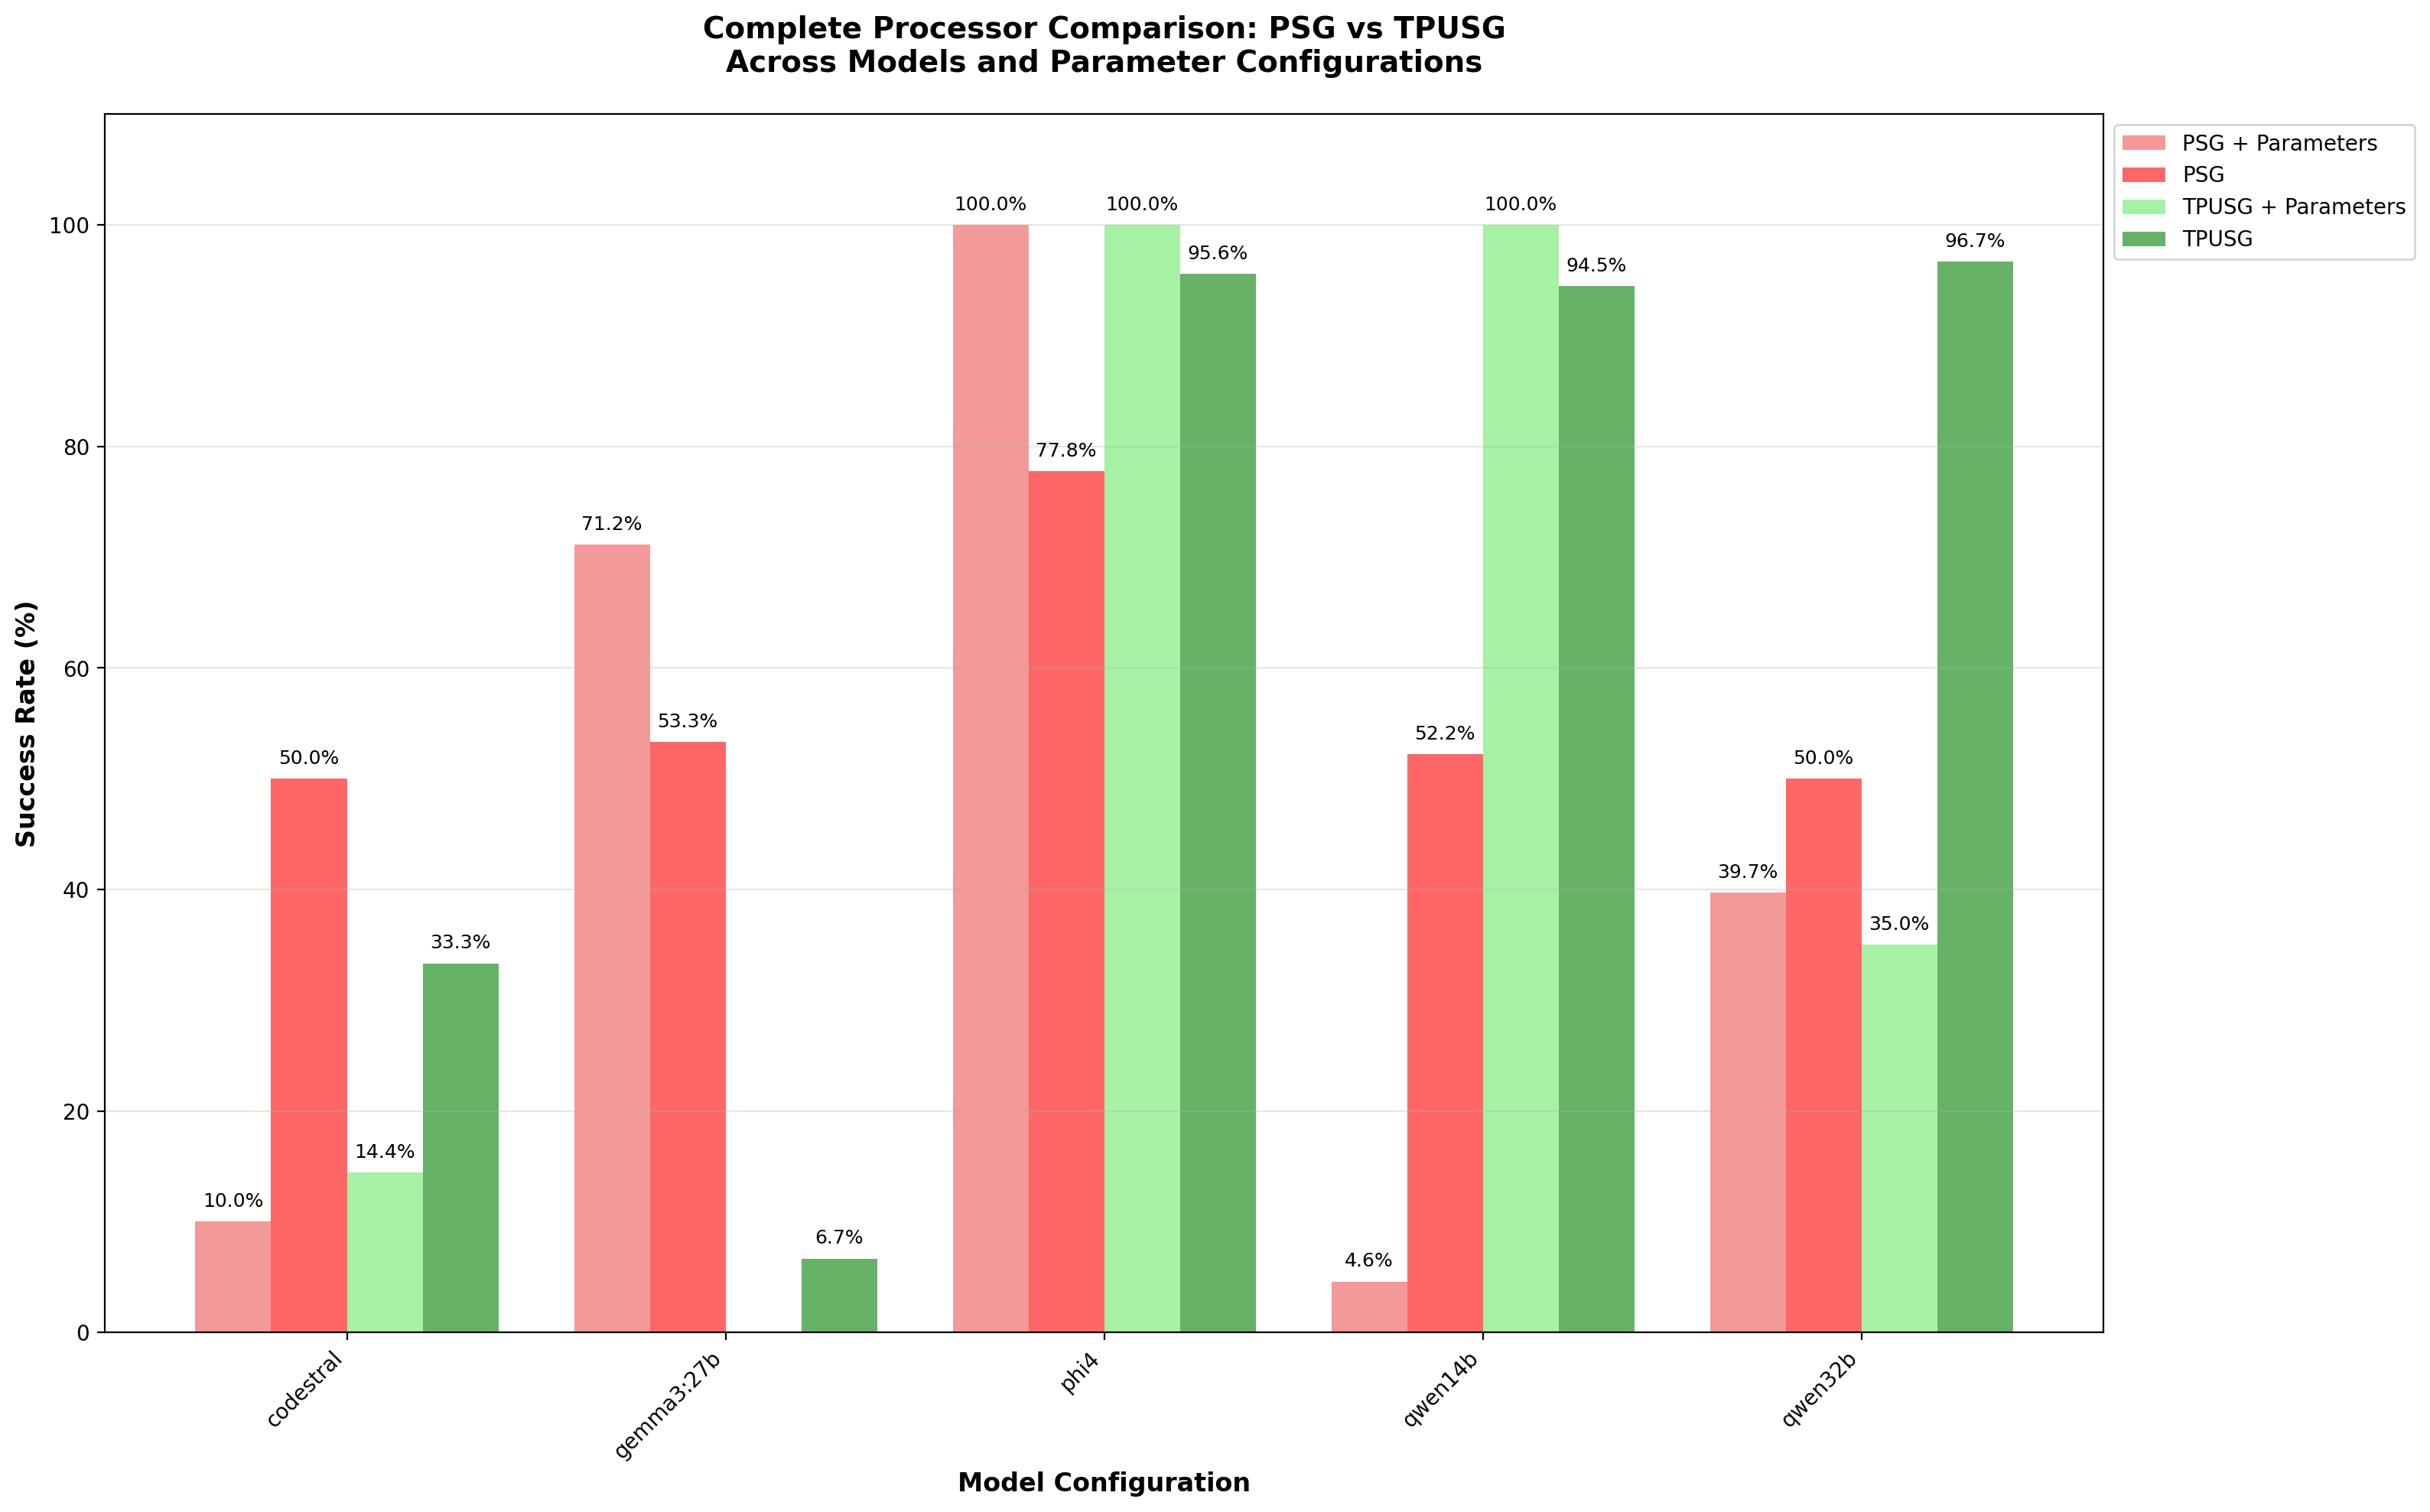


📈 SUMMARY COMPARISON TABLE:
--------------------------------------------------------------------------------
     Model PSG+Params   PSG TPUSG+Params TPUSG  Best_Config
 codestral      10.0% 50.0%        14.4% 33.3%          PSG
gemma3:27b      71.2% 53.3%         0.0%  6.7%   PSG+Params
      phi4     100.0% 77.8%       100.0% 95.6%   PSG+Params
   qwen14b       4.6% 52.2%       100.0% 94.5% TPUSG+Params
   qwen32b      39.7% 50.0%        35.0% 96.7%        TPUSG


In [11]:
# Detailed Processor Comparison Chart
print("\n📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS")
print("=" * 70)

# Create comprehensive comparison chart
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for grouped bar chart
models = sorted(comparison_df['model_config'].unique())
x = np.arange(len(models))
width = 0.2

# Get data for each combination
psg_with_data = []
psg_without_data = []
tpusg_with_data = []
tpusg_without_data = []

for model in models:
    model_data = comparison_df[comparison_df['model_config'] == model]
    
    psg_with = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == True)]['success_rate']
    psg_without = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == False)]['success_rate']
    tpusg_with = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == True)]['success_rate']
    tpusg_without = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == False)]['success_rate']
    
    psg_with_data.append(psg_with.iloc[0] if len(psg_with) > 0 else 0)
    psg_without_data.append(psg_without.iloc[0] if len(psg_without) > 0 else 0)
    tpusg_with_data.append(tpusg_with.iloc[0] if len(tpusg_with) > 0 else 0)
    tpusg_without_data.append(tpusg_without.iloc[0] if len(tpusg_without) > 0 else 0)

# Create bars
bars1 = ax.bar(x - width*1.5, psg_with_data, width, 
               label='PSG + Parameters', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x - width*0.5, psg_without_data, width, 
               label='PSG', color='red', alpha=0.6)
bars3 = ax.bar(x + width*0.5, tpusg_with_data, width, 
               label='TPUSG + Parameters', color='lightgreen', alpha=0.8)
bars4 = ax.bar(x + width*1.5, tpusg_without_data, width, 
               label='TPUSG', color='green', alpha=0.6)

# Customize chart
ax.set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Complete Processor Comparison: PSG vs TPUSG\nAcross Models and Parameter Configurations', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(max(psg_with_data), max(psg_without_data), max(tpusg_with_data), max(tpusg_without_data)) * 1.1)

# Add value labels
def add_labels(bars, data):
    for bar, value in zip(bars, data):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, value + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

add_labels(bars1, psg_with_data)
add_labels(bars2, psg_without_data)
add_labels(bars3, tpusg_with_data)
add_labels(bars4, tpusg_without_data)

plt.tight_layout()
plt.show()

# Summary comparison table
print(f"\n📈 SUMMARY COMPARISON TABLE:")
print("-" * 80)

summary_data = []
for i, model in enumerate(models):
    summary_data.append({
        'Model': model,
        'PSG+Params': f"{psg_with_data[i]:.1f}%",
        'PSG': f"{psg_without_data[i]:.1f}%",
        'TPUSG+Params': f"{tpusg_with_data[i]:.1f}%",
        'TPUSG': f"{tpusg_without_data[i]:.1f}%",
        'Best_Config': max([
            ('PSG+Params', psg_with_data[i]),
            ('PSG', psg_without_data[i]),
            ('TPUSG+Params', tpusg_with_data[i]),
            ('TPUSG', tpusg_without_data[i])
        ], key=lambda x: x[1])[0]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
 

## 11. Multi-Dimensional Comparison
> Tutorial: Execute the subsequent cells to dive into variance, statistical testing, and multi-metric perspectives beyond simple pass rates.

Combines run-level significance tests, variance visuals, and narrative summaries.

In [12]:
# Run-Level Standard Deviation & Statistical Analysis - PSG vs TPUSG
print("\n📊 RUN-LEVEL STANDARD DEVIATION & STATISTICAL ANALYSIS")
print("=" * 80)

# Import statistical libraries
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, levene, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Load and prepare dataset
csv_path = os.path.join(os.getcwd(), "combined_tinyml_benchmark_data.csv")
df = read_csv_filtered(csv_path)

print(f"Dataset loaded successfully! Shape: {df.shape}")

# Clean and prepare data
df.drop(columns=['source_file','trace_id', 'source_path','prompt_cost', 'completion_cost','total_cost'], inplace=True, errors='ignore')
df['model_config'] = df['model_config'].apply(model_config_trim)
df['parameters'] = df['parameters'].apply(lambda x: False if pd.isna(x) else len(str(x)) > 0)
df['batch_id'] = df['batch_id'].str.replace("qwen2.5-coder:", "qwen").str.replace("_batch", "")

# Filter data from July onwards using trustable timestamp
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
july_cutoff = pd.to_datetime('2025-07-01')
df = df[df['datetime'] >= july_cutoff]
df['processor'] = df['batch_id'].map(extract_processor)

# Filter to PSG and TPUSG only
df = df[df['processor'].isin(['psg', 'tpusg'])]

print(f"Cleaned dataset shape: {df.shape}")
print(f"Processor distribution: {df['processor'].value_counts().to_dict()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")


# Create binary success indicator and analyze data structure
df['success_binary'] = (df['status'] == 'success').astype(int)

# Basic dataset statistics per processor
print(f"\n📊 RUN-LEVEL DATASET STATISTICS:")
print("-" * 50)

for processor in ['psg', 'tpusg']:
    proc_data = df[df['processor'] == processor]
    
    print(f"\n{processor.upper()} Processor:")
    print(f"  Total runs: {len(proc_data)}")
    print(f"  Unique batches: {proc_data['batch_id'].nunique()}")
    print(f"  Avg runs per batch: {len(proc_data) / proc_data['batch_id'].nunique():.1f}")
    print(f"  Success rate: {proc_data['success_binary'].mean() * 100:.1f}%")
    print(f"  Successful runs: {proc_data['success_binary'].sum()}")
    print(f"  Failed runs: {len(proc_data) - proc_data['success_binary'].sum()}")
    
    # Generation count analysis
    if 'generation_count' in proc_data.columns:
        print(f"  Avg generation count: {proc_data['generation_count'].mean():.2f}")
        print(f"  Generation count range: [{proc_data['generation_count'].min()}, {proc_data['generation_count'].max()}]")
        
        # Success vs generation count relationship
        successful_runs = proc_data[proc_data['success_binary'] == 1]
        if len(successful_runs) > 0:
            print(f"  Avg generations for success: {successful_runs['generation_count'].mean():.2f}")

            first_attempt_successes = successful_runs[successful_runs['generation_count'] == 1]
            first_attempt_run_rate = len(first_attempt_successes) / len(proc_data) * 100 if len(proc_data) > 0 else 0
            first_attempt_success_share = len(first_attempt_successes) / len(successful_runs) * 100
            print(f"  First-attempt successes: {len(first_attempt_successes)} "
                  f"({first_attempt_run_rate:.1f}% of runs, {first_attempt_success_share:.1f}% of successes)")
# =============================================================================
# 2. RUN-LEVEL METRICS CALCULATION
# =============================================================================
print("\n📈 2. RUN-LEVEL METRICS CALCULATION")
print("=" * 60)

def calculate_comprehensive_run_stats(data, metric_col, metric_name, is_binary=False):
    """Calculate comprehensive statistics for a metric at individual run level"""
    
    if metric_col not in data.columns:
        return {'error': f'Column {metric_col} not found'}
    
    clean_data = data[metric_col].dropna()
    
    if len(clean_data) == 0:
        return {'error': 'No valid data after cleaning'}
    
    # Basic descriptive statistics
    stats_dict = {
        'n_runs': len(clean_data),
        'mean': clean_data.mean(),
        'std': clean_data.std(),
        'variance': clean_data.var(),
        'median': clean_data.median(),
        'q25': clean_data.quantile(0.25),
        'q75': clean_data.quantile(0.75),
        'min': clean_data.min(),
        'max': clean_data.max(),
        'range': clean_data.max() - clean_data.min(),
        'iqr': clean_data.quantile(0.75) - clean_data.quantile(0.25)
    }
    
    # Coefficient of variation (relative variability)
    if stats_dict['mean'] != 0:
        stats_dict['cv'] = stats_dict['std'] / stats_dict['mean']
    else:
        stats_dict['cv'] = np.inf
    
    # Distribution shape statistics
    try:
        stats_dict['skewness'] = stats.skew(clean_data)
        stats_dict['kurtosis'] = stats.kurtosis(clean_data)
    except:
        stats_dict['skewness'] = np.nan
        stats_dict['kurtosis'] = np.nan
    
    # Standard error of the mean
    stats_dict['sem'] = stats_dict['std'] / np.sqrt(len(clean_data))
    
    # 95% confidence interval for mean
    stats_dict['ci_95_lower'] = stats_dict['mean'] - 1.96 * stats_dict['sem']
    stats_dict['ci_95_upper'] = stats_dict['mean'] + 1.96 * stats_dict['sem']
    
    # Normality test (if sufficient sample size)
    if len(clean_data) >= 8:
        try:
            jb_stat, jb_p = jarque_bera(clean_data)
            stats_dict['normality_test'] = {
                'jarque_bera_stat': jb_stat,
                'jarque_bera_p': jb_p,
                'is_normal': jb_p > 0.05
            }
        except:
            stats_dict['normality_test'] = {'error': 'Normality test failed'}
    else:
        stats_dict['normality_test'] = {'error': 'Insufficient sample size for normality test'}
    
    # For binary data, add specific metrics
    if is_binary:
        success_rate = stats_dict['mean']
        n = len(clean_data)
        # Standard error for proportion
        stats_dict['proportion_se'] = np.sqrt(success_rate * (1 - success_rate) / n)
        # 95% CI for proportion
        stats_dict['proportion_ci_95_lower'] = max(0, success_rate - 1.96 * stats_dict['proportion_se'])
        stats_dict['proportion_ci_95_upper'] = min(1, success_rate + 1.96 * stats_dict['proportion_se'])
    
    return stats_dict

# Define metrics to analyze at run level
run_level_metrics = [
    ('success_binary', 'Success Rate (Run Level)', True),
    ('generation_count', 'Generation Count (Attempts per Run)', False),
    ('total_tokens', 'Total Tokens per Run', False),
    ('latency', 'Latency per Run (seconds)', False),
]

# Calculate comprehensive statistics for each processor
run_statistics = {}

print("📊 COMPREHENSIVE RUN-LEVEL STATISTICS:")
print("=" * 70)

for metric_col, metric_name, is_binary in run_level_metrics:
    print(f"\n{metric_name}:")
    print("-" * 60)
    
    for processor in ['psg', 'tpusg']:
        proc_data = df[df['processor'] == processor]
        stats_result = calculate_comprehensive_run_stats(proc_data, metric_col, metric_name, is_binary)
        
        run_statistics[f'{processor}_{metric_col}'] = stats_result
        
        if 'error' not in stats_result:
            if is_binary:
                # Display as percentages for binary metrics
                mean_pct = stats_result['mean'] * 100
                std_pct = stats_result['std'] * 100
                ci_lower_pct = stats_result['proportion_ci_95_lower'] * 100
                ci_upper_pct = stats_result['proportion_ci_95_upper'] * 100
                
                print(f"  {processor.upper()}: {mean_pct:.1f}% ± {std_pct:.1f}% "
                      f"(n={stats_result['n_runs']} runs)")
                print(f"    95% CI: [{ci_lower_pct:.1f}%, {ci_upper_pct:.1f}%]")
                print(f"    CV: {stats_result['cv']:.3f}")
            else:
                print(f"  {processor.upper()}: {stats_result['mean']:.3f} ± {stats_result['std']:.3f} "
                      f"(n={stats_result['n_runs']} runs)")
                print(f"    95% CI: [{stats_result['ci_95_lower']:.3f}, {stats_result['ci_95_upper']:.3f}]")
                print(f"    Range: [{stats_result['min']:.3f}, {stats_result['max']:.3f}]")
                print(f"    Median (IQR): {stats_result['median']:.3f} "
                      f"[{stats_result['q25']:.3f}, {stats_result['q75']:.3f}]")
                print(f"    CV: {stats_result['cv']:.3f}")
        else:
            print(f"  {processor.upper()}: {stats_result['error']}")

# =============================================================================
# 3. STATISTICAL SIGNIFICANCE TESTING
# =============================================================================
print("\n🔬 3. STATISTICAL SIGNIFICANCE TESTING (RUN LEVEL)")
print("=" * 60)

def perform_comprehensive_statistical_tests(psg_data, tpusg_data, metric_name, is_binary=False):
    """Perform comprehensive statistical tests between PSG and TPUSG at run level"""
    
    # Clean data
    psg_clean = psg_data.dropna()
    tpusg_clean = tpusg_data.dropna()
    
    if len(psg_clean) == 0 or len(tpusg_clean) == 0:
        return {"error": "Insufficient data for statistical testing"}
    
    results = {
        'sample_sizes': {'psg': len(psg_clean), 'tpusg': len(tpusg_clean)},
        'descriptive_stats': {
            'psg_mean': psg_clean.mean(),
            'tpusg_mean': tpusg_clean.mean(),
            'psg_std': psg_clean.std(),
            'tpusg_std': tpusg_clean.std(),
            'psg_cv': psg_clean.std() / psg_clean.mean() if psg_clean.mean() != 0 else np.inf,
            'tpusg_cv': tpusg_clean.std() / tpusg_clean.mean() if tpusg_clean.mean() != 0 else np.inf,
            'difference': tpusg_clean.mean() - psg_clean.mean()
        }
    }
    
    if is_binary:
        # For binary success/failure data
        psg_successes = int(psg_clean.sum())
        tpusg_successes = int(tpusg_clean.sum())
        psg_total = len(psg_clean)
        tpusg_total = len(tpusg_clean)
        
        # Chi-square test for independence
        try:
            contingency_table = np.array([
                [psg_successes, psg_total - psg_successes],
                [tpusg_successes, tpusg_total - tpusg_successes]
            ])
            
            chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)
            results['chi_square_test'] = {
                'statistic': chi2_stat,
                'p_value': chi2_p,
                'significant': chi2_p < 0.05,
                'contingency_table': contingency_table.tolist()
            }
        except Exception as e:
            results['chi_square_test'] = {"error": f"Chi-square test failed: {str(e)}"}
        
        # Effect size for proportions (Cohen's h)
        try:
            p1 = psg_successes / psg_total
            p2 = tpusg_successes / tpusg_total
            
            if p1 == 0 or p1 == 1 or p2 == 0 or p2 == 1:
                # Use small adjustment for extreme proportions
                p1_adj = (psg_successes + 0.5) / (psg_total + 1)
                p2_adj = (tpusg_successes + 0.5) / (tpusg_total + 1)
                cohens_h = 2 * (np.arcsin(np.sqrt(p2_adj)) - np.arcsin(np.sqrt(p1_adj)))
            else:
                cohens_h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))
            
            magnitude = 'small' if abs(cohens_h) < 0.2 else 'medium' if abs(cohens_h) < 0.5 else 'large'
            
            results['effect_size'] = {
                'cohens_h': cohens_h,
                'magnitude': magnitude,
                'interpretation': f"TPUSG {'outperforms' if cohens_h > 0 else 'underperforms'} PSG"
            }
        except Exception as e:
            results['effect_size'] = {"error": f"Effect size calculation failed: {str(e)}"}
    
    else:
        # For continuous data
        
        # 1. Normality tests for both groups
        try:
            if len(psg_clean) >= 8:
                psg_jb_stat, psg_jb_p = jarque_bera(psg_clean)
                psg_normal = psg_jb_p > 0.05
            else:
                psg_jb_stat, psg_jb_p, psg_normal = np.nan, np.nan, False
                
            if len(tpusg_clean) >= 8:
                tpusg_jb_stat, tpusg_jb_p = jarque_bera(tpusg_clean)
                tpusg_normal = tpusg_jb_p > 0.05
            else:
                tpusg_jb_stat, tpusg_jb_p, tpusg_normal = np.nan, np.nan, False
                
            results['normality_tests'] = {
                'psg_jarque_bera': {'statistic': psg_jb_stat, 'p_value': psg_jb_p, 'normal': psg_normal},
                'tpusg_jarque_bera': {'statistic': tpusg_jb_stat, 'p_value': tpusg_jb_p, 'normal': tpusg_normal},
                'both_normal': psg_normal and tpusg_normal
            }
        except Exception as e:
            results['normality_tests'] = {"error": f"Normality tests failed: {str(e)}"}
        
        # 2. Levene's test for equal variances
        try:
            levene_stat, levene_p = levene(psg_clean, tpusg_clean)
            equal_variances = levene_p >= 0.05
            
            results['levene_test'] = {
                'statistic': levene_stat,
                'p_value': levene_p,
                'equal_variances': equal_variances
            }
        except Exception as e:
            results['levene_test'] = {"error": f"Levene test failed: {str(e)}"}
        
        # 3. Independent t-test (parametric)
        try:
            equal_var = results.get('levene_test', {}).get('equal_variances', True)
            t_stat, t_p = ttest_ind(psg_clean, tpusg_clean, equal_var=equal_var)
            
            results['t_test'] = {
                'statistic': t_stat,
                'p_value': t_p,
                'significant': t_p < 0.05,
                'equal_var_assumed': equal_var,
                'interpretation': f"TPUSG {'significantly higher' if t_stat < 0 and t_p < 0.05 else 'significantly lower' if t_stat > 0 and t_p < 0.05 else 'not significantly different'}"
            }
        except Exception as e:
            results['t_test'] = {"error": f"T-test failed: {str(e)}"}
        
        # 4. Mann-Whitney U test (non-parametric)
        try:
            u_stat, u_p = mannwhitneyu(psg_clean, tpusg_clean, alternative='two-sided')
            
            results['mann_whitney_test'] = {
                'statistic': u_stat,
                'p_value': u_p,
                'significant': u_p < 0.05,
                'interpretation': f"Distributions {'significantly different' if u_p < 0.05 else 'not significantly different'}"
            }
        except Exception as e:
            results['mann_whitney_test'] = {"error": f"Mann-Whitney test failed: {str(e)}"}
        
        # 5. Effect size (Cohen's d)
        try:
            # Pooled standard deviation
            n1, n2 = len(psg_clean), len(tpusg_clean)
            pooled_std = np.sqrt(((n1 - 1) * np.var(psg_clean, ddof=1) + 
                                 (n2 - 1) * np.var(tpusg_clean, ddof=1)) / 
                                (n1 + n2 - 2))
            
            cohens_d = (tpusg_clean.mean() - psg_clean.mean()) / pooled_std
            
            magnitude = ('small' if abs(cohens_d) < 0.2 else 
                        'medium' if abs(cohens_d) < 0.5 else 
                        'large')
            
            results['effect_size'] = {
                'cohens_d': cohens_d,
                'magnitude': magnitude,
                'interpretation': f"TPUSG {'outperforms' if cohens_d > 0 else 'underperforms'} PSG by {magnitude} effect"
            }
        except Exception as e:
            results['effect_size'] = {"error": f"Effect size calculation failed: {str(e)}"}
    
    return results

# Perform statistical tests for each metric
statistical_results = {}

print("🔬 STATISTICAL TEST RESULTS:")
print("=" * 70)

for metric_col, metric_name, is_binary in run_level_metrics:
    print(f"\n{metric_name}:")
    print("-" * 60)
    
    psg_data = df[df['processor'] == 'psg'][metric_col]
    tpusg_data = df[df['processor'] == 'tpusg'][metric_col]
    
    test_results = perform_comprehensive_statistical_tests(psg_data, tpusg_data, metric_name, is_binary)
    statistical_results[metric_col] = test_results
    
    if 'error' not in test_results:
        # Sample sizes
        print(f"  Sample sizes: PSG={test_results['sample_sizes']['psg']}, "
              f"TPUSG={test_results['sample_sizes']['tpusg']}")
        
        # Descriptive statistics
        desc = test_results['descriptive_stats']
        if is_binary:
            print(f"  PSG: {desc['psg_mean']*100:.1f}% ± {desc['psg_std']*100:.1f}% (CV: {desc['psg_cv']:.3f})")
            print(f"  TPUSG: {desc['tpusg_mean']*100:.1f}% ± {desc['tpusg_std']*100:.1f}% (CV: {desc['tpusg_cv']:.3f})")
            print(f"  Difference: {desc['difference']*100:+.1f}% (TPUSG - PSG)")
        else:
            print(f"  PSG: {desc['psg_mean']:.3f} ± {desc['psg_std']:.3f} (CV: {desc['psg_cv']:.3f})")
            print(f"  TPUSG: {desc['tpusg_mean']:.3f} ± {desc['tpusg_std']:.3f} (CV: {desc['tpusg_cv']:.3f})")
            print(f"  Difference: {desc['difference']:+.3f} (TPUSG - PSG)")
        
        # Statistical tests
        if is_binary and 'chi_square_test' in test_results:
            chi = test_results['chi_square_test']
            if 'error' not in chi:
                print(f"  Chi-square: χ²={chi['statistic']:.3f}, p={chi['p_value']:.4f}, "
                      f"Significant: {'Yes' if chi['significant'] else 'No'}")
        
        if not is_binary:
            if 'mann_whitney_test' in test_results:
                mw = test_results['mann_whitney_test']
                if 'error' not in mw:
                    print(f"  Mann-Whitney U: U={mw['statistic']:.0f}, p={mw['p_value']:.4f}, "
                          f"Significant: {'Yes' if mw['significant'] else 'No'}")
            
            if 't_test' in test_results:
                tt = test_results['t_test']
                if 'error' not in tt:
                    print(f"  T-test: t={tt['statistic']:.3f}, p={tt['p_value']:.4f}, "
                          f"Significant: {'Yes' if tt['significant'] else 'No'}")
        
        # Effect size
        if 'effect_size' in test_results:
            es = test_results['effect_size']
            if 'error' not in es:
                if is_binary:
                    print(f"  Effect size (Cohen's h): {es['cohens_h']:.3f} ({es['magnitude']})")
                else:
                    print(f"  Effect size (Cohen's d): {es['cohens_d']:.3f} ({es['magnitude']})")
                print(f"  Interpretation: {es['interpretation']}")
    else:
        print(f"  Error: {test_results['error']}")



📊 RUN-LEVEL STANDARD DEVIATION & STATISTICAL ANALYSIS
Dataset loaded successfully! Shape: (1954, 20)
Cleaned dataset shape: (1654, 16)
Processor distribution: {'tpusg': 827, 'psg': 827}
Date range: 2025-07-29 11:00:38 to 2025-08-20 14:52:35

📊 RUN-LEVEL DATASET STATISTICS:
--------------------------------------------------

PSG Processor:
  Total runs: 827
  Unique batches: 27
  Avg runs per batch: 30.6
  Success rate: 49.5%
  Successful runs: 409
  Failed runs: 418
  Avg generation count: 3.82
  Generation count range: [1, 5]
  Avg generations for success: 2.62
  First-attempt successes: 150 (18.1% of runs, 36.7% of successes)

TPUSG Processor:
  Total runs: 827
  Unique batches: 30
  Avg runs per batch: 27.6
  Success rate: 64.6%
  Successful runs: 534
  Failed runs: 293
  Avg generation count: 2.87
  Generation count range: [1, 5]
  Avg generations for success: 1.72
  First-attempt successes: 346 (41.8% of runs, 64.8% of successes)

📈 2. RUN-LEVEL METRICS CALCULATION
📊 COMPREHENSIV


📈 4. RUN-LEVEL VARIANCE ANALYSIS VISUALIZATION
STATISTICAL SUMMARY (RUN LEVEL):
--------------------------------
Significant Differences (p < 0.05):

✓ Success Binary: Chi-square p=0.0000 (Cohen's h: 0.307, medium)
✓ Generation Count: Mann-Whitney p=0.0000 (Cohen's d: -0.552, large)
✗ Total Tokens: Mann-Whitney p=0.0813 (Cohen's d: -0.378, medium)
✗ Latency: Mann-Whitney p=0.0538 (Cohen's d: -0.001, small)

Sample Sizes:
Total runs: 1654
PSG runs: 827 (50.0%)
TPUSG runs: 827 (50.0%)
Unique batches: 57


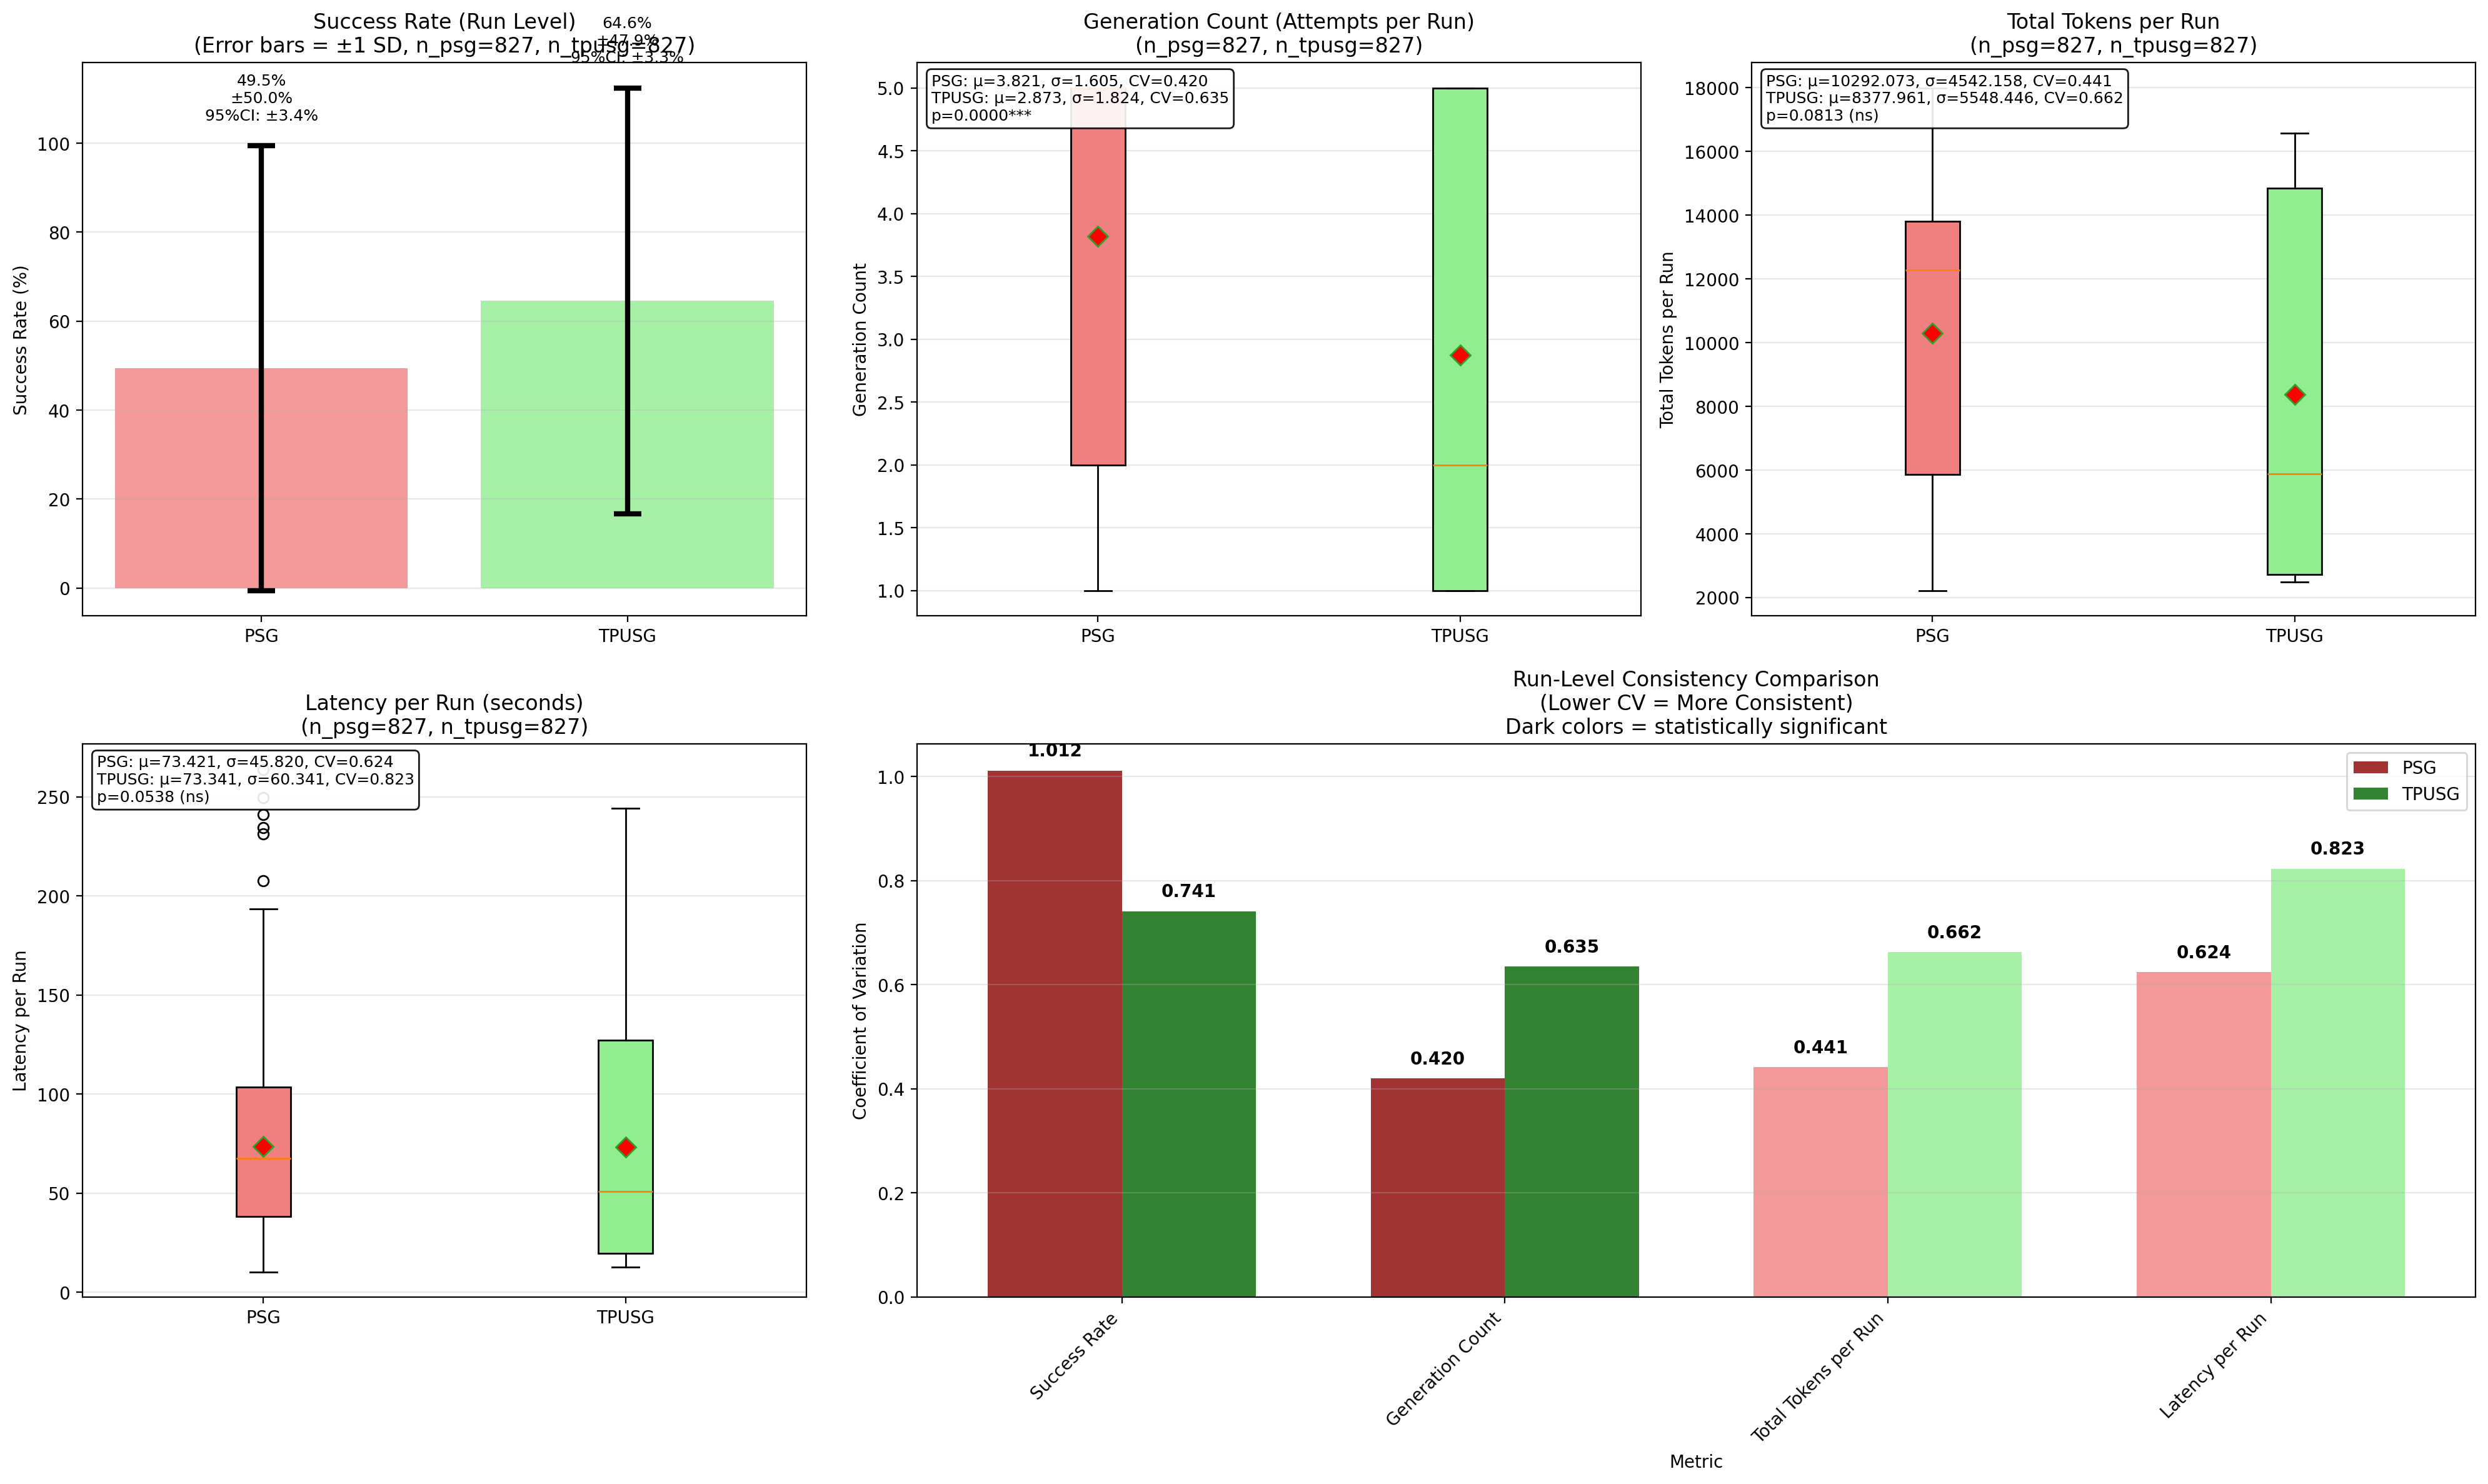

In [13]:

# =============================================================================
# 4. VARIANCE ANALYSIS VISUALIZATION
# =============================================================================
print("\n📈 4. RUN-LEVEL VARIANCE ANALYSIS VISUALIZATION")
print("=" * 60)

# Create comprehensive variance visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)
metric_axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0])
]
cv_ax = fig.add_subplot(gs[1, 1:])
# axes = axes.flatten()

# Get processor data
psg_runs = df[df['processor'] == 'psg']
tpusg_runs = df[df['processor'] == 'tpusg']

for i, (metric_col, metric_name, is_binary) in enumerate(run_level_metrics):
    ax = metric_axes[i]
    
    psg_metric = psg_runs[metric_col].dropna()
    tpusg_metric = tpusg_runs[metric_col].dropna()
    
    if len(psg_metric) > 0 and len(tpusg_metric) > 0:
        if is_binary:
            # Bar plot with error bars for binary metrics
            psg_rate = psg_metric.mean() * 100
            tpusg_rate = tpusg_metric.mean() * 100
            psg_std = psg_metric.std() * 100
            tpusg_std = tpusg_metric.std() * 100
            
            bars = ax.bar(['PSG', 'TPUSG'], [psg_rate, tpusg_rate], 
                         yerr=[psg_std, tpusg_std], capsize=8,
                         color=['lightcoral', 'lightgreen'], alpha=0.8,
                         error_kw={'linewidth': 3, 'capthick': 3})
            
            ax.set_ylabel('Success Rate (%)')
            ax.set_title(f'{metric_name}\n(Error bars = ±1 SD, n_psg={len(psg_metric)}, n_tpusg={len(tpusg_metric)})')
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels with confidence intervals
            for j, (bar, value, std) in enumerate(zip(bars, [psg_rate, tpusg_rate], [psg_std, tpusg_std])):
                processor = ['PSG', 'TPUSG'][j]
                n_runs = len(psg_metric) if j == 0 else len(tpusg_metric)
                se = std / np.sqrt(n_runs)  # Standard error
                ci_margin = 1.96 * se  # 95% CI margin
                
                ax.text(bar.get_x() + bar.get_width()/2, value + std + 5,
                       f'{value:.1f}%\n±{std:.1f}%\n95%CI: ±{ci_margin:.1f}%', 
                       ha='center', va='bottom', fontsize=9)
                       
        else:
            # Enhanced box plot for continuous metrics
            box_data = [psg_metric, tpusg_metric]
            bp = ax.boxplot(box_data, labels=['PSG', 'TPUSG'], patch_artist=True,
                           showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markersize': 8})
            
            bp['boxes'][0].set_facecolor('lightcoral')
            bp['boxes'][1].set_facecolor('lightgreen')
            
            ax.set_ylabel(metric_name.split('(')[0].strip())
            ax.set_title(f'{metric_name}\n(n_psg={len(psg_metric)}, n_tpusg={len(tpusg_metric)})')
            ax.grid(axis='y', alpha=0.3)
            
            # Add detailed statistics text
            psg_cv = psg_metric.std() / psg_metric.mean() if psg_metric.mean() != 0 else np.inf
            tpusg_cv = tpusg_metric.std() / tpusg_metric.mean() if tpusg_metric.mean() != 0 else np.inf
            
            stats_text = f'PSG: μ={psg_metric.mean():.3f}, σ={psg_metric.std():.3f}, CV={psg_cv:.3f}\n'
            stats_text += f'TPUSG: μ={tpusg_metric.mean():.3f}, σ={tpusg_metric.std():.3f}, CV={tpusg_cv:.3f}'
            
            # Add significance indicator if available
            if metric_col in statistical_results:
                result = statistical_results[metric_col]
                if 'mann_whitney_test' in result and 'error' not in result['mann_whitney_test']:
                    p_val = result['mann_whitney_test']['p_value']
                    sig_text = f"p={p_val:.4f}" + ("***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else " (ns)")
                    stats_text += f'\n{sig_text}'
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), fontsize=9)
    else:
        ax.text(0.5, 0.5, f'Insufficient data\nfor {metric_name}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(metric_name)

# Coefficient of Variation comparison chart
ax = cv_ax
cv_metrics = []
cv_psg = []
cv_tpusg = []
cv_significance = []

for metric_col, metric_name, is_binary in run_level_metrics:
    psg_metric = psg_runs[metric_col].dropna()
    tpusg_metric = tpusg_runs[metric_col].dropna()
    
    if len(psg_metric) > 0 and len(tpusg_metric) > 0:
        psg_cv = psg_metric.std() / psg_metric.mean() if psg_metric.mean() != 0 else np.inf
        tpusg_cv = tpusg_metric.std() / tpusg_metric.mean() if tpusg_metric.mean() != 0 else np.inf
        
        if not np.isinf(psg_cv) and not np.isinf(tpusg_cv):
            cv_metrics.append(metric_name.split('(')[0].strip())
            cv_psg.append(psg_cv)
            cv_tpusg.append(tpusg_cv)
            
            # Add significance indicator
            if metric_col in statistical_results:
                result = statistical_results[metric_col]
                if is_binary and 'chi_square_test' in result:
                    p_val = result['chi_square_test'].get('p_value', 1)
                elif 'mann_whitney_test' in result:
                    p_val = result['mann_whitney_test'].get('p_value', 1)
                else:
                    p_val = 1
                cv_significance.append(p_val < 0.05)
            else:
                cv_significance.append(False)

if cv_metrics:
    x = np.arange(len(cv_metrics))
    width = 0.35
    
    # Color bars based on significance
    psg_colors = ['darkred' if sig else 'lightcoral' for sig in cv_significance]
    tpusg_colors = ['darkgreen' if sig else 'lightgreen' for sig in cv_significance]
    
    bars1 = ax.bar(x - width/2, cv_psg, width, label='PSG', color=psg_colors, alpha=0.8)
    bars2 = ax.bar(x + width/2, cv_tpusg, width, label='TPUSG', color=tpusg_colors, alpha=0.8)
    
    ax.set_xlabel('Metric')
    ax.set_ylabel('Coefficient of Variation')
    ax.set_title('Run-Level Consistency Comparison\n(Lower CV = More Consistent)\nDark colors = statistically significant')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_metrics, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (p, t) in enumerate(zip(cv_psg, cv_tpusg)):
        ax.text(i - width/2, p + max(max(cv_psg), max(cv_tpusg)) * 0.02, 
               f'{p:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(i + width/2, t + max(max(cv_psg), max(cv_tpusg)) * 0.02, 
               f'{t:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Statistical summary panel
# ax = axes[5]
# ax.axis('off')
# ax.text(0.5, 0.95, 'Statistical Summary (Run Level)', ha='center', va='top', 
        # fontsize=16, fontweight='bold', transform=ax.transAxes)

# Collect significant results and effect sizes
summary_text = "Significant Differences (p < 0.05):\n\n"
for metric_col, results in statistical_results.items():
    if 'error' not in results:
        metric_display = metric_col.replace('_', ' ').title()
        
        # Check for significance
        significant = False
        test_used = ""
        p_val = 1.0
        
        if metric_col == 'success_binary' and 'chi_square_test' in results:
            chi_result = results['chi_square_test']
            if 'error' not in chi_result:
                significant = chi_result['significant']
                test_used = "Chi-square"
                p_val = chi_result['p_value']
        elif 'mann_whitney_test' in results:
            mw_result = results['mann_whitney_test']
            if 'error' not in mw_result:
                significant = mw_result['significant']
                test_used = "Mann-Whitney"
                p_val = mw_result['p_value']
        
        # Effect size
        effect_info = ""
        if 'effect_size' in results and 'error' not in results['effect_size']:
            es = results['effect_size']
            if 'cohens_h' in es:
                effect_info = f" (Cohen's h: {es['cohens_h']:.3f}, {es['magnitude']})"
            elif 'cohens_d' in es:
                effect_info = f" (Cohen's d: {es['cohens_d']:.3f}, {es['magnitude']})"
        
        status = "✓" if significant else "✗"
        summary_text += f"{status} {metric_display}: {test_used} p={p_val:.4f}{effect_info}\n"

# Add sample size information
total_runs = len(df)
psg_runs_count = len(psg_runs)
tpusg_runs_count = len(tpusg_runs)

summary_text += f"\nSample Sizes:\n"
summary_text += f"Total runs: {total_runs}\n"
summary_text += f"PSG runs: {psg_runs_count} ({psg_runs_count/total_runs*100:.1f}%)\n"
summary_text += f"TPUSG runs: {tpusg_runs_count} ({tpusg_runs_count/total_runs*100:.1f}%)\n"
summary_text += f"Unique batches: {df['batch_id'].nunique()}"


print("Statistical Summary (Run Level):".upper())
print("--------------------------------")
print(summary_text)
# ax.text(0.05, 0.85, summary_text, ha='left', va='top', fontsize=11, transform=ax.transAxes, 
#         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.9), family='monospace')

plt.tight_layout()

# savedf 
plt.savefig("run_level_variance_analysis.pdf", dpi=400,bbox_inches='tight')
plt.show()


In [14]:

# =============================================================================
# 5. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n📋 5. COMPREHENSIVE RUN-LEVEL ANALYSIS SUMMARY")
print("=" * 70)

print("🎯 RUN-LEVEL PERFORMANCE SUMMARY:")
print("-" * 50)

print(f"Dataset Overview:")
print(f"  Total runs analyzed: {len(df)}")
print(f"  Unique batches: {df['batch_id'].nunique()}")
print(f"  Average runs per batch: {len(df) / df['batch_id'].nunique():.1f}")
print(f"  Date range: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}")

# Key findings
psg_success_rate = psg_runs['success_binary'].mean() * 100
tpusg_success_rate = tpusg_runs['success_binary'].mean() * 100
success_difference = tpusg_success_rate - psg_success_rate

print(f"\n📊 KEY FINDINGS:")
print("-" * 30)
print(f"Success Rates (Run Level):")
print(f"  PSG: {psg_success_rate:.1f}% ({psg_runs['success_binary'].sum()}/{len(psg_runs)} runs)")
print(f"  TPUSG: {tpusg_success_rate:.1f}% ({tpusg_runs['success_binary'].sum()}/{len(tpusg_runs)} runs)")
print(f"  Difference: {success_difference:+.1f}% (TPUSG - PSG)")

# Generation efficiency
psg_gen_mean = psg_runs['generation_count'].mean()
tpusg_gen_mean = tpusg_runs['generation_count'].mean()
print(f"\nGeneration Efficiency (Attempts per Run):")
print(f"  PSG: {psg_gen_mean:.2f} ± {psg_runs['generation_count'].std():.2f}")
print(f"  TPUSG: {tpusg_gen_mean:.2f} ± {tpusg_runs['generation_count'].std():.2f}")
print(f"  More Efficient: {'PSG' if psg_gen_mean < tpusg_gen_mean else 'TPUSG'}")

# Consistency comparison
print(f"\n📊 CONSISTENCY COMPARISON (CV):")
print("-" * 40)
for metric_col, metric_name, is_binary in run_level_metrics:
    if metric_col in df.columns:
        psg_metric = psg_runs[metric_col].dropna()
        tpusg_metric = tpusg_runs[metric_col].dropna()
        
        if len(psg_metric) > 0 and len(tpusg_metric) > 0:
            psg_cv = psg_metric.std() / psg_metric.mean() if psg_metric.mean() != 0 else np.inf
            tpusg_cv = tpusg_metric.std() / tpusg_metric.mean() if tpusg_metric.mean() != 0 else np.inf
            
            if not np.isinf(psg_cv) and not np.isinf(tpusg_cv):
                more_consistent = "PSG" if psg_cv < tpusg_cv else "TPUSG"
                print(f"{metric_name.split('(')[0].strip()}: {more_consistent} more consistent (PSG: {psg_cv:.3f}, TPUSG: {tpusg_cv:.3f})")

# Statistical significance summary
print(f"\n🔬 STATISTICAL SIGNIFICANCE SUMMARY:")
print("-" * 50)
significant_count = sum(1 for results in statistical_results.values() 
                       if 'error' not in results and 
                       (('chi_square_test' in results and results['chi_square_test'].get('significant', False)) or
                        ('mann_whitney_test' in results and results['mann_whitney_test'].get('significant', False))))

print(f"Metrics with significant differences: {significant_count}/{len(run_level_metrics)}")
print(f"Statistical power: High (large run-level sample sizes)")

print(f"\n✅ RUN-LEVEL ANALYSIS COMPLETE!")
print(f"📊 Analysis based on {len(df)} individual runs as primary data points")
print(f"🎯 Each run represents one complete test execution with success/failure outcome")
print(f"📈 Generation count reflects efficiency of achieving success within each run")
print(f"🔬 Statistical tests performed at the most granular level for maximum power")


📋 5. COMPREHENSIVE RUN-LEVEL ANALYSIS SUMMARY
🎯 RUN-LEVEL PERFORMANCE SUMMARY:
--------------------------------------------------
Dataset Overview:
  Total runs analyzed: 1654
  Unique batches: 57
  Average runs per batch: 29.0
  Date range: 2025-07-29 to 2025-08-20

📊 KEY FINDINGS:
------------------------------
Success Rates (Run Level):
  PSG: 49.5% (409/827 runs)
  TPUSG: 64.6% (534/827 runs)
  Difference: +15.1% (TPUSG - PSG)

Generation Efficiency (Attempts per Run):
  PSG: 3.82 ± 1.60
  TPUSG: 2.87 ± 1.82
  More Efficient: TPUSG

📊 CONSISTENCY COMPARISON (CV):
----------------------------------------
Success Rate: TPUSG more consistent (PSG: 1.012, TPUSG: 0.741)
Generation Count: PSG more consistent (PSG: 0.420, TPUSG: 0.635)
Total Tokens per Run: PSG more consistent (PSG: 0.441, TPUSG: 0.662)
Latency per Run: PSG more consistent (PSG: 0.624, TPUSG: 0.823)

🔬 STATISTICAL SIGNIFICANCE SUMMARY:
--------------------------------------------------
Metrics with significant difference

## 12. Temporal Analysis
> Tutorial: Run the timeline utilities to track batch-level success trends over time and export chronological summaries.

These plots contextualize processor performance across chronological batch runs.


📈 BATCH SUCCESS RATE TIMELINE ANALYSIS
🔄 Processing batch timeline data...
📊 Analyzed 57 unique batches
📅 Date range: 2025-07-29 11:00 to 2025-08-20 13:49

📈 CREATING BATCH TIMELINE VISUALIZATION...


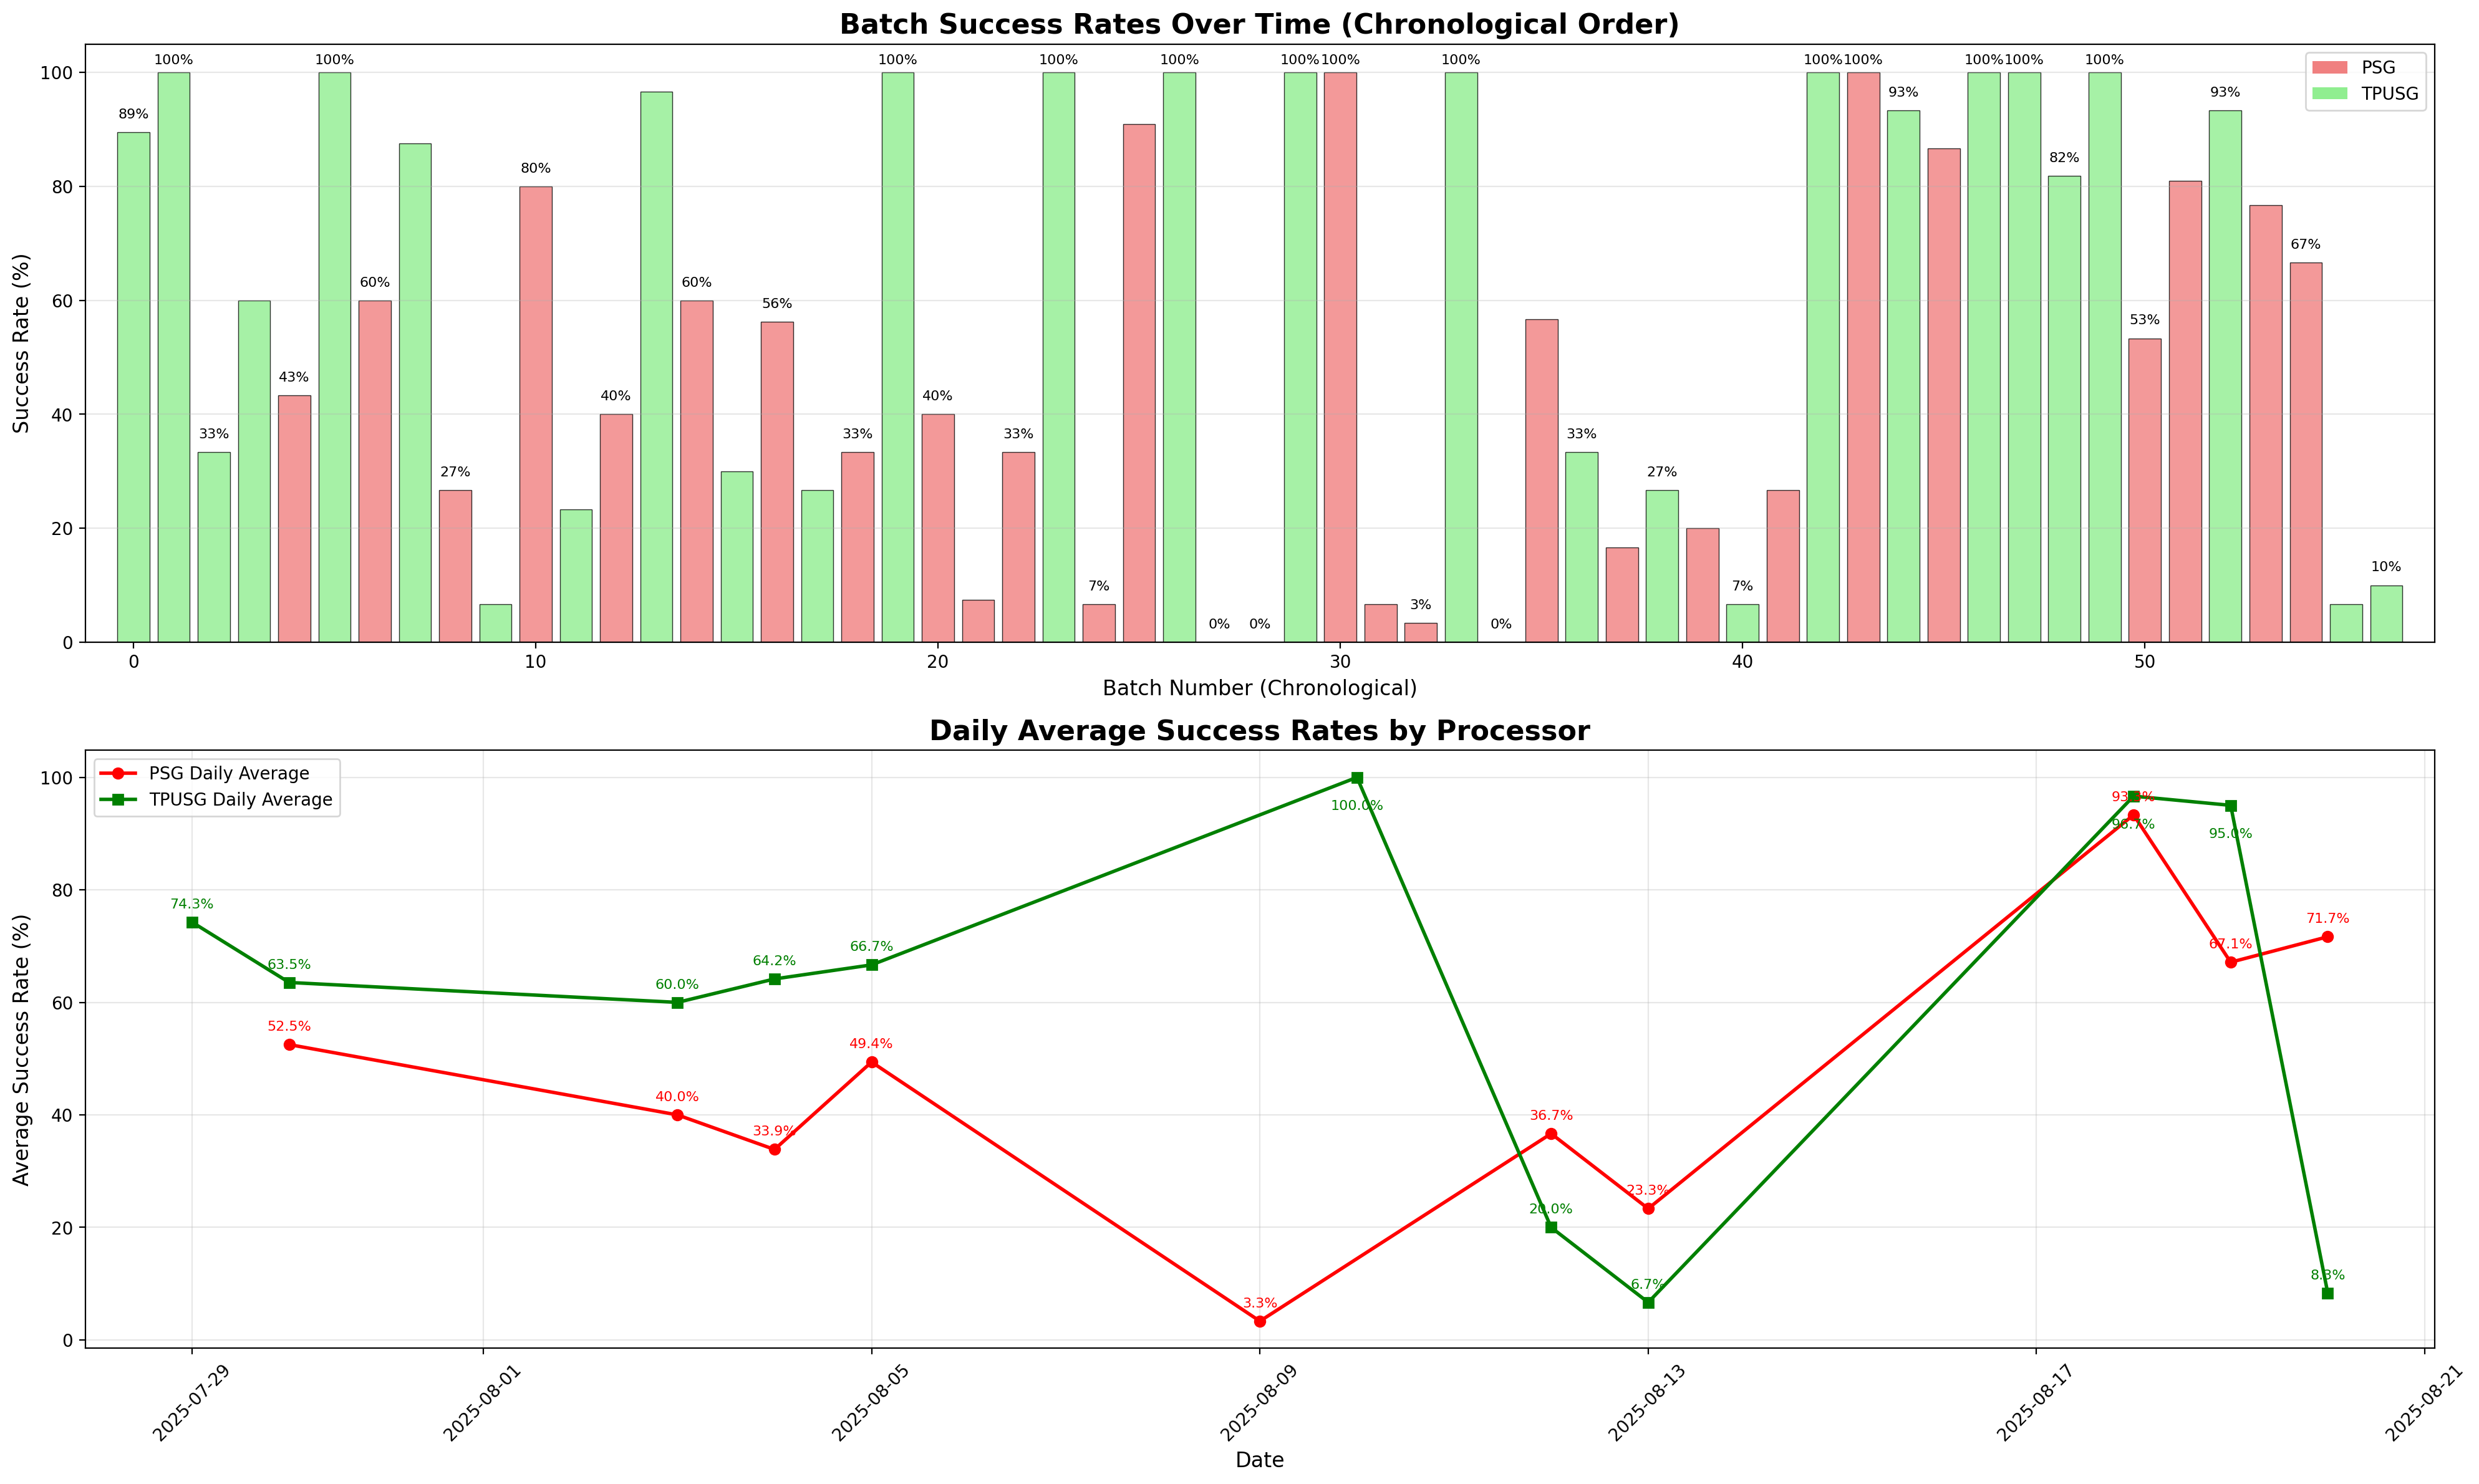


📊 BATCH TIMELINE SUMMARY:
--------------------------------------------------
Total unique batches: 57
Date range: 12 unique days

Processor breakdown:
  PSG batches: 27 (avg success: 47.1%)
  TPUSG batches: 30 (avg success: 63.5%)

🏆 Best performing batch:
  qwen32b_4e11_tpusg: 100.0% (tpusg, qwen32b)

📉 Worst performing batch:
  qwen14b_33b8_psg: 0.0% (psg, qwen14b)

✅ Batch timeline analysis complete!
📈 Timeline shows 57 batches across 21 processor-date combinations


In [15]:
# Batch Timeline Analysis Function
print("\n📈 BATCH SUCCESS RATE TIMELINE ANALYSIS")
print("=" * 70)

def analyze_batch_timeline(df):
    """
    Analyze success rates for each batch_id over time.
    Groups data by batch_id, calculates success rate, and uses earliest timestamp.
    """
    print("🔄 Processing batch timeline data...")
    
    # Group by batch_id and aggregate
    batch_analysis = df.groupby('batch_id').agg({
        'status': ['count', lambda x: (x == 'success').sum()],  # total runs and successes
        'timestamp': 'min',  # earliest timestamp in the batch
        'test_date': 'first',  # first test date
        'processor': 'first',  # processor type
        'model_config': 'first',  # model configuration
        'parameters': 'first'  # parameter setting
    }).reset_index()
    
    # Flatten column names
    batch_analysis.columns = ['batch_id', 'total_runs', 'successes', 'earliest_timestamp', 
                             'test_date', 'processor', 'model_config', 'parameters']
    
    # Calculate success rate
    batch_analysis['success_rate'] = (batch_analysis['successes'] / batch_analysis['total_runs'] * 100).round(2)
    
    # Convert timestamp to datetime for plotting
    batch_analysis['datetime'] = pd.to_datetime(batch_analysis['earliest_timestamp'], unit='s')
    
    # Sort by timestamp
    batch_analysis = batch_analysis.sort_values('earliest_timestamp')
    
    print(f"📊 Analyzed {len(batch_analysis)} unique batches")
    print(f"📅 Date range: {batch_analysis['datetime'].min().strftime('%Y-%m-%d %H:%M')} to {batch_analysis['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    
    return batch_analysis

def plot_batch_timeline(batch_data):
    """
    Create a timeline bar chart of batch success rates.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
    
    # Chart 1: All batches chronologically
    colors = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in batch_data['processor']]
    
    bars = ax1.bar(range(len(batch_data)), batch_data['success_rate'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax1.set_title('Batch Success Rates Over Time (Chronological Order)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Batch Number (Chronological)', fontsize=12)
    ax1.set_ylabel('Success Rate (%)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 105)
    y_max = ax1.get_ylim()[1]
    label_margin = 3
    
    edge_padding = 1.2
    ax1.set_xlim(-edge_padding, len(batch_data) - 1 + edge_padding)
    
    
    # Add processor legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                      Patch(facecolor='lightgreen', label='TPUSG')]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Add value labels for significant points
    for i, (rate, batch_id) in enumerate(zip(batch_data['success_rate'], batch_data['batch_id'])):
        if rate == 100 or rate == 0 or i % max(1, len(batch_data)//20) == 0:  # Label every ~20th bar or extremes
            label_y = min(rate + 2, y_max - 1- label_margin)
            ax1.text(i, label_y, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=0)
            # ax1.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Chart 2: Daily aggregated success rates
    batch_data['date'] = batch_data['datetime'].dt.date
    daily_stats = batch_data.groupby(['date', 'processor']).agg({
        'success_rate': 'mean',
        'batch_id': 'count'
    }).reset_index()
    daily_stats.columns = ['date', 'processor', 'avg_success_rate', 'batch_count']
    
    # Create separate data for PSG and TPUSG
    psg_daily = daily_stats[daily_stats['processor'] == 'psg'].sort_values('date')
    tpusg_daily = daily_stats[daily_stats['processor'] == 'tpusg'].sort_values('date')
    
    # Plot daily averages
    if not psg_daily.empty:
        ax2.plot(psg_daily['date'], psg_daily['avg_success_rate'], 
                marker='o', linewidth=2, markersize=6, color='red', label='PSG Daily Average')
        # <CHANGES>
        for date_val, success_val in zip(psg_daily['date'], psg_daily['avg_success_rate']):
            offset = 2 if success_val < 95 else -4
            ax2.text(date_val, success_val + offset, f'{success_val:.1f}%',
                     color='red', fontsize=8, ha='center', va='bottom' if offset >= 0 else 'top')
        # </CHANGES>
    
    if not tpusg_daily.empty:
        ax2.plot(tpusg_daily['date'], tpusg_daily['avg_success_rate'], 
                marker='s', linewidth=2, markersize=6, color='green', label='TPUSG Daily Average')
        # <CHANGES>
        for date_val, success_val in zip(tpusg_daily['date'], tpusg_daily['avg_success_rate']):
            offset = 2 if success_val < 95 else -4
            ax2.text(date_val, success_val + offset, f'{success_val:.1f}%',
                     color='green', fontsize=8, ha='center', va='bottom' if offset >= 0 else 'top')
        # </CHANGES>
    
    ax2.set_title('Daily Average Success Rates by Processor', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Average Success Rate (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    # save as pdf 400 dpi
    plt.savefig('batch_success_rate_timeline.pdf', dpi=400)
    plt.show()
    
    return daily_stats

# Execute the batch timeline analysis
batch_timeline_data = analyze_batch_timeline(df)

# Display sample of the data
# print("\n📋 SAMPLE BATCH TIMELINE DATA:")
# print("-" * 80)
# sample_data = batch_timeline_data[['batch_id', 'processor', 'model_config', 'parameters', 
#                                   'total_runs', 'successes', 'success_rate', 'test_date']].head(10)
# print(sample_data.to_string(index=False))

# Create the timeline visualization
print(f"\n📈 CREATING BATCH TIMELINE VISUALIZATION...")
daily_summary = plot_batch_timeline(batch_timeline_data)

# Summary statistics
print(f"\n📊 BATCH TIMELINE SUMMARY:")
print("-" * 50)
print(f"Total unique batches: {len(batch_timeline_data)}")
print(f"Date range: {len(batch_timeline_data['datetime'].dt.date.unique())} unique days")

psg_batches = batch_timeline_data[batch_timeline_data['processor'] == 'psg']
tpusg_batches = batch_timeline_data[batch_timeline_data['processor'] == 'tpusg']

print(f"\nProcessor breakdown:")
print(f"  PSG batches: {len(psg_batches)} (avg success: {psg_batches['success_rate'].mean():.1f}%)")
print(f"  TPUSG batches: {len(tpusg_batches)} (avg success: {tpusg_batches['success_rate'].mean():.1f}%)")

# Best and worst performing batches
best_batch = batch_timeline_data.loc[batch_timeline_data['success_rate'].idxmax()]
worst_batch = batch_timeline_data.loc[batch_timeline_data['success_rate'].idxmin()]

print(f"\n🏆 Best performing batch:")
print(f"  {best_batch['batch_id']}: {best_batch['success_rate']:.1f}% ({best_batch['processor']}, {best_batch['model_config']})")

print(f"\n📉 Worst performing batch:")
print(f"  {worst_batch['batch_id']}: {worst_batch['success_rate']:.1f}% ({worst_batch['processor']}, {worst_batch['model_config']})")

print(f"\n✅ Batch timeline analysis complete!")
print(f"📈 Timeline shows {len(batch_timeline_data)} batches across {len(daily_summary)} processor-date combinations")


📊 DETAILED BATCH TIMELINE: WITH/WITHOUT PARAMETERS ANALYSIS
🔄 Creating parameter-separated visualizations...


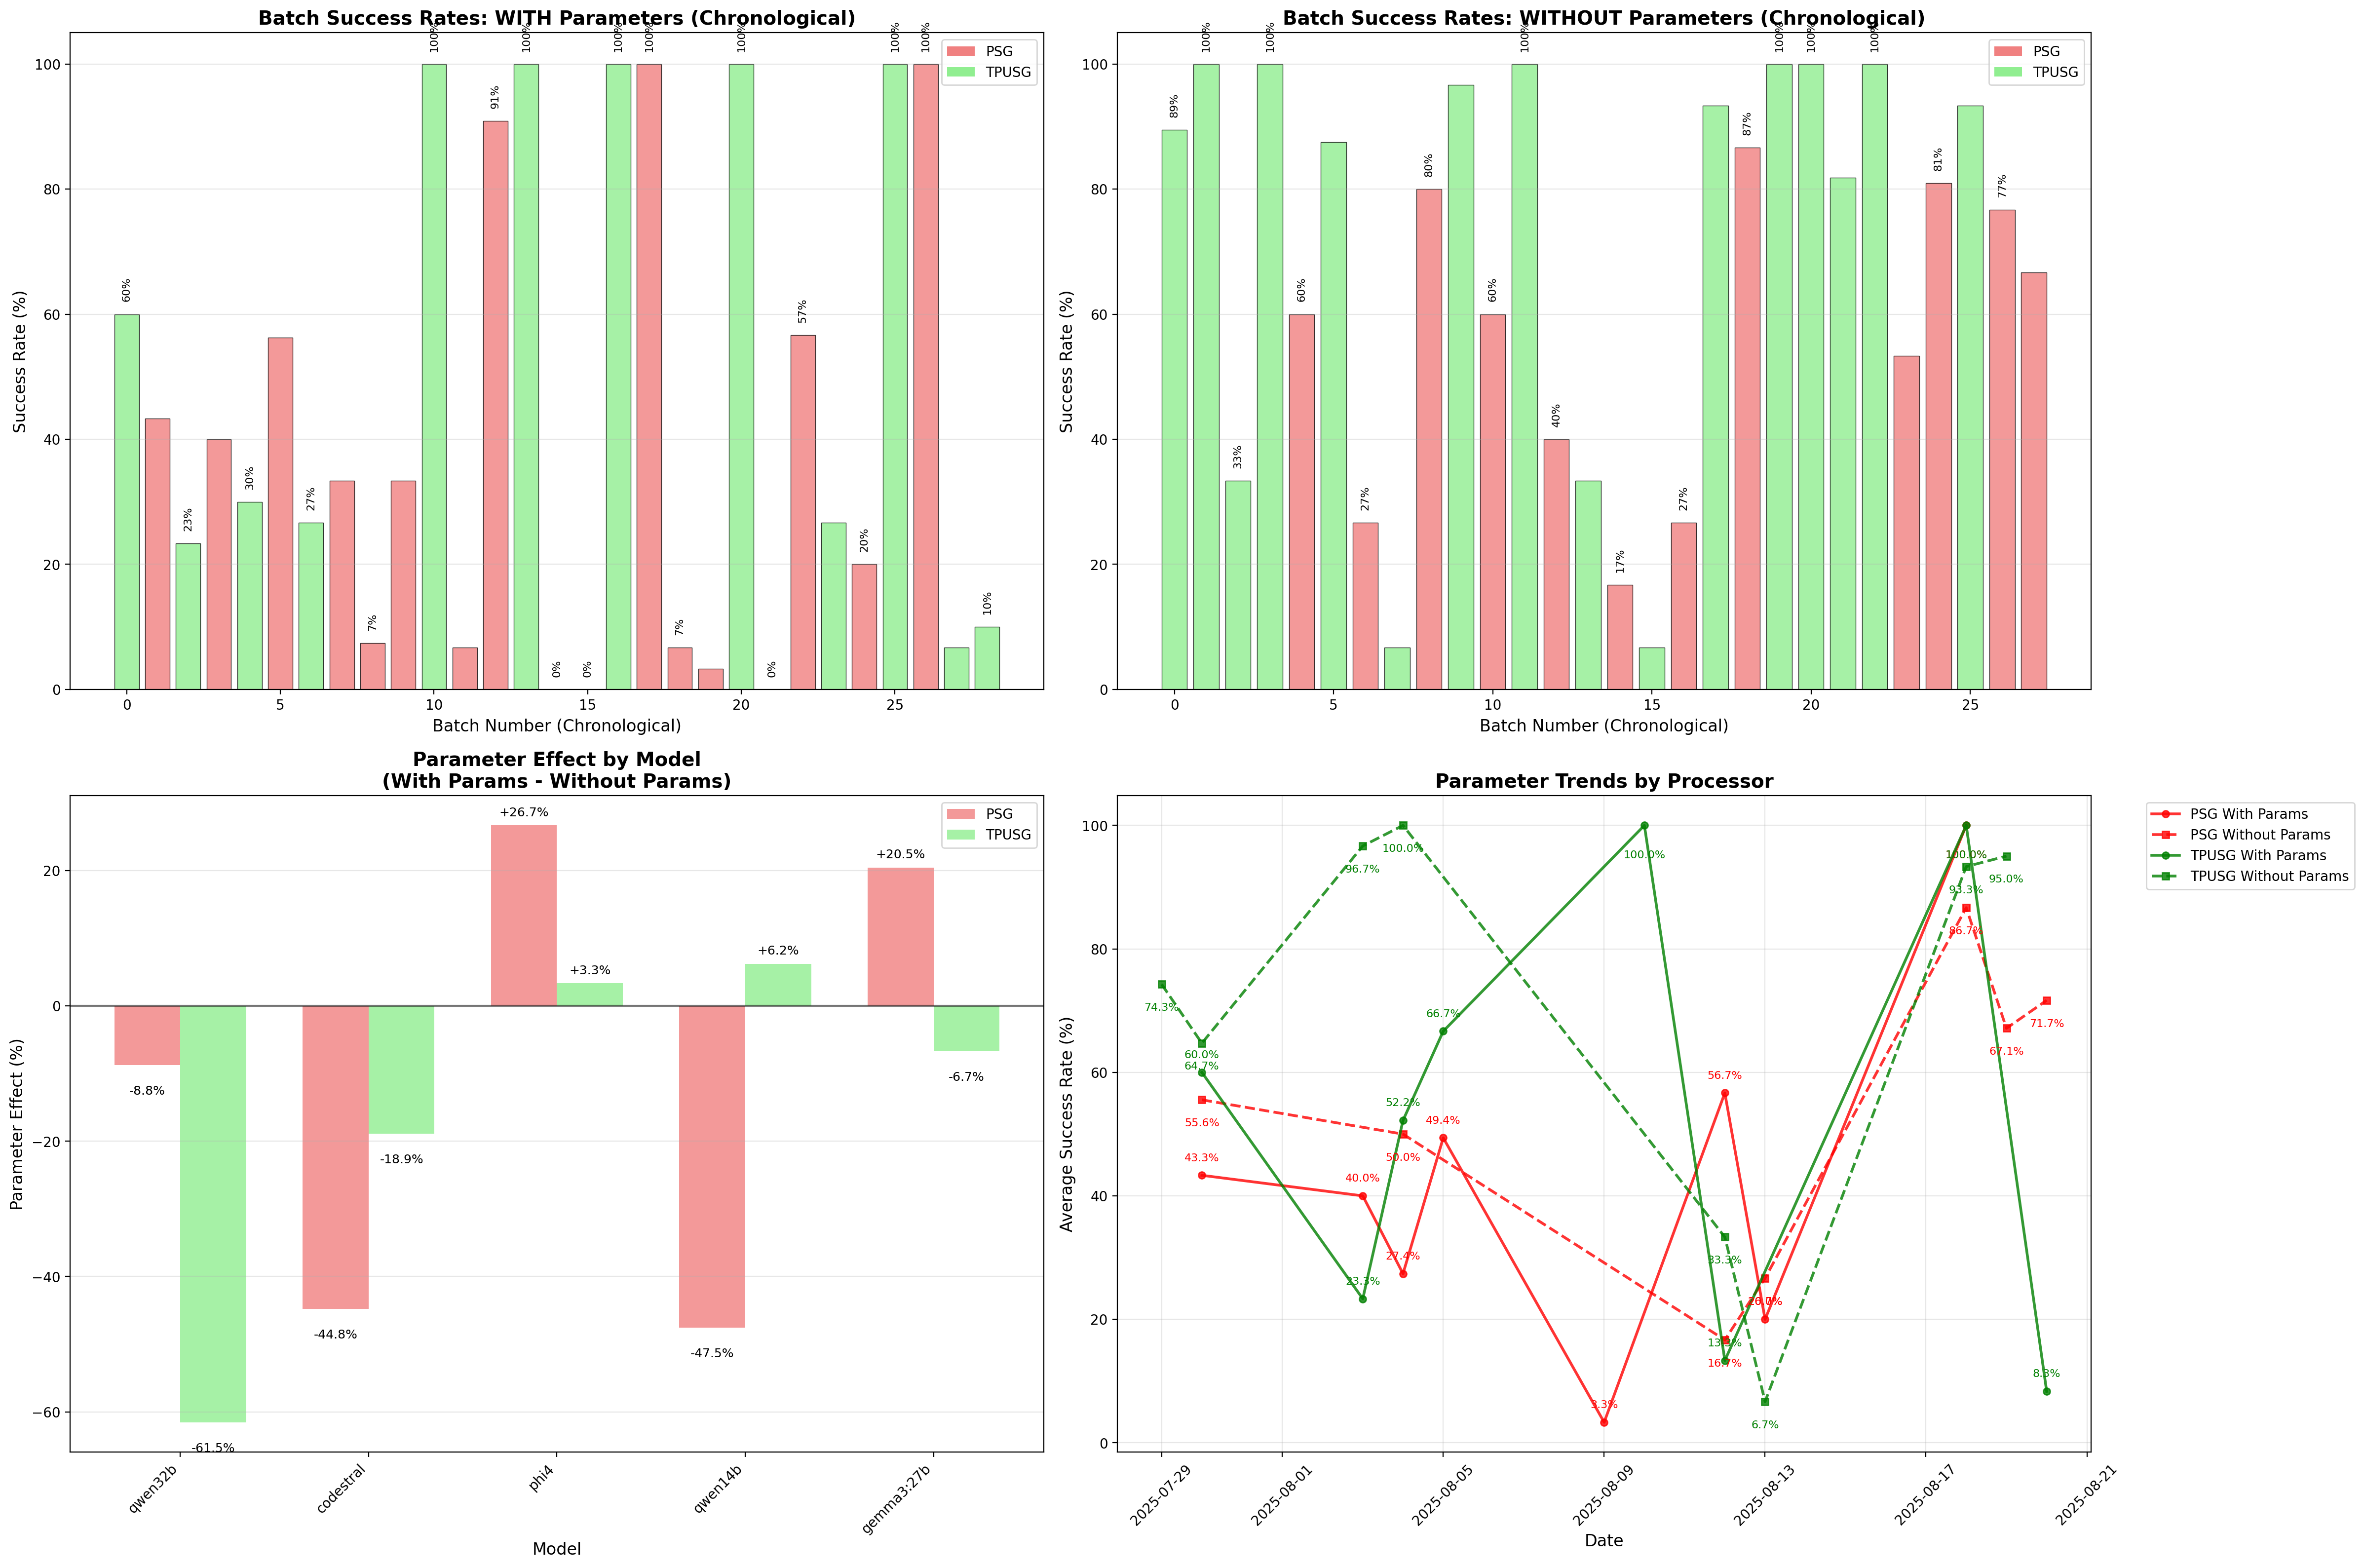


📊 PARAMETER-SPECIFIC BATCH SUMMARY:
------------------------------------------------------------
📈 WITH Parameters:
  Total batches: 29
  PSG: 15 batches (avg: 39.9%)
  TPUSG: 14 batches (avg: 48.8%)
  Best with params: qwen14b_3193_tpusg (100.0%)
  Worst with params: qwen14b_33b8_psg (0.0%)

📉 WITHOUT Parameters:
  Total batches: 28
  PSG: 12 batches (avg: 56.2%)
  TPUSG: 16 batches (avg: 76.4%)
  Best without params: qwen32b_4e11_tpusg (100.0%)
  Worst without params: gemma3:27b_85a9_tpusg (6.7%)

⚙️ PARAMETER EFFECT ANALYSIS:
--------------------------------------------------
qwen32b:
  PSG: 41.2% (with) vs 50.0% (without) → -8.8% effect
  TPUSG: 35.0% (with) vs 96.5% (without) → -61.5% effect
codestral:
  PSG: 10.0% (with) vs 54.8% (without) → -44.8% effect
  TPUSG: 14.4% (with) vs 33.3% (without) → -18.9% effect
phi4:
  PSG: 100.0% (with) vs 73.3% (without) → +26.7% effect
  TPUSG: 100.0% (with) vs 96.7% (without) → +3.3% effect
qwen14b:
  PSG: 4.7% (with) vs 52.2% (without) → -4

In [16]:
# Enhanced Batch Timeline Analysis: Parameter-Separated Visualization
print("\n📊 DETAILED BATCH TIMELINE: WITH/WITHOUT PARAMETERS ANALYSIS")
print("=" * 70)

def plot_detailed_parameter_timeline(batch_data):
    """
    Create detailed timeline charts separated by parameter conditions.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))

    # Separate data by parameters
    with_params = batch_data[batch_data['parameters'] == True].sort_values('earliest_timestamp')
    without_params = batch_data[batch_data['parameters'] == False].sort_values('earliest_timestamp')

    # Chart 1: With Parameters - Chronological
    if not with_params.empty:
        colors_with = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in with_params['processor']]
        bars1 = ax1.bar(range(len(with_params)), with_params['success_rate'],
                       color=colors_with, alpha=0.8, edgecolor='black', linewidth=0.5)

        ax1.set_title('Batch Success Rates: WITH Parameters (Chronological)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Batch Number (Chronological)', fontsize=12)
        ax1.set_ylabel('Success Rate (%)', fontsize=12)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_ylim(0, 105)

        # Add processor legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                          Patch(facecolor='lightgreen', label='TPUSG')]
        ax1.legend(handles=legend_elements, loc='upper right')

        # Add value labels for extremes and every few bars
        for i, (rate, batch_id) in enumerate(zip(with_params['success_rate'], with_params['batch_id'])):
            if rate == 100 or rate == 0 or i % max(1, len(with_params)//10) == 0:
                ax1.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax1.text(0.5, 0.5, 'No batches with parameters', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Batch Success Rates: WITH Parameters', fontsize=14, fontweight='bold')

    # Chart 2: Without Parameters - Chronological
    if not without_params.empty:
        colors_without = ['lightcoral' if proc == 'psg' else 'lightgreen' for proc in without_params['processor']]
        bars2 = ax2.bar(range(len(without_params)), without_params['success_rate'],
                       color=colors_without, alpha=0.8, edgecolor='black', linewidth=0.5)

        ax2.set_title('Batch Success Rates: WITHOUT Parameters (Chronological)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Batch Number (Chronological)', fontsize=12)
        ax2.set_ylabel('Success Rate (%)', fontsize=12)
        ax2.grid(axis='y', alpha=0.3)
        ax2.set_ylim(0, 105)

        # Add processor legend
        legend_elements = [Patch(facecolor='lightcoral', label='PSG'),
                          Patch(facecolor='lightgreen', label='TPUSG')]
        ax2.legend(handles=legend_elements, loc='upper right')

        # Add value labels for extremes and every few bars
        for i, (rate, batch_id) in enumerate(zip(without_params['success_rate'], without_params['batch_id'])):
            if rate == 100 or rate == 0 or i % max(1, len(without_params)//10) == 0:
                ax2.text(i, rate + 2, f'{rate:.0f}%', ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax2.text(0.5, 0.5, 'No batches without parameters', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Batch Success Rates: WITHOUT Parameters', fontsize=14, fontweight='bold')

    # Chart 3: Parameter Effect Comparison by Model
    model_param_comparison = []
    for model in batch_data['model_config'].unique():
        model_with = batch_data[(batch_data['model_config'] == model) & (batch_data['parameters'] == True)]
        model_without = batch_data[(batch_data['model_config'] == model) & (batch_data['parameters'] == False)]

        if not model_with.empty and not model_without.empty:
            psg_with = model_with[model_with['processor'] == 'psg']['success_rate'].mean() if not model_with[model_with['processor'] == 'psg'].empty else 0
            psg_without = model_without[model_without['processor'] == 'psg']['success_rate'].mean() if not model_without[model_without['processor'] == 'psg'].empty else 0
            tpusg_with = model_with[model_with['processor'] == 'tpusg']['success_rate'].mean() if not model_with[model_with['processor'] == 'tpusg'].empty else 0
            tpusg_without = model_without[model_without['processor'] == 'tpusg']['success_rate'].mean() if not model_without[model_without['processor'] == 'tpusg'].empty else 0

            model_param_comparison.append({
                'model': model,
                'psg_with': psg_with,
                'psg_without': psg_without,
                'tpusg_with': tpusg_with,
                'tpusg_without': tpusg_without,
                'psg_effect': psg_with - psg_without,
                'tpusg_effect': tpusg_with - tpusg_without
            })

    if model_param_comparison:
        param_df = pd.DataFrame(model_param_comparison)
        models = param_df['model']
        x = np.arange(len(models))
        width = 0.35

        bars3 = ax3.bar(x - width/2, param_df['psg_effect'], width, label='PSG', color='lightcoral', alpha=0.8)
        bars4 = ax3.bar(x + width/2, param_df['tpusg_effect'], width, label='TPUSG', color='lightgreen', alpha=0.8)

        ax3.set_title('Parameter Effect by Model\n(With Params - Without Params)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Model', fontsize=12)
        ax3.set_ylabel('Parameter Effect (%)', fontsize=12)
        ax3.set_xticks(x)
        ax3.set_xticklabels(models, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # Add value labels
        for i, (p_eff, t_eff) in enumerate(zip(param_df['psg_effect'], param_df['tpusg_effect'])):
            ax3.text(i - width/2, p_eff + (1 if p_eff >= 0 else -3), f'{p_eff:+.1f}%',
                    ha='center', va='bottom' if p_eff >= 0 else 'top', fontsize=9)
            ax3.text(i + width/2, t_eff + (1 if t_eff >= 0 else -3), f'{t_eff:+.1f}%',
                    ha='center', va='bottom' if t_eff >= 0 else 'top', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'Insufficient data for parameter comparison', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Parameter Effect by Model', fontsize=14, fontweight='bold')

    # Chart 4: Daily Parameter Trends
    batch_data['date'] = batch_data['datetime'].dt.date
    daily_param_stats = batch_data.groupby(['date', 'processor', 'parameters']).agg({
        'success_rate': 'mean',
        'batch_id': 'count'
    }).reset_index()
    daily_param_stats.columns = ['date', 'processor', 'parameters', 'avg_success_rate', 'batch_count']

    # Plot trends for each processor-parameter combination
    for proc in ['psg', 'tpusg']:
        for param in [True, False]:
            data = daily_param_stats[(daily_param_stats['processor'] == proc) & (daily_param_stats['parameters'] == param)]
            if not data.empty:
                color = 'red' if proc == 'psg' else 'green'
                linestyle = '-' if param else '--'
                marker = 'o' if param else 's'
                label = f"{proc.upper()} {'With' if param else 'Without'} Params"

                ax4.plot(data['date'], data['avg_success_rate'],
                        marker=marker, linewidth=2, markersize=5, color=color,
                        linestyle=linestyle, label=label, alpha=0.8)
                # <CHANGES>
                for date_val, success_val in zip(data['date'], data['avg_success_rate']):
                    offset = 2 if param else -3
                    if success_val + offset > 100:
                        offset = -4
                    if success_val + offset < 0:
                        offset = 2
                    vertical_alignment = 'bottom' if offset >= 0 else 'top'
                    ax4.text(date_val, success_val + offset, f'{success_val:.1f}%',
                             color=color, fontsize=8, ha='center', va=vertical_alignment)
                # </CHANGES>

    ax4.set_title('Parameter Trends by Processor', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Average Success Rate (%)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return param_df if model_param_comparison else None

# Execute the detailed parameter timeline analysis
print("🔄 Creating parameter-separated visualizations...")
parameter_comparison = plot_detailed_parameter_timeline(batch_timeline_data)

# Parameter-specific summary statistics
print(f"\n📊 PARAMETER-SPECIFIC BATCH SUMMARY:")
print("-" * 60)

with_params_data = batch_timeline_data[batch_timeline_data['parameters'] == True]
without_params_data = batch_timeline_data[batch_timeline_data['parameters'] == False]

print(f"📈 WITH Parameters:")
print(f"  Total batches: {len(with_params_data)}")
if not with_params_data.empty:
    psg_with = with_params_data[with_params_data['processor'] == 'psg']
    tpusg_with = with_params_data[with_params_data['processor'] == 'tpusg']
    print(f"  PSG: {len(psg_with)} batches (avg: {psg_with['success_rate'].mean():.1f}%)")
    print(f"  TPUSG: {len(tpusg_with)} batches (avg: {tpusg_with['success_rate'].mean():.1f}%)")
    print(f"  Best with params: {with_params_data.loc[with_params_data['success_rate'].idxmax()]['batch_id']} ({with_params_data['success_rate'].max():.1f}%)")
    print(f"  Worst with params: {with_params_data.loc[with_params_data['success_rate'].idxmin()]['batch_id']} ({with_params_data['success_rate'].min():.1f}%)")

print(f"\n📉 WITHOUT Parameters:")
print(f"  Total batches: {len(without_params_data)}")
if not without_params_data.empty:
    psg_without = without_params_data[without_params_data['processor'] == 'psg']
    tpusg_without = without_params_data[without_params_data['processor'] == 'tpusg']
    print(f"  PSG: {len(psg_without)} batches (avg: {psg_without['success_rate'].mean():.1f}%)")
    print(f"  TPUSG: {len(tpusg_without)} batches (avg: {tpusg_without['success_rate'].mean():.1f}%)")
    print(f"  Best without params: {without_params_data.loc[without_params_data['success_rate'].idxmax()]['batch_id']} ({without_params_data['success_rate'].max():.1f}%)")
    print(f"  Worst without params: {without_params_data.loc[without_params_data['success_rate'].idxmin()]['batch_id']} ({without_params_data['success_rate'].min():.1f}%)")

# Parameter effect analysis
if parameter_comparison is not None and not parameter_comparison.empty:
    print(f"\n⚙️ PARAMETER EFFECT ANALYSIS:")
    print("-" * 50)
    for _, row in parameter_comparison.iterrows():
        print(f"{row['model']}:")
        print(f"  PSG: {row['psg_with']:.1f}% (with) vs {row['psg_without']:.1f}% (without) → {row['psg_effect']:+.1f}% effect")
        print(f"  TPUSG: {row['tpusg_with']:.1f}% (with) vs {row['tpusg_without']:.1f}% (without) → {row['tpusg_effect']:+.1f}% effect")

print(f"\n✅ Parameter-separated batch timeline analysis complete!")
print(f"📊 Analysis reveals parameter effects across {len(batch_timeline_data)} batches in timeline order")

### 12.1 Parameter-Specific Timeline Review
> Tutorial: Compare the with-parameter and without-parameter timelines above to diagnose configuration shifts before exploring long-term trends.

## 13. Temporal Trends
> Tutorial: Generate the configuration-level timeline plots to highlight longer-term slope changes and evolving success-rate dynamics.

Leverage these visuals to spot momentum shifts for individual processor–model combinations.


📈 20-CONFIGURATION TIMELINE WITH ORGANIZED LINES
🚀 Starting 20-configuration timeline analysis...
🔄 Processing 20-configuration batch timeline data...
📊 Analyzed 57 unique batches
📅 Date range: 2025-07-29 11:00 to 2025-08-20 13:49
🔧 Total configurations found: 20

📋 ORGANIZING 20 CONFIGURATIONS:
🔵 PSG Group: 10 configurations
🔴 TPUSG Group: 10 configurations

📈 CREATING 20-LINE ORGANIZED TIMELINE...
📊 Creating timeline with 10 PSG + 10 TPUSG lines
🎨 Plotting PSG configuration lines...
🎨 Plotting TPUSG configuration lines...


📊 20-CONFIGURATION TIMELINE SUMMARY


🔵 PSG CONFIGURATIONS:
-----------------------------------
phi4         WithParams 100.0% ( 2b)
gemma3:27b   WithParams  73.8% ( 2b)
phi4         NoParams    73.3% ( 2b)
codestral    NoParams    54.8% ( 3b)
gemma3:27b   NoParams    53.3% ( 2b)
qwen14b      NoParams    52.2% ( 3b)
qwen32b      NoParams    50.0% ( 2b)
qwen32b      WithParams  41.2% ( 5b)
codestral    WithParams  10.0% ( 3b)
qwen14b      WithParams   4.7% ( 3b)

🔴 TPUSG CONFIGURATIONS:
-----------------------------------
phi4         WithParams 100.0% ( 3b)
qwen14b      WithParams 100.0% ( 2b)
phi4         NoParams    96.7% ( 2b)
qwen32b      NoParams    96.5% ( 4b)
qwen14b      NoParams    93.8% ( 6b)
qwen32b      WithParams  35.0% ( 4b)
codestral    NoParams    33.3% ( 2b)
codestral    WithParams  14.4% ( 3b)
gemma3:27b   NoParams     6.7% ( 2b)
gemma3:27b   WithParams   0.0% ( 2b)

🏆 OVERALL AVERAGES:
-------------------------
PSG Average:    51.3%
TPUSG Average:  57.6%
Winner: TPUS

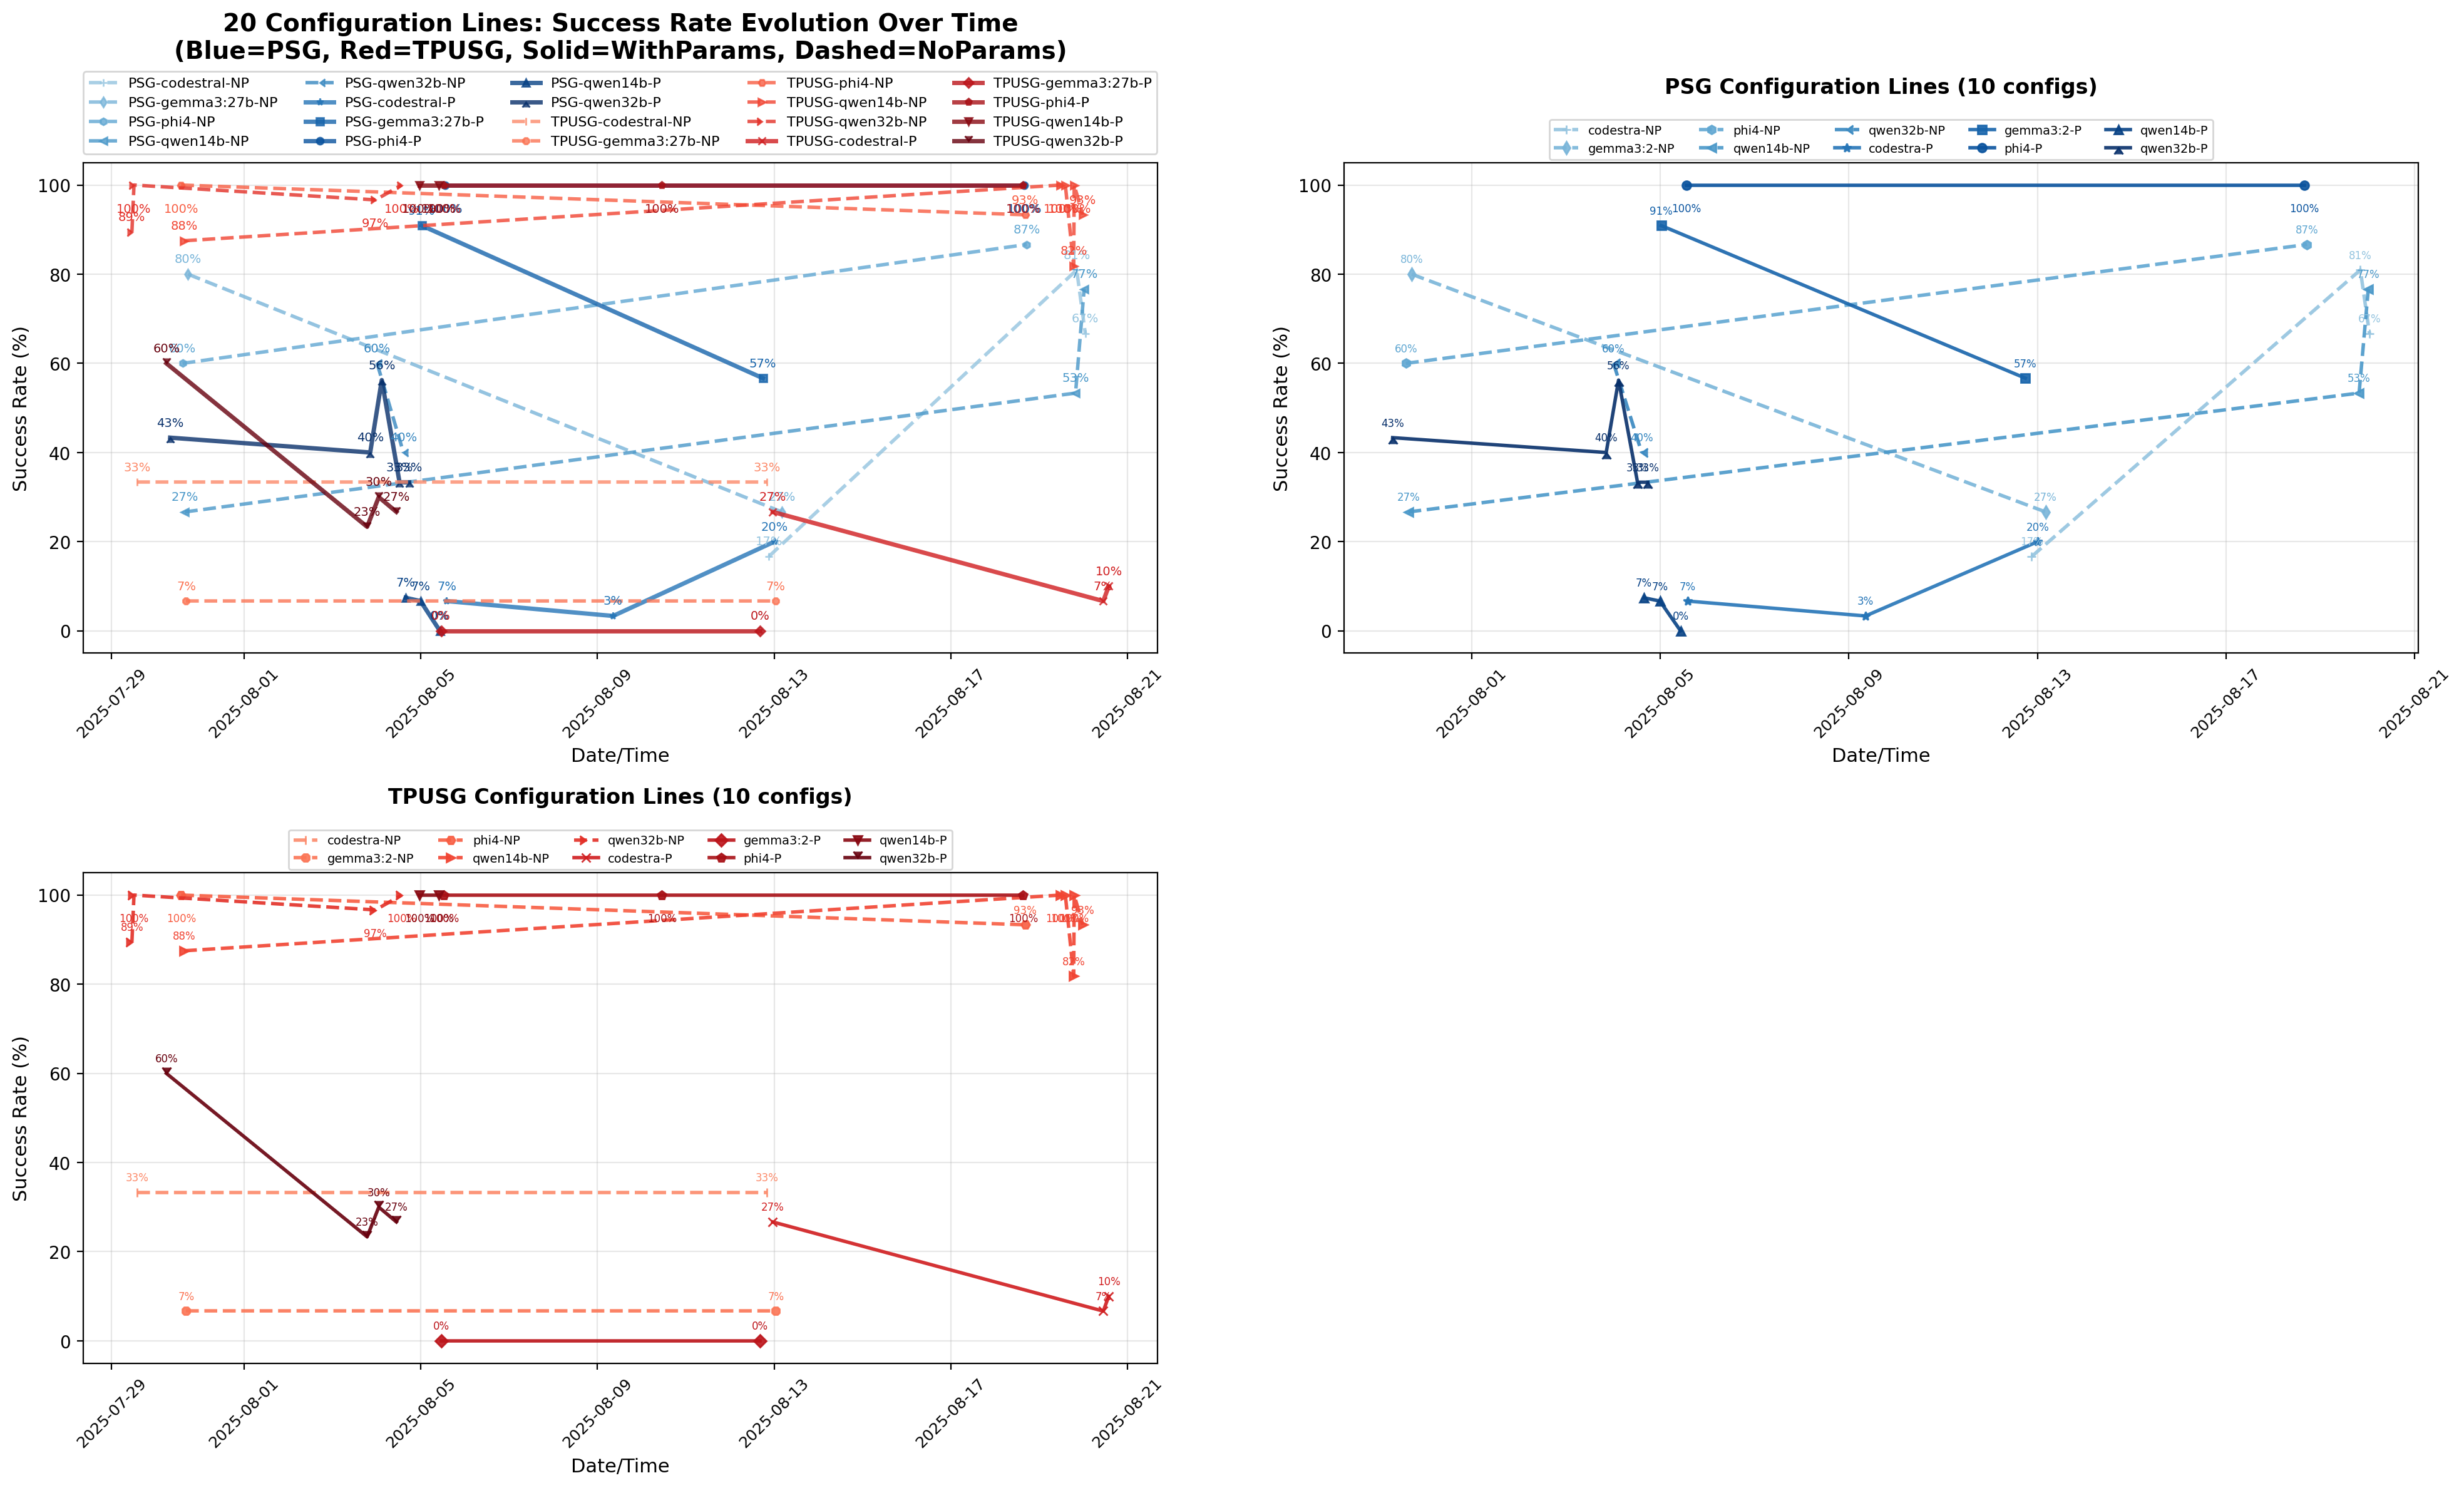


✅ 20-LINE TIMELINE COMPLETE!
📈 Successfully plotted 20 configuration lines
🔵 PSG lines: 10 (blue colors)
🔴 TPUSG lines: 10 (red colors)
━ Solid lines: With parameters
╌ Dashed lines: Without parameters
📊 Each line shows temporal evolution of one specific configuration


In [17]:
# =============================================================================
# 20-CONFIGURATION TIMELINE ANALYSIS WITH ORGANIZED LINES
# =============================================================================
print("\n📈 20-CONFIGURATION TIMELINE WITH ORGANIZED LINES")
print("=" * 80)

marker_types = {
    # phi4: Circle/Polygon Shapes
    'PSG-phi4-P': 'o',           # Circle
    'PSG-phi4-NP': 'h',          # Hexagon 1
    'TPUSG-phi4-P': 'p',         # Pentagon
    'TPUSG-phi4-NP': 'H',        # Hexagon 2

    # gemma3:27b: Square/Diamond Shapes
    'PSG-gemma3:27b-P': 's',     # Square
    'PSG-gemma3:27b-NP': 'd',    # Thin Diamond
    'TPUSG-gemma3:27b-P': 'D',   # Diamond
    'TPUSG-gemma3:27b-NP': '8',  # Octagon

    # qwen14b: Triangle Shapes
    'PSG-qwen14b-P': '^',        # Triangle Up
    'PSG-qwen14b-NP': '<',       # Triangle Left
    'TPUSG-qwen14b-P': 'v',      # Triangle Down
    'TPUSG-qwen14b-NP': '>',      # Triangle Right

    # qwen32b: Caret Shapes
    'PSG-qwen32b-P': 6,        # Caret U
    'PSG-qwen32b-NP': 4,       # Caret Left
    'TPUSG-qwen32b-P': 7,      # Caret Down
    'TPUSG-qwen32b-NP': 5,       # Caret Right

    # codestral: Star/Cross Shapes
    'PSG-codestral-P': '*',      # Star
    'PSG-codestral-NP': '+',     # Plus
    'TPUSG-codestral-P': 'x',    # X
    'TPUSG-codestral-NP': '|',   # Vertical Line
}

# Import required libraries
from scipy import stats

def analyze_20_config_batch_timeline(df):
    """
    Analyze success rates creating 20 distinct configurations:
    Processor (2) × Parameters (2) × Model (5) = 20 configurations
    """
    print("🔄 Processing 20-configuration batch timeline data...")
    
    # Check if timestamp column exists
    if 'timestamp' not in df.columns:
        print("⚠️ Warning: No timestamp column found. This may affect temporal analysis accuracy.")
        return None, None
    
    # Group by batch_id and aggregate
    batch_analysis = df.groupby('batch_id').agg({
        'status': ['count', lambda x: (x == 'success').sum()],  # total runs and successes
        'timestamp': 'min',  # earliest timestamp in the batch
        'processor': 'first',  # processor type
        'model_config': 'first',  # model configuration
        'parameters': 'first'  # parameter setting
    }).reset_index()
    
    # Flatten column names
    batch_analysis.columns = ['batch_id', 'total_runs', 'successes', 'earliest_timestamp', 
                             'processor', 'model_config', 'parameters']
    
    # Calculate success rate
    batch_analysis['success_rate'] = (batch_analysis['successes'] / batch_analysis['total_runs'] * 100).round(2)
    
    # Create the 20 unique configurations
    batch_analysis['config_id'] = (batch_analysis['processor'] + '_' + 
                                  batch_analysis['parameters'].astype(str) + '_' + 
                                  batch_analysis['model_config'])
    
    # Convert timestamp to datetime for plotting
    batch_analysis['datetime'] = pd.to_datetime(batch_analysis['earliest_timestamp'], unit='s')
    batch_analysis['date'] = batch_analysis['datetime'].dt.date
    
    # Sort by timestamp for chronological analysis
    batch_analysis = batch_analysis.sort_values('earliest_timestamp')
    
    # Get all unique configurations
    unique_configs = sorted(batch_analysis['config_id'].unique())
    
    print(f"📊 Analyzed {len(batch_analysis)} unique batches")
    print(f"📅 Date range: {batch_analysis['datetime'].min().strftime('%Y-%m-%d %H:%M')} to {batch_analysis['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"🔧 Total configurations found: {len(unique_configs)}")
    
    return batch_analysis, unique_configs

def _annotate_line(ax, x_values, y_values, color, fontsize=7):
    """Annotate each point on a line with its success rate."""
    # <CHANGES>
    for x_val, y_val in zip(x_values, y_values):
        offset = 2 if y_val < 95 else -4
        if y_val + offset > 100:
            offset = -4
        if y_val + offset < 0:
            offset = 2
        va = 'bottom' if offset >= 0 else 'top'
        ax.text(x_val, y_val + offset, f'{y_val:.0f}%', color=color, fontsize=fontsize, ha='center', va=va)
    # </CHANGES>

def create_20_line_timeline(batch_data, unique_configs):
    """
    Create organized timeline with 20 distinct configuration lines
    """
    if batch_data is None:
        print("❌ Cannot create visualization without valid batch data.")
        return None
    
    # Separate configurations by processor
    psg_configs = sorted([config for config in unique_configs if config.startswith('psg_')])
    tpusg_configs = sorted([config for config in unique_configs if config.startswith('tpusg_')])
    
    print(f"📊 Creating timeline with {len(psg_configs)} PSG + {len(tpusg_configs)} TPUSG lines")
    
    # Create color palettes
    psg_colors = plt.cm.Blues(np.linspace(0.4, 1.0, len(psg_configs)))
    tpusg_colors = plt.cm.Reds(np.linspace(0.4, 1.0, len(tpusg_configs)))
    
    # Create the main timeline figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Main timeline with all 20 lines
    print("🎨 Plotting PSG configuration lines...")
    for i, config in enumerate(psg_configs):
        config_data = batch_data[batch_data['config_id'] == config].sort_values('datetime')
        if not config_data.empty:
            param_setting = config_data['parameters'].iloc[0]
            model_name = config_data['model_config'].iloc[0]
            
            # Line style based on parameters
            linestyle = '-' if param_setting else '--'
            linewidth = 2.5 if param_setting else 2.0
            color = psg_colors[i]
            
            if len(config_data) >= 2:
                ax1.plot(config_data['datetime'], config_data['success_rate'],
                        color=color, linestyle=linestyle, linewidth=linewidth,
                        marker=marker_types[f'PSG-{model_name}-{"P" if param_setting else "NP"}'], markersize=4, alpha=0.8,
                        label=f'PSG-{model_name}-{"P" if param_setting else "NP"}')
            else:
                ax1.scatter(config_data['datetime'], config_data['success_rate'],
                           color=color, s=80, alpha=0.8, marker=marker_types[f'PSG-{model_name}-{"P" if param_setting else "NP"}'],
                           label=f'PSG-{model_name}-{"P" if param_setting else "NP"}')
            _annotate_line(ax1, config_data['datetime'], config_data['success_rate'], color)
    
    print("🎨 Plotting TPUSG configuration lines...")
    for i, config in enumerate(tpusg_configs):
        config_data = batch_data[batch_data['config_id'] == config].sort_values('datetime')
        if not config_data.empty:
            param_setting = config_data['parameters'].iloc[0]
            model_name = config_data['model_config'].iloc[0]
            
            # Line style based on parameters
            linestyle = '-' if param_setting else '--'
            linewidth = 2.5 if param_setting else 2.0
            color = tpusg_colors[i]
            
            if len(config_data) >= 2:
                ax1.plot(config_data['datetime'], config_data['success_rate'],
                        color=color, linestyle=linestyle, linewidth=linewidth,
                        marker=marker_types[f'TPUSG-{model_name}-{"P" if param_setting else "NP"}'], markersize=4, alpha=0.8,
                        label=f'TPUSG-{model_name}-{"P" if param_setting else "NP"}')
            else:
                ax1.scatter(config_data['datetime'], config_data['success_rate'],
                           color=color, s=100, alpha=0.8, marker=marker_types[f'TPUSG-{model_name}-{"P" if param_setting else "NP"}'],
                           label=f'TPUSG-{model_name}-{"P" if param_setting else "NP"}')
            _annotate_line(ax1, config_data['datetime'], config_data['success_rate'], color)
    
    ax1.set_title('20 Configuration Lines: Success Rate Evolution Over Time\n(Blue=PSG, Red=TPUSG, Solid=WithParams, Dashed=NoParams)', 
                  fontsize=14, fontweight='bold', pad=60)
    ax1.set_xlabel('Date/Time', fontsize=11)
    ax1.set_ylabel('Success Rate (%)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-5, 105)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)

    # Legend for all 20 configurations
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fontsize=8)
 
    # # Simplified legend
    # handles, labels = ax1.get_legend_handles_labels()
    # ax1.legend(handles[:10], labels[:10], loc='upper left', fontsize=6, ncol=2, title="First 10 configs")

    # A list of marker types, matching all the 20 model configurations, so there are 20 items in the list, combinging {PSG,TPUSG}-{phi4, gemma3:27b,qwen14b, qwen32b, codestral}-{P,NP}
 
    # 2. PSG-only detailed timeline
    for i, config in enumerate(psg_configs):
        config_data = batch_data[batch_data['config_id'] == config].sort_values('datetime')
        if not config_data.empty:
            param_setting = config_data['parameters'].iloc[0]
            model_name = config_data['model_config'].iloc[0]
            linestyle = '-' if param_setting else '--'
            color = psg_colors[i]
            
            if len(config_data) >= 2:
                ax2.plot(config_data['datetime'], config_data['success_rate'],
                        color=color, linestyle=linestyle, linewidth=2,
                        marker=marker_types[f'PSG-{model_name}-{"P" if param_setting else "NP"}'], markersize=5, alpha=0.9,
                        label=f'{model_name[:8]}-{"P" if param_setting else "NP"}')
            else:
                ax2.scatter(config_data['datetime'], config_data['success_rate'],
                           color=color, s=80, alpha=0.9, marker=marker_types[f'PSG-{model_name}-{"P" if param_setting else "NP"}'],
                           label=f'{model_name[:8]}-{"P" if param_setting else "NP"}')
            _annotate_line(ax2, config_data['datetime'], config_data['success_rate'], color, fontsize=6)
    
    ax2.set_title('PSG Configuration Lines (10 configs)', fontsize=12, fontweight='bold', pad=40)
    ax2.set_xlabel('Date/Time', fontsize=11)
    ax2.set_ylabel('Success Rate (%)', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-5, 105)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=7)
    
    # 3. TPUSG-only detailed timeline
    for i, config in enumerate(tpusg_configs):
        config_data = batch_data[batch_data['config_id'] == config].sort_values('datetime')
        if not config_data.empty:
            param_setting = config_data['parameters'].iloc[0]
            model_name = config_data['model_config'].iloc[0]
            linestyle = '-' if param_setting else '--'
            color = tpusg_colors[i]
            
            if len(config_data) >= 2:
                ax3.plot(config_data['datetime'], config_data['success_rate'],
                        color=color, linestyle=linestyle, linewidth=2,
                        marker=marker_types[f'TPUSG-{model_name}-{"P" if param_setting else "NP"}'], markersize=5, alpha=0.9,
                        label=f'{model_name[:8]}-{"P" if param_setting else "NP"}')
            else:
                ax3.scatter(config_data['datetime'], config_data['success_rate'],
                           color=color, s=100, alpha=0.9, marker=marker_types[f'TPUSG-{model_name}-{"P" if param_setting else "NP"}'],
                           label=f'{model_name[:8]}-{"P" if param_setting else "NP"}')
            _annotate_line(ax3, config_data['datetime'], config_data['success_rate'], color, fontsize=6)
    
    ax3.set_title('TPUSG Configuration Lines (10 configs)', fontsize=12, fontweight='bold', pad=40)
    ax3.set_xlabel('Date/Time', fontsize=11)
    ax3.set_ylabel('Success Rate (%)', fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-5, 105)
    ax3.tick_params(axis='x', rotation=45, labelsize=9)
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=7)
    
    # 4. Configuration summary table
    ax4.axis('off')
    
    # Create summary statistics
    config_stats = []
    for config in unique_configs:
        config_data = batch_data[batch_data['config_id'] == config]
        if not config_data.empty:
            processor, params, model = config.split('_', 2)
            mean_rate = config_data['success_rate'].mean()
            batch_count = len(config_data)
            config_stats.append({
                'processor': processor.upper(),
                'model': model,
                'params': params,
                'mean_rate': mean_rate,
                'batches': batch_count
            })
    
    # Sort by processor then by mean rate
    config_stats.sort(key=lambda x: (x['processor'], -x['mean_rate']))
    
    # Create text summary
    summary_text = "📊 20-CONFIGURATION TIMELINE SUMMARY\n" + "="*50 + "\n\n"
    
    current_processor = None
    for i, stat in enumerate(config_stats):
        if stat['processor'] != current_processor:
            current_processor = stat['processor']
            summary_text += f"\n🔵 {current_processor} CONFIGURATIONS:\n" if current_processor == 'PSG' else f"\n🔴 {current_processor} CONFIGURATIONS:\n"
            summary_text += "-" * 35 + "\n"
        
        params_str = "WithParams" if stat['params'] == 'True' else "NoParams  "
        summary_text += f"{stat['model']:12s} {params_str} {stat['mean_rate']:5.1f}% ({stat['batches']:2d}b)\n"
    
    # Overall statistics
    psg_stats = [s for s in config_stats if s['processor'] == 'PSG']
    tpusg_stats = [s for s in config_stats if s['processor'] == 'TPUSG']
    
    if psg_stats and tpusg_stats:
        psg_avg = np.mean([s['mean_rate'] for s in psg_stats])
        tpusg_avg = np.mean([s['mean_rate'] for s in tpusg_stats])
        
        summary_text += f"\n🏆 OVERALL AVERAGES:\n" + "-" * 25 + "\n"
        summary_text += f"PSG Average:   {psg_avg:5.1f}%\n"
        summary_text += f"TPUSG Average: {tpusg_avg:5.1f}%\n"
        summary_text += f"Winner: {'TPUSG' if tpusg_avg > psg_avg else 'PSG'} (+{abs(tpusg_avg - psg_avg):.1f}%)\n"
    
    print(summary_text)
    # ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=9,
    #         verticalalignment='top', fontfamily='monospace',
    #         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return config_stats

# Execute the 20-configuration timeline analysis
print("🚀 Starting 20-configuration timeline analysis...")
batch_timeline_data, unique_configs = analyze_20_config_batch_timeline(df)

if batch_timeline_data is not None and unique_configs is not None:
    print(f"\n📋 ORGANIZING {len(unique_configs)} CONFIGURATIONS:")
    print("=" * 60)
    
    # Display organized configurations
    psg_configs = [config for config in unique_configs if config.startswith('psg_')]
    tpusg_configs = [config for config in unique_configs if config.startswith('tpusg_')]
    
    print(f"🔵 PSG Group: {len(psg_configs)} configurations")
    print(f"🔴 TPUSG Group: {len(tpusg_configs)} configurations")
    
    # Create the organized timeline visualization
    print(f"\n📈 CREATING 20-LINE ORGANIZED TIMELINE...")
    config_stats = create_20_line_timeline(batch_timeline_data, unique_configs)

    print(f"\n✅ 20-LINE TIMELINE COMPLETE!")
    print("=" * 50)
    print(f"📈 Successfully plotted {len(unique_configs)} configuration lines")
    print(f"🔵 PSG lines: {len(psg_configs)} (blue colors)")
    print(f"🔴 TPUSG lines: {len(tpusg_configs)} (red colors)")
    print(f"━ Solid lines: With parameters")
    print(f"╌ Dashed lines: Without parameters")
    print(f"📊 Each line shows temporal evolution of one specific configuration")

else:
    print("❌ Timeline analysis failed due to missing data or timestamp issues.")

In [18]:
# Check current data structure to understand what we have for temporal slope analysis
print("📊 Current Data Structure Analysis")
print("=" * 50)

# Check if we have batch_timeline_data available
if 'batch_timeline_data' in locals() or 'batch_timeline_data' in globals():
    print(f"✅ batch_timeline_data exists with {len(batch_timeline_data)} records")
    # print(f"Columns: {list(batch_timeline_data.columns)}")
    print(f"Date range: {batch_timeline_data['datetime'].min()} to {batch_timeline_data['datetime'].max()}")
    
    # Check unique configs
    unique_configs_available = batch_timeline_data.groupby(['processor', 'model_config', 'parameters']).size().reset_index(name='count')
    print(f"\nUnique configurations: {len(unique_configs_available)}")
    # print(unique_configs_available)
    
    # Check time span for each config
    config_time_spans = batch_timeline_data.groupby(['processor', 'model_config', 'parameters']).agg({
        'datetime': ['min', 'max', 'count'],
        'success_rate': 'mean'
    }).round(2)
    # print(f"\nConfiguration time spans:")
    # print(config_time_spans)
    
else:
    print("❌ batch_timeline_data not available, need to regenerate")
    print("Available variables related to timeline:")
    timeline_vars = [var for var in dir() if 'timeline' in var.lower() or 'batch' in var.lower()]
    print(timeline_vars)

📊 Current Data Structure Analysis
✅ batch_timeline_data exists with 57 records
Date range: 2025-07-29 11:00:38 to 2025-08-20 13:49:39

Unique configurations: 20


In [19]:
# =============================================================================
# LOCAL SLOPE AGGREGATION ANALYSIS
# =============================================================================
print("\n📈 LOCAL SLOPE AGGREGATION ANALYSIS")
print("=" * 80)

def calculate_config_slopes(batch_data):
    """
    Calculate slopes for each configuration between consecutive time points.
    """
    print("🔄 Calculating slopes for each configuration...")
    
    all_slopes = []
    
    # Process each unique configuration
    unique_configs = batch_data['config_id'].unique()
    
    for config_id in unique_configs:
        config_data = batch_data[batch_data['config_id'] == config_id].sort_values('datetime')
        
        if len(config_data) >= 2:
            # Calculate slopes between consecutive points
            for i in range(len(config_data) - 1):
                point1 = config_data.iloc[i]
                point2 = config_data.iloc[i + 1]
                
                # Calculate time difference in days
                time_diff = (point2['datetime'] - point1['datetime']).total_seconds() / 86400  # Convert to days
                
                if time_diff > 0:
                    # Calculate slope (success rate change per day)
                    slope = (point2['success_rate'] - point1['success_rate']) / time_diff
                    
                    # Store slope information
                    all_slopes.append({
                        'config_id': config_id,
                        'processor': point1['processor'],
                        'model_config': point1['model_config'],
                        'parameters': point1['parameters'],
                        'start_date': point1['datetime'].date(),
                        'end_date': point2['datetime'].date(),
                        'start_datetime': point1['datetime'],
                        'end_datetime': point2['datetime'],
                        'time_span_days': time_diff,
                        'slope': slope,
                        'start_success_rate': point1['success_rate'],
                        'end_success_rate': point2['success_rate']
                    })
    
    slopes_df = pd.DataFrame(all_slopes)
    print(f"📊 Calculated {len(slopes_df)} slopes from {len(unique_configs)} configurations")
    
    if not slopes_df.empty:
        print(f"📅 Slope date range: {slopes_df['start_date'].min()} to {slopes_df['end_date'].max()}")
        print(f"⏱️ Time spans: {slopes_df['time_span_days'].min():.2f} to {slopes_df['time_span_days'].max():.2f} days")
        print(f"📈 Slope range: {slopes_df['slope'].min():.2f} to {slopes_df['slope'].max():.2f} %/day")
    
    return slopes_df

def aggregate_slopes_by_day_pairs(slopes_df):
    """
    For each pair of adjacent days, calculate the mean slope of all configurations
    that have a slope covering those days.
    """
    print("🔄 Aggregating slopes by adjacent day pairs...")
    
    if slopes_df.empty:
        print("❌ No slopes data available for aggregation")
        return None
    
    # Get all unique dates that appear in our data
    all_dates = set()
    for _, row in slopes_df.iterrows():
        # Add all dates that this slope covers
        current_date = row['start_date']
        end_date = row['end_date']
        while current_date <= end_date:
            all_dates.add(current_date)
            current_date += pd.Timedelta(days=1).to_pytimedelta()
    
    all_dates = sorted(list(all_dates))
    print(f"📅 Found {len(all_dates)} unique dates in slope data")
    
    # Calculate aggregated slopes for each adjacent day pair
    aggregated_slopes = []
    
    for i in range(len(all_dates) - 1):
        day1 = all_dates[i]
        day2 = all_dates[i + 1]
        
        # Find all slopes that cover this day pair
        covering_slopes_psg = []
        covering_slopes_tpusg = []
        
        for _, slope_row in slopes_df.iterrows():
            # Check if this slope covers the day pair
            if slope_row['start_date'] <= day1 and slope_row['end_date'] >= day2:
                if slope_row['processor'] == 'psg':
                    covering_slopes_psg.append(slope_row['slope'])
                elif slope_row['processor'] == 'tpusg':
                    covering_slopes_tpusg.append(slope_row['slope'])
        
        # Calculate mean slopes for each processor
        psg_mean_slope = np.mean(covering_slopes_psg) if covering_slopes_psg else np.nan
        tpusg_mean_slope = np.mean(covering_slopes_tpusg) if covering_slopes_tpusg else np.nan
        
        aggregated_slopes.append({
            'day_pair_start': day1,
            'day_pair_end': day2,
            'day_pair_midpoint': day1 + (day2 - day1) / 2,
            'psg_mean_slope': psg_mean_slope,
            'tpusg_mean_slope': tpusg_mean_slope,
            'psg_slope_count': len(covering_slopes_psg),
            'tpusg_slope_count': len(covering_slopes_tpusg),
            'total_slope_count': len(covering_slopes_psg) + len(covering_slopes_tpusg)
        })
    
    aggregated_df = pd.DataFrame(aggregated_slopes)
    
    # Filter out day pairs with no data
    aggregated_df = aggregated_df[aggregated_df['total_slope_count'] > 0]
    
    print(f"📊 Created {len(aggregated_df)} aggregated day-pair slope measurements")
    
    if not aggregated_df.empty:
        valid_psg = aggregated_df['psg_slope_count'] > 0
        valid_tpusg = aggregated_df['tpusg_slope_count'] > 0
        
        print(f"🔵 PSG: {valid_psg.sum()} day-pairs with data")
        print(f"🔴 TPUSG: {valid_tpusg.sum()} day-pairs with data")
        
        if valid_psg.any():
            psg_slope_range = f"{aggregated_df[valid_psg]['psg_mean_slope'].min():.2f} to {aggregated_df[valid_psg]['psg_mean_slope'].max():.2f}"
            print(f"📈 PSG slope range: {psg_slope_range} %/day")
        
        if valid_tpusg.any():
            tpusg_slope_range = f"{aggregated_df[valid_tpusg]['tpusg_mean_slope'].min():.2f} to {aggregated_df[valid_tpusg]['tpusg_mean_slope'].max():.2f}"
            print(f"📈 TPUSG slope range: {tpusg_slope_range} %/day")
    
    return aggregated_df

# Step 1: Calculate slopes for each configuration
if 'batch_timeline_data' in locals() and batch_timeline_data is not None:
    slopes_df = calculate_config_slopes(batch_timeline_data)
    
    if not slopes_df.empty:
        print(f"\n📋 SLOPES SUMMARY BY PROCESSOR:")
        print("-" * 50)
        
        # Summary by processor
        psg_slopes = slopes_df[slopes_df['processor'] == 'psg']
        tpusg_slopes = slopes_df[slopes_df['processor'] == 'tpusg']
        
        print(f"🔵 PSG: {len(psg_slopes)} slopes, mean: {psg_slopes['slope'].mean():.3f} %/day")
        print(f"🔴 TPUSG: {len(tpusg_slopes)} slopes, mean: {tpusg_slopes['slope'].mean():.3f} %/day")
        
        # Show sample slopes
        print(f"\n📊 SAMPLE SLOPES:")
        print("-" * 40)
        sample_slopes = slopes_df[['config_id', 'start_date', 'end_date', 'time_span_days', 'slope']].head(10)
        print(sample_slopes.to_string(index=False))
        
        # Step 2: Aggregate slopes by day pairs
        print(f"\n" + "="*60)
        aggregated_slopes = aggregate_slopes_by_day_pairs(slopes_df)
        
        if aggregated_slopes is not None and not aggregated_slopes.empty:
            print(f"\n📊 AGGREGATED SLOPES PREVIEW:")
            print("-" * 50)
            preview_cols = ['day_pair_start', 'day_pair_end', 'psg_mean_slope', 'tpusg_mean_slope', 
                           'psg_slope_count', 'tpusg_slope_count']
            print(aggregated_slopes[preview_cols].head(10).to_string(index=False))
        else:
            print("❌ Failed to create aggregated slopes")
    else:
        print("❌ No slopes calculated - insufficient data")
else:
    print("❌ batch_timeline_data not available - need to run previous analysis first")


📈 LOCAL SLOPE AGGREGATION ANALYSIS
🔄 Calculating slopes for each configuration...
📊 Calculated 37 slopes from 20 configurations
📅 Slope date range: 2025-07-29 to 2025-08-20
⏱️ Time spans: 0.01 to 20.17 days
📈 Slope range: -95.98 to 1634.50 %/day

📋 SLOPES SUMMARY BY PROCESSOR:
--------------------------------------------------
🔵 PSG: 17 slopes, mean: 0.396 %/day
🔴 TPUSG: 20 slopes, mean: 88.289 %/day

📊 SAMPLE SLOPES:
----------------------------------------
            config_id start_date   end_date  time_span_days      slope
  tpusg_False_qwen32b 2025-07-29 2025-07-29        0.047130 223.426326
  tpusg_False_qwen32b 2025-07-29 2025-08-03        5.467604  -0.609042
  tpusg_False_qwen32b 2025-08-03 2025-08-04        0.594931   5.597292
tpusg_False_codestral 2025-07-29 2025-08-12       14.257488   0.000000
   tpusg_True_qwen32b 2025-07-30 2025-08-03        4.545972  -8.066481
   tpusg_True_qwen32b 2025-08-03 2025-08-04        0.263056  25.355861
   tpusg_True_qwen32b 2025-08-04 2025-0


📈 CREATING AGGREGATED SLOPE VISUALIZATION...
🎨 Creating aggregated slope trends visualization...
📊 AGGREGATED SLOPE ANALYSIS SUMMARY

🎯 METHODOLOGY:
1. Calculate slopes between consecutive points for each config
2. For each day-pair, average slopes of all configs covering it
3. Plot aggregated trend (NOT success rate, but rate of change)

📈 SLOPE TREND COMPARISON:
-----------------------------------
PSG Average Slope:     2.36 ± 6.11 %/day
TPUSG Average Slope:  -0.34 ± 1.43 %/day
Difference:           -2.70 %/day

🏆 OVERALL TRENDS:
-------------------------
PSG Trend:   Improving (+2.36 %/day)
TPUSG Trend: Declining (-0.34 %/day)

📊 DATA COVERAGE:
--------------------
PSG day-pairs:   21/22
TPUSG day-pairs: 22/22
Date range:      2025-07-29 to 2025-08-20

Avg configs per day-pair:
  PSG: 4.6 configurations
  TPUSG: 4.9 configurations



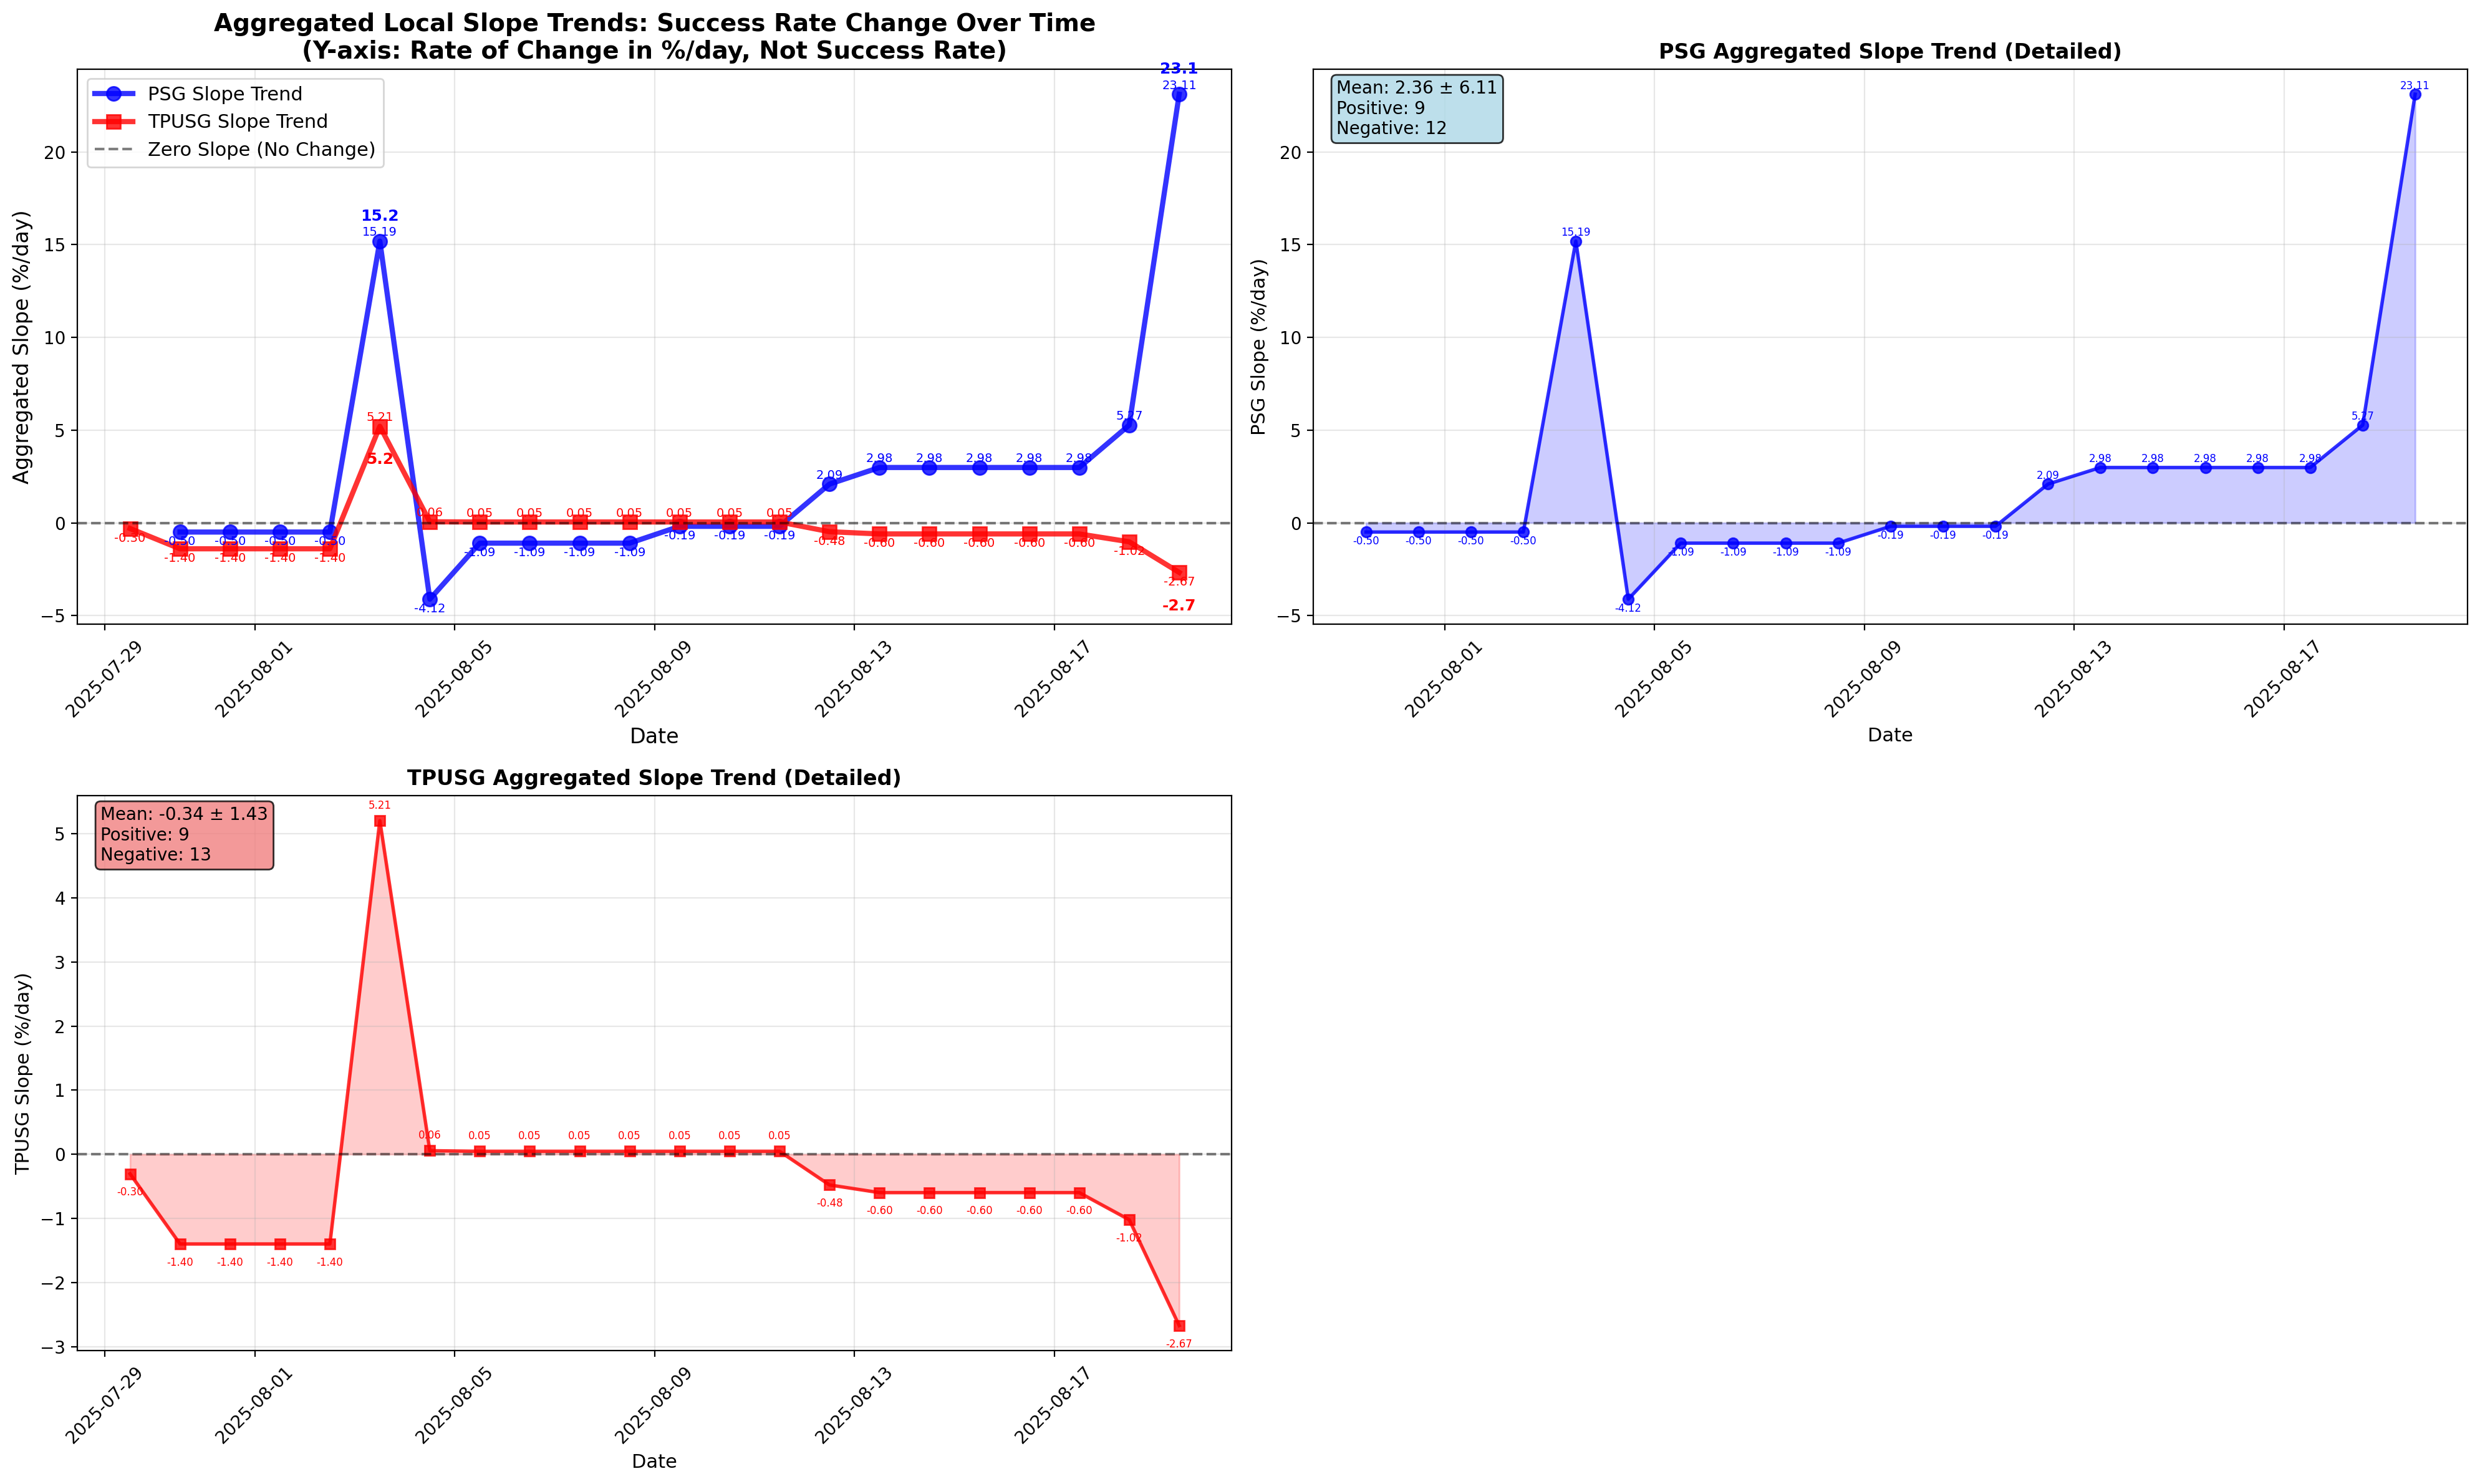


✅ AGGREGATED SLOPE ANALYSIS COMPLETE!
📊 Successfully analyzed 22 day-pair measurements
🎯 Key insight: Y-axis shows rate of change (%/day), not success rate
📈 Positive slopes = performance improving over time
📉 Negative slopes = performance declining over time
➖ Zero slope = stable performance


In [20]:
def plot_aggregated_slope_trends(aggregated_slopes):
    """
    Create visualization of aggregated slope trends for PSG vs TPUSG.
    """
    print("🎨 Creating aggregated slope trends visualization...")
    
    if aggregated_slopes is None or aggregated_slopes.empty:
        print("❌ No aggregated slopes data to plot")
        return
    
    # Create the main plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Prepare data for plotting
    valid_data = aggregated_slopes[
        (~aggregated_slopes['psg_mean_slope'].isna()) | 
        (~aggregated_slopes['tpusg_mean_slope'].isna())
    ]
    
    if valid_data.empty:
        print("❌ No valid slope data for plotting")
        return
    
    # Convert day_pair_midpoint to datetime for plotting
    x_dates = pd.to_datetime(valid_data['day_pair_start']) + (pd.to_datetime(valid_data['day_pair_end']) - pd.to_datetime(valid_data['day_pair_start'])) / 2

    # <CHANGES>
    def annotate_points(ax, x_vals, y_vals, color, fmt='{:.2f}', fontsize=7):
        for xv, yv in zip(x_vals, y_vals):
            offset = 0.15 if yv >= 0 else -0.2
            if yv + offset > ax.get_ylim()[1]:
                offset = -0.2
            if yv + offset < ax.get_ylim()[0]:
                offset = 0.15
            va = 'bottom' if offset >= 0 else 'top'
            ax.text(xv, yv + offset, fmt.format(yv), color=color, fontsize=fontsize, ha='center', va=va)
    # </CHANGES>
    
    # Plot 1: Combined slope trends
    psg_valid = ~valid_data['psg_mean_slope'].isna()
    tpusg_valid = ~valid_data['tpusg_mean_slope'].isna()
    
    if psg_valid.any():
        ax1.plot(x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'], 
                'o-', color='blue', linewidth=3, markersize=8, alpha=0.8, label='PSG Slope Trend')
        # <CHANGES>
        annotate_points(ax1, x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'], color='blue', fmt='{:.2f}')
        # </CHANGES>
    
    if tpusg_valid.any():
        ax1.plot(x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'], 
                's-', color='red', linewidth=3, markersize=8, alpha=0.8, label='TPUSG Slope Trend')
        # <CHANGES>
        annotate_points(ax1, x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'], color='red', fmt='{:.2f}')
        # </CHANGES>
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero Slope (No Change)')
    ax1.set_title('Aggregated Local Slope Trends: Success Rate Change Over Time\n(Y-axis: Rate of Change in %/day, Not Success Rate)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Aggregated Slope (%/day)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value annotations for key points
    if psg_valid.any():
        for i, (date, slope) in enumerate(zip(x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'])):
            if abs(slope) > np.std(valid_data[psg_valid]['psg_mean_slope']) * 1.5:  # Highlight outliers
                ax1.annotate(f'{slope:.1f}', (date, slope), xytext=(0, 10), 
                           textcoords='offset points', ha='center', va='bottom', 
                           fontsize=9, color='blue', fontweight='bold')
    
    if tpusg_valid.any():
        for i, (date, slope) in enumerate(zip(x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'])):
            if abs(slope) > np.std(valid_data[tpusg_valid]['tpusg_mean_slope']) * 1.5:  # Highlight outliers
                ax1.annotate(f'{slope:.1f}', (date, slope), xytext=(0, -15), 
                           textcoords='offset points', ha='center', va='top', 
                           fontsize=9, color='red', fontweight='bold')
    
    # Plot 2: PSG slope trend only (detailed)
    if psg_valid.any():
        ax2.plot(x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'], 
                'o-', color='blue', linewidth=2, markersize=6, alpha=0.8)
        ax2.fill_between(x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'], 
                        alpha=0.2, color='blue')
        # <CHANGES>
        annotate_points(ax2, x_dates[psg_valid], valid_data[psg_valid]['psg_mean_slope'], color='blue', fmt='{:.2f}', fontsize=6)
        # </CHANGES>
    
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('PSG Aggregated Slope Trend (Detailed)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('PSG Slope (%/day)', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add summary statistics
    if psg_valid.any():
        psg_slopes = valid_data[psg_valid]['psg_mean_slope']
        psg_mean = psg_slopes.mean()
        psg_std = psg_slopes.std()
        psg_positive = (psg_slopes > 0).sum()
        psg_negative = (psg_slopes < 0).sum()
        
        psg_stats_text = f'Mean: {psg_mean:.2f} ± {psg_std:.2f}\nPositive: {psg_positive}\nNegative: {psg_negative}'
        ax2.text(0.02, 0.98, psg_stats_text, transform=ax2.transAxes, 
                verticalalignment='top', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Plot 3: TPUSG slope trend only (detailed)
    if tpusg_valid.any():
        ax3.plot(x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'], 
                's-', color='red', linewidth=2, markersize=6, alpha=0.8)
        ax3.fill_between(x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'], 
                        alpha=0.2, color='red')
        # <CHANGES>
        annotate_points(ax3, x_dates[tpusg_valid], valid_data[tpusg_valid]['tpusg_mean_slope'], color='red', fmt='{:.2f}', fontsize=6)
        # </CHANGES>
    
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('TPUSG Aggregated Slope Trend (Detailed)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=11)
    ax3.set_ylabel('TPUSG Slope (%/day)', fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add summary statistics
    if tpusg_valid.any():
        tpusg_slopes = valid_data[tpusg_valid]['tpusg_mean_slope']
        tpusg_mean = tpusg_slopes.mean()
        tpusg_std = tpusg_slopes.std()
        tpusg_positive = (tpusg_slopes > 0).sum()
        tpusg_negative = (tpusg_slopes < 0).sum()
        
        tpusg_stats_text = f'Mean: {tpusg_mean:.2f} ± {tpusg_std:.2f}\nPositive: {tpusg_positive}\nNegative: {tpusg_negative}'
        ax3.text(0.02, 0.98, tpusg_stats_text, transform=ax3.transAxes, 
                verticalalignment='top', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Plot 4: Data coverage and summary
    ax4.axis('off')
    
    # Create comprehensive summary
    summary_text = "📊 AGGREGATED SLOPE ANALYSIS SUMMARY\n" + "="*60 + "\n\n"
    
    summary_text += "🎯 METHODOLOGY:\n"
    summary_text += "1. Calculate slopes between consecutive points for each config\n"
    summary_text += "2. For each day-pair, average slopes of all configs covering it\n"
    summary_text += "3. Plot aggregated trend (NOT success rate, but rate of change)\n\n"
    
    if psg_valid.any() and tpusg_valid.any():
        psg_slopes = valid_data[psg_valid]['psg_mean_slope']
        tpusg_slopes = valid_data[tpusg_valid]['tpusg_mean_slope']
        
        summary_text += "📈 SLOPE TREND COMPARISON:\n" + "-"*35 + "\n"
        summary_text += f"PSG Average Slope:   {psg_slopes.mean():6.2f} ± {psg_slopes.std():.2f} %/day\n"
        summary_text += f"TPUSG Average Slope: {tpusg_slopes.mean():6.2f} ± {tpusg_slopes.std():.2f} %/day\n"
        summary_text += f"Difference:          {tpusg_slopes.mean() - psg_slopes.mean():+6.2f} %/day\n\n"
        
        # Overall trend analysis
        psg_overall_trend = "Improving" if psg_slopes.mean() > 0 else "Declining" if psg_slopes.mean() < 0 else "Stable"
        tpusg_overall_trend = "Improving" if tpusg_slopes.mean() > 0 else "Declining" if tpusg_slopes.mean() < 0 else "Stable"
        
        summary_text += "🏆 OVERALL TRENDS:\n" + "-"*25 + "\n"
        summary_text += f"PSG Trend:   {psg_overall_trend} ({psg_slopes.mean():+.2f} %/day)\n"
        summary_text += f"TPUSG Trend: {tpusg_overall_trend} ({tpusg_slopes.mean():+.2f} %/day)\n\n"
        
        # Data coverage
        summary_text += "📊 DATA COVERAGE:\n" + "-"*20 + "\n"
        summary_text += f"PSG day-pairs:   {psg_valid.sum():2d}/{len(valid_data)}\n"
        summary_text += f"TPUSG day-pairs: {tpusg_valid.sum():2d}/{len(valid_data)}\n"
        summary_text += f"Date range:      {valid_data['day_pair_start'].min()} to {valid_data['day_pair_end'].max()}\n\n"
        
        # Slope configuration counts
        avg_psg_configs = valid_data[psg_valid]['psg_slope_count'].mean()
        avg_tpusg_configs = valid_data[tpusg_valid]['tpusg_slope_count'].mean()
        summary_text += f"Avg configs per day-pair:\n"
        summary_text += f"  PSG: {avg_psg_configs:.1f} configurations\n"
        summary_text += f"  TPUSG: {avg_tpusg_configs:.1f} configurations\n"
    print(summary_text)
    # ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
    #         verticalalignment='top', fontfamily='monospace',
    #         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    return valid_data

# Execute the visualization
if 'aggregated_slopes' in locals() and aggregated_slopes is not None:
    print(f"\n📈 CREATING AGGREGATED SLOPE VISUALIZATION...")
    print("="*60)
    
    processed_data = plot_aggregated_slope_trends(aggregated_slopes)
    
    if processed_data is not None:
        print(f"\n✅ AGGREGATED SLOPE ANALYSIS COMPLETE!")
        print("="*50)
        print(f"📊 Successfully analyzed {len(processed_data)} day-pair measurements")
        print(f"🎯 Key insight: Y-axis shows rate of change (%/day), not success rate")
        print(f"📈 Positive slopes = performance improving over time")
        print(f"📉 Negative slopes = performance declining over time")
        print(f"➖ Zero slope = stable performance")
    else:
        print("❌ Visualization failed due to data issues")
else:
    print("❌ aggregated_slopes not available - run previous cell first")